# Prepare NeuralForecast

## PreTrain

In [1]:
import pandas as pd
import numpy as np
from datetime import *
from dateutil.relativedelta import relativedelta as reladate

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

In [3]:
from neuralforecast import NeuralForecast
from neuralforecast.models import TimeXer
from neuralforecast.losses.pytorch import MAE

c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


## Prepare Data


In [44]:
df= pd.read_csv(r'D:\DATN\vnindex_with_usd_dji_gold_oil.csv')
df1 = df
df1 = df1.reset_index().rename(columns={'date': 'ds'})
df1['unique_id'] = 'VNINDEX'
df1.rename(columns={'OT': 'y'}, inplace=True)
# Kết quả
df1 = df1[['unique_id', 'ds', 'y']]
df1['ds'] = pd.to_datetime(df1['ds'])
df=df1

In [45]:
df

,unique_id,ds,y
0,VNINDEX,2015-01-05,544.45
1,VNINDEX,2015-01-06,549.66
2,VNINDEX,2015-01-07,552.05
3,VNINDEX,2015-01-08,553.47
4,VNINDEX,2015-01-09,569.73
...,...,...,...
2551,VNINDEX,2025-03-27,1323.81
2552,VNINDEX,2025-03-28,1317.46
2553,VNINDEX,2025-03-31,1306.86
2554,VNINDEX,2025-04-01,1317.33


In [46]:

# Xác định kích thước các tập
train_size = int(len(df) * 0.7)  # 70% cho train
val_len = int(len(df) * 0.2)    # 20% cho validation
test_len = len(df) - train_size - val_len  # Phần còn lại cho test

# Chia dữ liệu theo thời gian
train_df = df.iloc[:train_size].reset_index(drop=True)
val_df = df.iloc[train_size:train_size + val_len].reset_index(drop=True)
test_df = df.iloc[train_size + val_len:].reset_index(drop=True)

# Kiểm tra kích thước
print("VNINDEX:")
print(f"Train size: {len(train_df)}")
print(f"Validation size: {len(val_df)}")
print(f"Test size: {len(test_df)}")

VNINDEX:
Train size: 1789
Validation size: 511
Test size: 256


In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2556 entries, 0 to 2555
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   unique_id  2556 non-null   object        
 1   ds         2556 non-null   datetime64[ns]
 2   y          2556 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 60.0+ KB


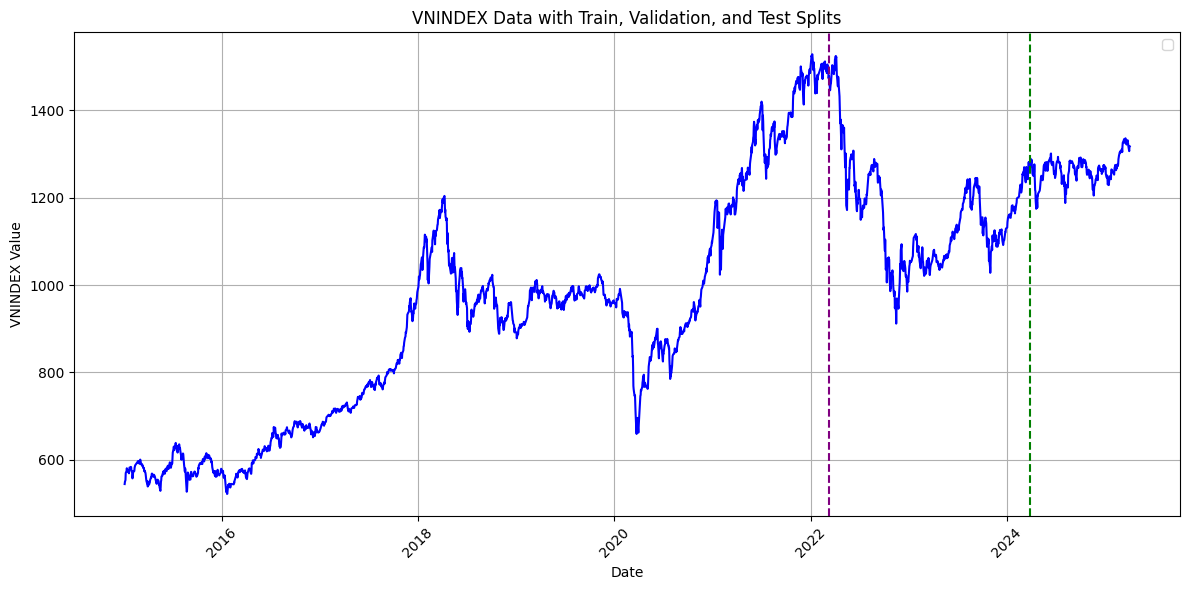

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure 'date' column is datetime and set as index
df['ds'] = pd.to_datetime(df['ds'])
# df.set_index('ds', inplace=True)

# Create the line chart
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['y'], color='blue')

# Calculate the indices where splits occur
train_size = int(len(df) * 0.7)
val_len = int(len(df) * 0.2)
val_end = train_size + val_len

# Plot vertical dashed lines at split points
plt.axvline(x=df.index[train_size], color='purple', linestyle='--')
plt.axvline(x=df.index[val_end], color='green', linestyle='--')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('VNINDEX Value')
plt.title('VNINDEX Data with Train, Validation, and Test Splits')
plt.legend()
plt.grid(True)

# Format x-axis for dates
plt.xticks(rotation=45)

# Show plot
plt.tight_layout()
plt.show()

# Close



## Bayes- chuỗi 10 năm - dự báo 20 bước 


In [48]:
### Bayes
## Bayes
import pandas as pd
import numpy as np
from skopt import gp_minimize, forest_minimize, gbrt_minimize
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from skopt.plots import plot_convergence, plot_objective, plot_evaluations
from neuralforecast import NeuralForecast
from neuralforecast.models import TimeXer
from neuralforecast.losses.pytorch import MAE, MSE, RMSE
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_percentage_error as mape
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


In [49]:


horizon = 20

# Định nghĩa không gian tìm kiếm 
dimensions = [
    Integer(low=40, high=80, name='input_size'),
    Categorical(categories=[128, 256], name='hidden_size'),
    Categorical(categories=[8, 16], name='n_heads'),
    Integer(low=1, high=3, name='e_layers'),
    Categorical(categories=[256, 512], name='d_ff'),
    Real(low=0.0, high=0.3, name='dropout'),
    Real(low=1e-5, high=1e-3, prior='log-uniform', name='learning_rate'),
    Categorical(categories=[32, 64,128], name='batch_size'),
    Integer(low=500, high=1000, name='max_steps'),
    Categorical(categories=['standard', 'robust', 'minmax'], name='scaler_type'),
]

# Global variables để lưu kết quả
results_history = []
best_score = float('inf')
best_params = None

# Callback function để lưu kết quả trong quá trình optimize
def callback_func(result):
    global results_history, best_score, best_params
    
    current_score = result.func_vals[-1]
    current_params = dict(zip([dim.name for dim in dimensions], result.x_iters[-1]))
    
    results_history.append({
        'iteration': len(result.func_vals),
        'score': current_score,
        **current_params
    })
    
    if current_score < best_score:
        best_score = current_score
        best_params = current_params.copy()
        print(f"New best score: {current_score:.4f} at iteration {len(result.func_vals)}")

@use_named_args(dimensions)
def objective(**params):
    """
    Hàm mục tiêu cho Bayesian Optimization
    """
    try:
        # Tạo mô hình với các siêu tham số
        model = TimeXer(
            h=horizon,
            input_size=params['input_size'],
            n_series=1,
            hidden_size=params['hidden_size'],
            n_heads=params['n_heads'],
            e_layers=params['e_layers'],
            d_ff=params['d_ff'],
            dropout=params['dropout'],
            loss=MAE(),
            valid_loss=MAE(),
            max_steps=params['max_steps'],
            learning_rate=params['learning_rate'],
            scaler_type=params['scaler_type'],
            early_stop_patience_steps=5,
            batch_size=params['batch_size'],
            #futr_exog_list= ['usd_vnd','DJI_Close','Gold_Close','Oil_Close']

        )
        
        # Khởi tạo NeuralForecast
        fcst = NeuralForecast(models=[model], freq='B')
        
        # Thực hiện cross validation
        forecasts = fcst.cross_validation(
            df=df1, 
            val_size=val_len, 
            n_windows=None, 
            test_size=test_len - ((test_len - horizon) % horizon), 
            step_size=horizon
        )
        
        # Tính toán MAE
        Y_true = forecasts['y'].values
        Y_hat = forecasts['TimeXer'].values
        MAE_score = mae(Y_true, Y_hat)
        
        print(f"MAE: {MAE_score:.4f} | Params: {params}")
        return MAE_score
        
    except Exception as e:
        print(f"Error in objective function: {e}")
        return 1000.0  # Penalty for failed runs





In [50]:
# Phương pháp 1: Gaussian Process Optimization
print("="*60)
print("PHƯƠNG PHÁP 1: GAUSSIAN PROCESS OPTIMIZATION")
print("="*60)

result_gp = gp_minimize(
    func=objective,
    dimensions=dimensions,
    n_calls=50,  # Số lần gọi hàm objective
    n_initial_points=10,  # Số điểm khởi tạo random
    acq_func='EI',  # Expected Improvement
    random_state=42,
    callback=callback_func
)

print(f"Best GP score: {result_gp.fun:.4f}")
print("Best GP parameters:")
for dim, val in zip(dimensions, result_gp.x):
    print(f"  {dim.name}: {val}")

# # Phương pháp 2: Random Forest Optimization
# print("\n" + "="*60)
# print("PHƯƠNG PHÁP 2: RANDOM FOREST OPTIMIZATION")
# print("="*60)

# results_history = []  # Reset history
# result_rf = forest_minimize(
#     func=objective,
#     dimensions=dimensions,
#     n_calls=50,
#     n_initial_points=10,
#     random_state=42,
#     callback=callback_func
# )

# print(f"Best RF score: {result_rf.fun:.4f}")
# print("Best RF parameters:")
# for dim, val in zip(dimensions, result_rf.x):
#     print(f"  {dim.name}: {val}")

# Phương pháp 3: Gradient Boosted Trees Optimization  
print("\n" + "="*60)
print("PHƯƠNG PHÁP 3: GRADIENT BOOSTED TREES OPTIMIZATION")
print("="*60)

results_history = []  # Reset history
result_gbrt = gbrt_minimize(
    func=objective,
    dimensions=dimensions,
    n_calls=50,
    n_initial_points=10,
    random_state=42,
    callback=callback_func
)

print(f"Best GBRT score: {result_gbrt.fun:.4f}")
print("Best GBRT parameters:")
for dim, val in zip(dimensions, result_gbrt.x):
    print(f"  {dim.name}: {val}")

# So sánh kết quả của 3 phương pháp
print("\n" + "="*60)
print("SO SÁNH KẾT QUẢ")
print("="*60)

methods_comparison = pd.DataFrame({
    'Method': ['Gaussian Process',  'Gradient Boosted Trees'],
    'Best_MAE': [result_gp.fun,  result_gbrt.fun],
    'N_calls': [len(result_gp.func_vals), len(result_gbrt.func_vals)]
})

print(methods_comparison.to_string(index=False))


# Chọn phương pháp tốt nhất
best_method_idx = methods_comparison['Best_MAE'].idxmin()
best_method = methods_comparison.iloc[best_method_idx]['Method']
best_result = [result_gp, result_gbrt][best_method_idx]

print(f"\nPhương pháp tốt nhất: {best_method}")
print(f"Điểm số tốt nhất: {best_result.fun:.4f}")


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


PHƯƠNG PHÁP 1: GAUSSIAN PROCESS OPTIMIZATION



  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 9.3 K  | train
6 | encoder      | Encoder                | 397 K  | train
7 | head         | FlattenHead            | 12.8 K | train
----------------------------------------------------------------
422 K     Trainable params
0         Non-trainable params
422 K     Total params
1.689     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=571` reached.
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1


MAE: 23.5100 | Params: {'input_size': 72, 'hidden_size': 128, 'n_heads': 16, 'e_layers': 2, 'd_ff': 256, 'dropout': 0.02999247474540087, 'learning_rate': 8.288916866885136e-05, 'batch_size': 64, 'max_steps': 571, 'scaler_type': 'robust'}
New best score: 23.5100 at iteration 1


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 11.0 K | train
6 | encoder      | Encoder                | 791 K  | train
7 | head         | FlattenHead            | 15.4 K | train
----------------------------------------------------------------
822 K     Trainable params
0         Non-trainable params
822 K     Total params
3.288     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=512` reached.
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


MAE: 21.7986 | Params: {'input_size': 42, 'hidden_size': 256, 'n_heads': 16, 'e_layers': 1, 'd_ff': 512, 'dropout': 0.18524445288831498, 'learning_rate': 0.00016722697006183674, 'batch_size': 32, 'max_steps': 512, 'scaler_type': 'robust'}
New best score: 21.7986 at iteration 2



  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 7.3 K  | train
6 | encoder      | Encoder                | 199 K  | train
7 | head         | FlattenHead            | 10.3 K | train
----------------------------------------------------------------
218 K     Trainable params
0         Non-trainable params
218 K     Total params
0.875     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=733` reached.
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1


MAE: 22.7590 | Params: {'input_size': 56, 'hidden_size': 128, 'n_heads': 16, 'e_layers': 1, 'd_ff': 256, 'dropout': 0.18551580279992622, 'learning_rate': 5.820013372709849e-05, 'batch_size': 128, 'max_steps': 733, 'scaler_type': 'minmax'}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 8.7 K  | train
6 | encoder      | Encoder                | 793 K  | train
7 | head         | FlattenHead            | 12.8 K | train
----------------------------------------------------------------
817 K     Trainable params
0         Non-trainable params
817 K     Total params
3.271     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=621` reached.
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


MAE: 28.7386 | Params: {'input_size': 67, 'hidden_size': 128, 'n_heads': 8, 'e_layers': 3, 'd_ff': 512, 'dropout': 0.11562495076197486, 'learning_rate': 1.0762979285747968e-05, 'batch_size': 32, 'max_steps': 621, 'scaler_type': 'minmax'}



  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 16.6 K | train
6 | encoder      | Encoder                | 1.3 M  | train
7 | head         | FlattenHead            | 25.6 K | train
----------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.464     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=784` reached.
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


MAE: 21.4100 | Params: {'input_size': 64, 'hidden_size': 256, 'n_heads': 8, 'e_layers': 2, 'd_ff': 256, 'dropout': 0.2266084230952958, 'learning_rate': 7.084541505250234e-05, 'batch_size': 32, 'max_steps': 784, 'scaler_type': 'standard'}
New best score: 21.4100 at iteration 5



  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 9.6 K  | train
6 | encoder      | Encoder                | 793 K  | train
7 | head         | FlattenHead            | 12.8 K | train
----------------------------------------------------------------
818 K     Trainable params
0         Non-trainable params
818 K     Total params
3.274     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=981` reached.
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


MAE: 23.4632 | Params: {'input_size': 74, 'hidden_size': 128, 'n_heads': 8, 'e_layers': 3, 'd_ff': 512, 'dropout': 0.09796223064175062, 'learning_rate': 0.00013832094546570485, 'batch_size': 64, 'max_steps': 981, 'scaler_type': 'minmax'}



  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 18.2 K | train
6 | encoder      | Encoder                | 2.4 M  | train
7 | head         | FlattenHead            | 25.6 K | train
----------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.684     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=508` reached.
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


MAE: 24.3534 | Params: {'input_size': 70, 'hidden_size': 256, 'n_heads': 16, 'e_layers': 3, 'd_ff': 512, 'dropout': 0.08279975460676302, 'learning_rate': 3.913334858104373e-05, 'batch_size': 32, 'max_steps': 508, 'scaler_type': 'robust'}



  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 7.3 K  | train
6 | encoder      | Encoder                | 264 K  | train
7 | head         | FlattenHead            | 10.3 K | train
----------------------------------------------------------------
284 K     Trainable params
0         Non-trainable params
284 K     Total params
1.138     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=826` reached.
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


MAE: 22.1803 | Params: {'input_size': 56, 'hidden_size': 128, 'n_heads': 8, 'e_layers': 1, 'd_ff': 512, 'dropout': 0.23705266215936174, 'learning_rate': 0.00016289957436723494, 'batch_size': 128, 'max_steps': 826, 'scaler_type': 'minmax'}



  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 9.6 K  | train
6 | encoder      | Encoder                | 529 K  | train
7 | head         | FlattenHead            | 12.8 K | train
----------------------------------------------------------------
554 K     Trainable params
0         Non-trainable params
554 K     Total params
2.216     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=781` reached.
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


MAE: 23.3631 | Params: {'input_size': 74, 'hidden_size': 128, 'n_heads': 8, 'e_layers': 2, 'd_ff': 512, 'dropout': 0.19977670698524902, 'learning_rate': 0.00015226341829186323, 'batch_size': 32, 'max_steps': 781, 'scaler_type': 'robust'}



  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 20.5 K | train
6 | encoder      | Encoder                | 659 K  | train
7 | head         | FlattenHead            | 25.6 K | train
----------------------------------------------------------------
710 K     Trainable params
0         Non-trainable params
710 K     Total params
2.842     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=720` reached.
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

MAE: 27.9444 | Params: {'input_size': 79, 'hidden_size': 256, 'n_heads': 16, 'e_layers': 1, 'd_ff': 256, 'dropout': 0.012130076861529405, 'learning_rate': 0.0002638309731463534, 'batch_size': 32, 'max_steps': 720, 'scaler_type': 'standard'}


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 13.3 K | train
6 | encoder      | Encoder                | 2.0 M  | train
7 | head         | FlattenHead            | 20.5 K | train
----------------------------------------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
8.068     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=32


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 5.2 K  | train
6 | encoder      | Encoder                | 529 K  | train
7 | head         | FlattenHead            | 7.7 K  | train
----------------------------------------------------------------
544 K     Trainable params
0         Non-trainable params
544 K     Total params
2.178     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=64


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 18.2 K | train
6 | encoder      | Encoder                | 1.3 M  | train
7 | head         | FlattenHead            | 25.6 K | train
----------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.470     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=32


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 15.6 K | train
6 | encoder      | Encoder                | 2.0 M  | train
7 | head         | FlattenHead            | 20.5 K | train
----------------------------------------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
8.077     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=32


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 15.6 K | train
6 | encoder      | Encoder                | 1.3 M  | train
7 | head         | FlattenHead            | 20.5 K | train
----------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.440     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=32


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 10.0 K | train
6 | encoder      | Encoder                | 264 K  | train
7 | head         | FlattenHead            | 12.8 K | train
----------------------------------------------------------------
289 K     Trainable params
0         Non-trainable params
289 K     Total params
1.159     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=64


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 7.4 K  | train
6 | encoder      | Encoder                | 397 K  | train
7 | head         | FlattenHead            | 10.3 K | train
----------------------------------------------------------------
417 K     Trainable params
0         Non-trainable params
417 K     Total params
1.671     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=32


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 10.4 K | train
6 | encoder      | Encoder                | 264 K  | train
7 | head         | FlattenHead            | 15.4 K | train
----------------------------------------------------------------
292 K     Trainable params
0         Non-trainable params
292 K     Total params
1.171     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=128


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 17.2 K | train
6 | encoder      | Encoder                | 2.0 M  | train
7 | head         | FlattenHead            | 25.6 K | train
----------------------------------------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
8.104     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=64


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 17.4 K | train
6 | encoder      | Encoder                | 1.6 M  | train
7 | head         | FlattenHead            | 25.6 K | train
----------------------------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.518     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=64


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 10.4 K | train
6 | encoder      | Encoder                | 793 K  | train
7 | head         | FlattenHead            | 15.4 K | train
----------------------------------------------------------------
821 K     Trainable params
0         Non-trainable params
821 K     Total params
3.288     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=32


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 9.3 K  | train
6 | encoder      | Encoder                | 264 K  | train
7 | head         | FlattenHead            | 12.8 K | train
----------------------------------------------------------------
289 K     Trainable params
0         Non-trainable params
289 K     Total params
1.157     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=32


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 9.2 K  | train
6 | encoder      | Encoder                | 793 K  | train
7 | head         | FlattenHead            | 12.8 K | train
----------------------------------------------------------------
818 K     Trainable params
0         Non-trainable params
818 K     Total params
3.273     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=32


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 17.4 K | train
6 | encoder      | Encoder                | 659 K  | train
7 | head         | FlattenHead            | 25.6 K | train
----------------------------------------------------------------
707 K     Trainable params
0         Non-trainable params
707 K     Total params
2.829     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=32


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 13.1 K | train
6 | encoder      | Encoder                | 1.3 M  | train
7 | head         | FlattenHead            | 20.5 K | train
----------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.429     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=32


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 7.6 K  | train
6 | encoder      | Encoder                | 264 K  | train
7 | head         | FlattenHead            | 10.3 K | train
----------------------------------------------------------------
284 K     Trainable params
0         Non-trainable params
284 K     Total params
1.139     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=128


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 6.7 K  | train
6 | encoder      | Encoder                | 529 K  | train
7 | head         | FlattenHead            | 10.3 K | train
----------------------------------------------------------------
548 K     Trainable params
0         Non-trainable params
548 K     Total params
2.194     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=128


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 7.0 K  | train
6 | encoder      | Encoder                | 397 K  | train
7 | head         | FlattenHead            | 10.3 K | train
----------------------------------------------------------------
417 K     Trainable params
0         Non-trainable params
417 K     Total params
1.669     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=128


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 9.9 K  | train
6 | encoder      | Encoder                | 397 K  | train
7 | head         | FlattenHead            | 12.8 K | train
----------------------------------------------------------------
422 K     Trainable params
0         Non-trainable params
422 K     Total params
1.691     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=32


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 8.2 K  | train
6 | encoder      | Encoder                | 264 K  | train
7 | head         | FlattenHead            | 10.3 K | train
----------------------------------------------------------------
285 K     Trainable params
0         Non-trainable params
285 K     Total params
1.142     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=128


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 6.4 K  | train
6 | encoder      | Encoder                | 397 K  | train
7 | head         | FlattenHead            | 10.3 K | train
----------------------------------------------------------------
416 K     Trainable params
0         Non-trainable params
416 K     Total params
1.667     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=128


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 10.5 K | train
6 | encoder      | Encoder                | 2.0 M  | train
7 | head         | FlattenHead            | 15.4 K | train
----------------------------------------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
8.036     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=32


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 14.6 K | train
6 | encoder      | Encoder                | 1.3 M  | train
7 | head         | FlattenHead            | 20.5 K | train
----------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.435     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=32


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 16.6 K | train
6 | encoder      | Encoder                | 659 K  | train
7 | head         | FlattenHead            | 25.6 K | train
----------------------------------------------------------------
706 K     Trainable params
0         Non-trainable params
706 K     Total params
2.826     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=128


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 17.2 K | train
6 | encoder      | Encoder                | 1.3 M  | train
7 | head         | FlattenHead            | 25.6 K | train
----------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.466     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=32


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 15.9 K | train
6 | encoder      | Encoder                | 1.6 M  | train
7 | head         | FlattenHead            | 20.5 K | train
----------------------------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.491     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=32


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 18.7 K | train
6 | encoder      | Encoder                | 1.3 M  | train
7 | head         | FlattenHead            | 25.6 K | train
----------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.472     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=32


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 7.9 K  | train
6 | encoder      | Encoder                | 264 K  | train
7 | head         | FlattenHead            | 10.3 K | train
----------------------------------------------------------------
285 K     Trainable params
0         Non-trainable params
285 K     Total params
1.141     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=128


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 6.4 K  | train
6 | encoder      | Encoder                | 529 K  | train
7 | head         | FlattenHead            | 10.3 K | train
----------------------------------------------------------------
548 K     Trainable params
0         Non-trainable params
548 K     Total params
2.193     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=32


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 9.2 K  | train
6 | encoder      | Encoder                | 397 K  | train
7 | head         | FlattenHead            | 12.8 K | train
----------------------------------------------------------------
422 K     Trainable params
0         Non-trainable params
422 K     Total params
1.688     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=64


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 9.9 K  | train
6 | encoder      | Encoder                | 264 K  | train
7 | head         | FlattenHead            | 12.8 K | train
----------------------------------------------------------------
289 K     Trainable params
0         Non-trainable params
289 K     Total params
1.159     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=128


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 5.8 K  | train
6 | encoder      | Encoder                | 529 K  | train
7 | head         | FlattenHead            | 7.7 K  | train
----------------------------------------------------------------
545 K     Trainable params
0         Non-trainable params
545 K     Total params
2.180     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=32


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 6.3 K  | train
6 | encoder      | Encoder                | 199 K  | train
7 | head         | FlattenHead            | 10.3 K | train
----------------------------------------------------------------
217 K     Trainable params
0         Non-trainable params
217 K     Total params
0.871     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=128


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 15.1 K | train
6 | encoder      | Encoder                | 1.6 M  | train
7 | head         | FlattenHead            | 20.5 K | train
----------------------------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.488     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=32


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 16.6 K | train
6 | encoder      | Encoder                | 2.4 M  | train
7 | head         | FlattenHead            | 25.6 K | train
----------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.678     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=64


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 9.3 K  | train
6 | encoder      | Encoder                | 199 K  | train
7 | head         | FlattenHead            | 12.8 K | train
----------------------------------------------------------------
223 K     Trainable params
0         Non-trainable params
223 K     Total params
0.894     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=64


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 9.6 K  | train
6 | encoder      | Encoder                | 397 K  | train
7 | head         | FlattenHead            | 12.8 K | train
----------------------------------------------------------------
422 K     Trainable params
0         Non-trainable params
422 K     Total params
1.690     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=64


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 15.1 K | train
6 | encoder      | Encoder                | 1.3 M  | train
7 | head         | FlattenHead            | 20.5 K | train
----------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.438     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=32


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 7.8 K  | train
6 | encoder      | Encoder                | 793 K  | train
7 | head         | FlattenHead            | 10.3 K | train
----------------------------------------------------------------
814 K     Trainable params
0         Non-trainable params
814 K     Total params
3.257     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=32


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 7.3 K  | train
6 | encoder      | Encoder                | 397 K  | train
7 | head         | FlattenHead            | 10.3 K | train
----------------------------------------------------------------
417 K     Trainable params
0         Non-trainable params
417 K     Total params
1.670     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=64


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Best GP score: 21.4100
Best GP parameters:
  input_size: 64
  hidden_size: 256
  n_heads: 8
  e_layers: 2
  d_ff: 256
  dropout: 0.2266084230952958
  learning_rate: 7.084541505250234e-05
  batch_size: 32
  max_steps: 784
  scaler_type: standard

PHƯƠNG PHÁP 3: GRADIENT BOOSTED TREES OPTIMIZATION



  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 14.3 K | train
6 | encoder      | Encoder                | 1.3 M  | train
7 | head         | FlattenHead            | 20.5 K | train
----------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.434     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=801` reached.
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


MAE: 24.7242 | Params: {'input_size': 55, 'hidden_size': 256, 'n_heads': 16, 'e_layers': 2, 'd_ff': 256, 'dropout': 0.0467983561008608, 'learning_rate': 1.3066739238053285e-05, 'batch_size': 128, 'max_steps': 801, 'scaler_type': 'minmax'}



  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 10.8 K | train
6 | encoder      | Encoder                | 659 K  | train
7 | head         | FlattenHead            | 15.4 K | train
----------------------------------------------------------------
690 K     Trainable params
0         Non-trainable params
690 K     Total params
2.762     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=716` reached.
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


MAE: 23.0004 | Params: {'input_size': 41, 'hidden_size': 256, 'n_heads': 16, 'e_layers': 1, 'd_ff': 256, 'dropout': 0.05502135295603015, 'learning_rate': 4.059611610484304e-05, 'batch_size': 64, 'max_steps': 716, 'scaler_type': 'standard'}



  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 8.3 K  | train
6 | encoder      | Encoder                | 397 K  | train
7 | head         | FlattenHead            | 12.8 K | train
----------------------------------------------------------------
421 K     Trainable params
0         Non-trainable params
421 K     Total params
1.685     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=796` reached.
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


MAE: 23.7130 | Params: {'input_size': 64, 'hidden_size': 128, 'n_heads': 8, 'e_layers': 2, 'd_ff': 256, 'dropout': 0.23555278841790414, 'learning_rate': 2.508115686045231e-05, 'batch_size': 64, 'max_steps': 796, 'scaler_type': 'standard'}



  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 8.3 K  | train
6 | encoder      | Encoder                | 793 K  | train
7 | head         | FlattenHead            | 12.8 K | train
----------------------------------------------------------------
817 K     Trainable params
0         Non-trainable params
817 K     Total params
3.269     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=842` reached.
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 5.9 K  | train
6 | encoder      | Encoder                | 596 K  | train
7 | head         | FlattenHead            | 7.7 K  | train
----------------------------------------------------------------
612 K     Trainable params
0         Non-trainable params
612 K     Total params
2.449     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


MAE: 22.9371 | Params: {'input_size': 64, 'hidden_size': 128, 'n_heads': 8, 'e_layers': 3, 'd_ff': 512, 'dropout': 0.2425192044349384, 'learning_rate': 4.066563313514792e-05, 'batch_size': 32, 'max_steps': 842, 'scaler_type': 'robust'}


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=773` reached.
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 20.5 K | train
6 | encoder      | Encoder                | 2.4 M  | train
7 | head         | FlattenHead            | 25.6 K | train
----------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.693     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


MAE: 21.4940 | Params: {'input_size': 45, 'hidden_size': 128, 'n_heads': 8, 'e_layers': 3, 'd_ff': 256, 'dropout': 0.1987566853061946, 'learning_rate': 4.201672054372531e-05, 'batch_size': 64, 'max_steps': 773, 'scaler_type': 'standard'}


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=523` reached.
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1


MAE: 26.7605 | Params: {'input_size': 79, 'hidden_size': 256, 'n_heads': 16, 'e_layers': 3, 'd_ff': 512, 'dropout': 0.2765622705069351, 'learning_rate': 1.5030900645056825e-05, 'batch_size': 32, 'max_steps': 523, 'scaler_type': 'standard'}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 7.3 K  | train
6 | encoder      | Encoder                | 397 K  | train
7 | head         | FlattenHead            | 10.3 K | train
----------------------------------------------------------------
417 K     Trainable params
0         Non-trainable params
417 K     Total params
1.670     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=537` reached.
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 9.2 K  | train
6 | encoder      | Encoder                | 793 K  | train
7 | head         | FlattenHead            | 12.8 K | train
----------------------------------------------------------------
818 K     Trainable params
0         Non-trainable params
818 K     Total params
3.273     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


MAE: 28.3227 | Params: {'input_size': 56, 'hidden_size': 128, 'n_heads': 16, 'e_layers': 2, 'd_ff': 256, 'dropout': 0.16280882494747456, 'learning_rate': 1.9135880487692317e-05, 'batch_size': 128, 'max_steps': 537, 'scaler_type': 'minmax'}


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 19.5 K | train
6 | encoder      | Encoder                | 659 K  | train
7 | head         | FlattenHead            | 25.6 K | train
----------------------------------------------------------------
709 K     Trainable params
0         Non-trainable params
709 K     Total params
2.838     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


MAE: 22.2885 | Params: {'input_size': 71, 'hidden_size': 128, 'n_heads': 8, 'e_layers': 3, 'd_ff': 512, 'dropout': 0.2187021504122962, 'learning_rate': 0.0003487712624545935, 'batch_size': 32, 'max_steps': 679, 'scaler_type': 'standard'}


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=944` reached.
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


MAE: 25.3340 | Params: {'input_size': 75, 'hidden_size': 256, 'n_heads': 8, 'e_layers': 1, 'd_ff': 256, 'dropout': 0.09755499660802412, 'learning_rate': 0.0002878805718308926, 'batch_size': 64, 'max_steps': 944, 'scaler_type': 'robust'}



  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 11.8 K | train
6 | encoder      | Encoder                | 1.6 M  | train
7 | head         | FlattenHead            | 15.4 K | train
----------------------------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.454     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=513` reached.
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

MAE: 21.2680 | Params: {'input_size': 45, 'hidden_size': 256, 'n_heads': 16, 'e_layers': 2, 'd_ff': 512, 'dropout': 0.14813867890931726, 'learning_rate': 0.00011103647313054626, 'batch_size': 64, 'max_steps': 513, 'scaler_type': 'standard'}


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


New best score: 21.2680 at iteration 10



  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 5.8 K  | train
6 | encoder      | Encoder                | 397 K  | train
7 | head         | FlattenHead            | 7.7 K  | train
----------------------------------------------------------------
413 K     Trainable params
0         Non-trainable params
413 K     Total params
1.654     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=128


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 13.1 K | train
6 | encoder      | Encoder                | 2.4 M  | train
7 | head         | FlattenHead            | 20.5 K | train
----------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.643     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=32


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 9.1 K  | train
6 | encoder      | Encoder                | 529 K  | train
7 | head         | FlattenHead            | 12.8 K | train
----------------------------------------------------------------
553 K     Trainable params
0         Non-trainable params
553 K     Total params
2.214     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=64


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 8.7 K  | train
6 | encoder      | Encoder                | 199 K  | train
7 | head         | FlattenHead            | 12.8 K | train
----------------------------------------------------------------
222 K     Trainable params
0         Non-trainable params
222 K     Total params
0.891     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=32


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 19.2 K | train
6 | encoder      | Encoder                | 2.4 M  | train
7 | head         | FlattenHead            | 25.6 K | train
----------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.688     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=64


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 11.3 K | train
6 | encoder      | Encoder                | 1.6 M  | train
7 | head         | FlattenHead            | 15.4 K | train
----------------------------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.452     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=64


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 9.9 K  | train
6 | encoder      | Encoder                | 793 K  | train
7 | head         | FlattenHead            | 12.8 K | train
----------------------------------------------------------------
818 K     Trainable params
0         Non-trainable params
818 K     Total params
3.275     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=32


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 20.5 K | train
6 | encoder      | Encoder                | 659 K  | train
7 | head         | FlattenHead            | 25.6 K | train
----------------------------------------------------------------
710 K     Trainable params
0         Non-trainable params
710 K     Total params
2.842     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=64


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 12.3 K | train
6 | encoder      | Encoder                | 2.0 M  | train
7 | head         | FlattenHead            | 15.4 K | train
----------------------------------------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
8.044     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=64


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 7.6 K  | train
6 | encoder      | Encoder                | 529 K  | train
7 | head         | FlattenHead            | 10.3 K | train
----------------------------------------------------------------
549 K     Trainable params
0         Non-trainable params
549 K     Total params
2.198     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=128


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 11.8 K | train
6 | encoder      | Encoder                | 2.4 M  | train
7 | head         | FlattenHead            | 15.4 K | train
----------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.617     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=64


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 11.5 K | train
6 | encoder      | Encoder                | 2.4 M  | train
7 | head         | FlattenHead            | 15.4 K | train
----------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.616     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=64


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 5.9 K  | train
6 | encoder      | Encoder                | 529 K  | train
7 | head         | FlattenHead            | 7.7 K  | train
----------------------------------------------------------------
545 K     Trainable params
0         Non-trainable params
545 K     Total params
2.181     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=64


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 11.8 K | train
6 | encoder      | Encoder                | 2.4 M  | train
7 | head         | FlattenHead            | 15.4 K | train
----------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.617     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=128


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 9.0 K  | train
6 | encoder      | Encoder                | 529 K  | train
7 | head         | FlattenHead            | 12.8 K | train
----------------------------------------------------------------
553 K     Trainable params
0         Non-trainable params
553 K     Total params
2.213     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=128


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 12.8 K | train
6 | encoder      | Encoder                | 791 K  | train
7 | head         | FlattenHead            | 20.5 K | train
----------------------------------------------------------------
828 K     Trainable params
0         Non-trainable params
828 K     Total params
3.316     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=64


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 18.7 K | train
6 | encoder      | Encoder                | 1.6 M  | train
7 | head         | FlattenHead            | 25.6 K | train
----------------------------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.523     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=32


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 8.3 K  | train
6 | encoder      | Encoder                | 529 K  | train
7 | head         | FlattenHead            | 12.8 K | train
----------------------------------------------------------------
552 K     Trainable params
0         Non-trainable params
552 K     Total params
2.211     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=64


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 15.9 K | train
6 | encoder      | Encoder                | 791 K  | train
7 | head         | FlattenHead            | 20.5 K | train
----------------------------------------------------------------
832 K     Trainable params
0         Non-trainable params
832 K     Total params
3.328     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=64


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 16.6 K | train
6 | encoder      | Encoder                | 2.0 M  | train
7 | head         | FlattenHead            | 25.6 K | train
----------------------------------------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
8.102     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=32


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 9.2 K  | train
6 | encoder      | Encoder                | 397 K  | train
7 | head         | FlattenHead            | 12.8 K | train
----------------------------------------------------------------
422 K     Trainable params
0         Non-trainable params
422 K     Total params
1.688     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=32


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 18.7 K | train
6 | encoder      | Encoder                | 791 K  | train
7 | head         | FlattenHead            | 25.6 K | train
----------------------------------------------------------------
839 K     Trainable params
0         Non-trainable params
839 K     Total params
3.360     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=128


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 15.9 K | train
6 | encoder      | Encoder                | 659 K  | train
7 | head         | FlattenHead            | 20.5 K | train
----------------------------------------------------------------
700 K     Trainable params
0         Non-trainable params
700 K     Total params
2.803     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=64


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 10.1 K | train
6 | encoder      | Encoder                | 529 K  | train
7 | head         | FlattenHead            | 12.8 K | train
----------------------------------------------------------------
554 K     Trainable params
0         Non-trainable params
554 K     Total params
2.218     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=32


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 10.2 K | train
6 | encoder      | Encoder                | 264 K  | train
7 | head         | FlattenHead            | 12.8 K | train
----------------------------------------------------------------
290 K     Trainable params
0         Non-trainable params
290 K     Total params
1.160     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=64


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 20.2 K | train
6 | encoder      | Encoder                | 2.0 M  | train
7 | head         | FlattenHead            | 25.6 K | train
----------------------------------------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
8.116     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=128


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 19.2 K | train
6 | encoder      | Encoder                | 2.0 M  | train
7 | head         | FlattenHead            | 25.6 K | train
----------------------------------------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
8.112     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=64


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 8.1 K  | train
6 | encoder      | Encoder                | 529 K  | train
7 | head         | FlattenHead            | 10.3 K | train
----------------------------------------------------------------
549 K     Trainable params
0         Non-trainable params
549 K     Total params
2.200     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=128


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 9.5 K  | train
6 | encoder      | Encoder                | 596 K  | train
7 | head         | FlattenHead            | 12.8 K | train
----------------------------------------------------------------
621 K     Trainable params
0         Non-trainable params
621 K     Total params
2.484     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=64


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 13.3 K | train
6 | encoder      | Encoder                | 1.6 M  | train
7 | head         | FlattenHead            | 20.5 K | train
----------------------------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.481     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=128


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 10.2 K | train
6 | encoder      | Encoder                | 596 K  | train
7 | head         | FlattenHead            | 12.8 K | train
----------------------------------------------------------------
621 K     Trainable params
0         Non-trainable params
621 K     Total params
2.487     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=32


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 8.1 K  | train
6 | encoder      | Encoder                | 529 K  | train
7 | head         | FlattenHead            | 10.3 K | train
----------------------------------------------------------------
549 K     Trainable params
0         Non-trainable params
549 K     Total params
2.200     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=32


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 5.8 K  | train
6 | encoder      | Encoder                | 529 K  | train
7 | head         | FlattenHead            | 7.7 K  | train
----------------------------------------------------------------
545 K     Trainable params
0         Non-trainable params
545 K     Total params
2.180     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=128


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 5.5 K  | train
6 | encoder      | Encoder                | 199 K  | train
7 | head         | FlattenHead            | 7.7 K  | train
----------------------------------------------------------------
214 K     Trainable params
0         Non-trainable params
214 K     Total params
0.858     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=64


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 7.7 K  | train
6 | encoder      | Encoder                | 397 K  | train
7 | head         | FlattenHead            | 10.3 K | train
----------------------------------------------------------------
417 K     Trainable params
0         Non-trainable params
417 K     Total params
1.672     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=128


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 10.5 K | train
6 | encoder      | Encoder                | 791 K  | train
7 | head         | FlattenHead            | 15.4 K | train
----------------------------------------------------------------
821 K     Trainable params
0         Non-trainable params
821 K     Total params
3.286     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=128


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 18.7 K | train
6 | encoder      | Encoder                | 659 K  | train
7 | head         | FlattenHead            | 25.6 K | train
----------------------------------------------------------------
708 K     Trainable params
0         Non-trainable params
708 K     Total params
2.835     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=64


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 5.6 K  | train
6 | encoder      | Encoder                | 793 K  | train
7 | head         | FlattenHead            | 7.7 K  | train
----------------------------------------------------------------
809 K     Trainable params
0         Non-trainable params
809 K     Total params
3.238     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=64


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 11.0 K | train
6 | encoder      | Encoder                | 1.3 M  | train
7 | head         | FlattenHead            | 15.4 K | train
----------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.401     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=128


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 16.9 K | train
6 | encoder      | Encoder                | 2.0 M  | train
7 | head         | FlattenHead            | 25.6 K | train
----------------------------------------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
8.103     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=32
Best GBRT score: 21.2680
Best GBRT parameters:
  input_size: 45
  hidden_size: 256
  n_heads: 16
  e_layers: 2
  d_ff: 512
  dropout: 0.14813867890931726
  learning_rate: 0.00011103647313054626
  batch_size: 64
  max_steps: 513
  scaler_type: standard

SO SÁNH KẾT QUẢ
                Method  Best_MAE  N_calls
      Gaussian Process 21.409954       50
Gradient Boosted Trees 21.268049       50

Phương pháp tốt nhất: Gradient Boosted Trees
Điểm số tốt nhất: 21.2680


In [51]:
# So sánh kết quả của 3 phương pháp
print("\n" + "="*60)
print("SO SÁNH KẾT QUẢ")
print("="*60)

methods_comparison = pd.DataFrame({
    'Method': ['Gaussian Process',  'Gradient Boosted Trees'],
    'Best_MAE': [result_gp.fun,  result_gbrt.fun],
    'N_calls': [len(result_gp.func_vals), len(result_gbrt.func_vals)]
})

print(methods_comparison.to_string(index=False))


SO SÁNH KẾT QUẢ
                Method  Best_MAE  N_calls
      Gaussian Process 21.409954       50
Gradient Boosted Trees 21.268049       50


In [52]:

# Chọn phương pháp tốt nhất
best_method_idx = methods_comparison['Best_MAE'].idxmin()
best_method = methods_comparison.iloc[best_method_idx]['Method']
best_result = [result_gp, result_gbrt][best_method_idx]

print(f"\nPhương pháp tốt nhất: {best_method}")
print(f"Điểm số tốt nhất: {best_result.fun:.4f}")


Phương pháp tốt nhất: Gradient Boosted Trees
Điểm số tốt nhất: 21.2680


In [53]:


# Huấn luyện mô hình cuối cùng với tham số tốt nhất
print("\n" + "="*60)
print("HUẤN LUYỆN MÔ HÌNH CUỐI CÙNG")
print("="*60)

final_params = dict(zip([dim.name for dim in dimensions], best_result.x))
final_model = TimeXer(
    h=horizon,
    input_size=final_params['input_size'],
    n_series=1,
    hidden_size=final_params['hidden_size'],
    n_heads=final_params['n_heads'],
    e_layers=final_params['e_layers'],
    d_ff=final_params['d_ff'],
    dropout=final_params['dropout'],
    loss=MAE(),
    valid_loss=MAE(),
    max_steps=final_params['max_steps'],
    learning_rate=final_params['learning_rate'],
    scaler_type=final_params['scaler_type'],
    early_stop_patience_steps=5,
    batch_size=final_params['batch_size'],
    #futr_exog_list= ['usd_vnd','DJI_Close','Gold_Close','Oil_Close'] 

)

fcst_final = NeuralForecast(models=[final_model], freq='B')
forecasts_final = fcst_final.cross_validation(
    df=df1, 
    val_size=val_len, 
    n_windows=None, 
    test_size=test_len - ((test_len - horizon) % horizon), 
    step_size=horizon
)


# Tính toán metrics cuối cùng
Y_true_final = forecasts_final['y'].values
Y_hat_final = forecasts_final['TimeXer'].values

MAE_final = mae(Y_true_final, Y_hat_final)
MAPE_final = mape(Y_true_final, Y_hat_final) * 100
RMSE_final = np.sqrt(mse(Y_true_final, Y_hat_final))

# Kết quả cuối cùng
df_final_results = pd.DataFrame({
    'Model': [f"TimeXer_{best_method.replace(' ', '_')}"],
    'Horizon': [str(horizon)],
    'Data': ["VNINDEX"],
    'MAE': [MAE_final],
    'RMSE': [RMSE_final],
    'MAPE': [MAPE_final]
})

print("\nKẾT QUẢ CUỐI CÙNG:")
print(df_final_results.to_string(index=False))

# Lưu kết quả
results_df = pd.DataFrame({
    'GP_MAE': result_gp.func_vals,
    'GBRT_MAE': result_gbrt.func_vals
})



# Hiển thị tóm tắt
print("\n" + "="*60)
print("TÓM TẮT")
print("="*60)
print(f"Phương pháp tốt nhất: {best_method}")
print(f"MAE tốt nhất: {best_result.fun:.4f}")
print(f"Số lần gọi hàm: {len(best_result.func_vals)}")
print("\nTham số tối ưu:")
for dim, val in zip(dimensions, best_result.x):
    print(f"  {dim.name}: {val}")

Seed set to 1



HUẤN LUYỆN MÔ HÌNH CUỐI CÙNG


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 11.8 K | train
6 | encoder      | Encoder                | 1.6 M  | train
7 | head         | FlattenHead            | 15.4 K | train
----------------------------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.454     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=513` reached.
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]


KẾT QUẢ CUỐI CÙNG:
                         Model Horizon    Data       MAE      RMSE    MAPE
TimeXer_Gradient_Boosted_Trees      20 VNINDEX 21.268049 27.641067 1.69447

TÓM TẮT
Phương pháp tốt nhất: Gradient Boosted Trees
MAE tốt nhất: 21.2680
Số lần gọi hàm: 50

Tham số tối ưu:
  input_size: 45
  hidden_size: 256
  n_heads: 16
  e_layers: 2
  d_ff: 512
  dropout: 0.14813867890931726
  learning_rate: 0.00011103647313054626
  batch_size: 64
  max_steps: 513
  scaler_type: standard


## Bayes- chuỗi 10 năm - dự báo 1 bước 


In [17]:
### Bayes
## Bayes
import pandas as pd
import numpy as np
from skopt import gp_minimize, forest_minimize, gbrt_minimize
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from skopt.plots import plot_convergence, plot_objective, plot_evaluations
from neuralforecast import NeuralForecast
from neuralforecast.models import TimeXer
from neuralforecast.losses.pytorch import MAE, MSE, RMSE
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_percentage_error as mape
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


In [18]:


horizon = 1

# Định nghĩa không gian tìm kiếm với skopt
dimensions = [
    Integer(low=4, high=36, name='input_size'),
    Categorical(categories=[128, 256], name='hidden_size'),
    Categorical(categories=[4, 8, 16], name='n_heads'),
    Integer(low=1, high=3, name='e_layers'),
    Categorical(categories=[256, 512], name='d_ff'),
    Real(low=0.0, high=0.3, name='dropout'),
    Real(low=1e-5, high=1e-3, prior='log-uniform', name='learning_rate'),
    Categorical(categories=[32, 64,128], name='batch_size'),
    Integer(low=500, high=1000, name='max_steps'),
    Categorical(categories=['standard', 'robust', 'minmax'], name='scaler_type'),
]

# Global variables để lưu kết quả
results_history = []
best_score = float('inf')
best_params = None

# Callback function để lưu kết quả trong quá trình optimize
def callback_func(result):
    global results_history, best_score, best_params
    
    current_score = result.func_vals[-1]
    current_params = dict(zip([dim.name for dim in dimensions], result.x_iters[-1]))
    
    results_history.append({
        'iteration': len(result.func_vals),
        'score': current_score,
        **current_params
    })
    
    if current_score < best_score:
        best_score = current_score
        best_params = current_params.copy()
        print(f"New best score: {current_score:.4f} at iteration {len(result.func_vals)}")

@use_named_args(dimensions)
def objective(**params):
    """
    Hàm mục tiêu cho Bayesian Optimization
    """
    try:
        # Tạo mô hình với các siêu tham số
        model = TimeXer(
            h=horizon,
            input_size=params['input_size'],
            n_series=1,
            hidden_size=params['hidden_size'],
            n_heads=params['n_heads'],
            e_layers=params['e_layers'],
            d_ff=params['d_ff'],
            dropout=params['dropout'],
            loss=MAE(),
            valid_loss=MAE(),
            max_steps=params['max_steps'],
            learning_rate=params['learning_rate'],
            scaler_type=params['scaler_type'],
            early_stop_patience_steps=5,
            batch_size=params['batch_size'],
            #futr_exog_list= ['usd_vnd','DJI_Close','Gold_Close','Oil_Close']

        )
        
        # Khởi tạo NeuralForecast
        fcst = NeuralForecast(models=[model], freq='B')
        
        # Thực hiện cross validation
        forecasts = fcst.cross_validation(
            df=df1, 
            val_size=val_len, 
            n_windows=None, 
            test_size=test_len - ((test_len - horizon) % horizon), 
            step_size=horizon
        )
        
        # Tính toán MAE
        Y_true = forecasts['y'].values
        Y_hat = forecasts['TimeXer'].values
        MAE_score = mae(Y_true, Y_hat)
        
        print(f"MAE: {MAE_score:.4f} | Params: {params}")
        return MAE_score
        
    except Exception as e:
        print(f"Error in objective function: {e}")
        return 1000.0  # Penalty for failed runs





In [19]:
# Phương pháp 1: Gaussian Process Optimization
print("="*60)
print("PHƯƠNG PHÁP 1: GAUSSIAN PROCESS OPTIMIZATION")
print("="*60)

result_gp = gp_minimize(
    func=objective,
    dimensions=dimensions,
    n_calls=50,  # Số lần gọi hàm objective
    n_initial_points=10,  # Số điểm khởi tạo random
    acq_func='EI',  # Expected Improvement
    random_state=42,
    callback=callback_func
)

print(f"Best GP score: {result_gp.fun:.4f}")
print("Best GP parameters:")
for dim, val in zip(dimensions, result_gp.x):
    print(f"  {dim.name}: {val}")

# # Phương pháp 2: Random Forest Optimization
# print("\n" + "="*60)
# print("PHƯƠNG PHÁP 2: RANDOM FOREST OPTIMIZATION")
# print("="*60)

# results_history = []  # Reset history
# result_rf = forest_minimize(
#     func=objective,
#     dimensions=dimensions,
#     n_calls=80,
#     n_initial_points=10,
#     random_state=42,
#     callback=callback_func
# )

# print(f"Best RF score: {result_rf.fun:.4f}")
# print("Best RF parameters:")
# for dim, val in zip(dimensions, result_rf.x):
#     print(f"  {dim.name}: {val}")

# Phương pháp 3: Gradient Boosted Trees Optimization  
print("\n" + "="*60)
print("PHƯƠNG PHÁP 3: GRADIENT BOOSTED TREES OPTIMIZATION")
print("="*60)

results_history = []  # Reset history
result_gbrt = gbrt_minimize(
    func=objective,
    dimensions=dimensions,
    n_calls=50,
    n_initial_points=10,
    random_state=42,
    callback=callback_func
)

print(f"Best GBRT score: {result_gbrt.fun:.4f}")
print("Best GBRT parameters:")
for dim, val in zip(dimensions, result_gbrt.x):
    print(f"  {dim.name}: {val}")





Seed set to 1


PHƯƠNG PHÁP 1: GAUSSIAN PROCESS OPTIMIZATION


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 3.8 K  | train
6 | encoder      | Encoder                | 397 K  | train
7 | head         | FlattenHead            | 257    | train
----------------------------------------------------------------
404 K     Trainable params
0         Non-trainable params
404 K     Total params
1.616     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=571` reached.
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False


MAE: 7.5922 | Params: {'input_size': 29, 'hidden_size': 128, 'n_heads': 16, 'e_layers': 2, 'd_ff': 256, 'dropout': 0.02999247474540087, 'learning_rate': 8.288916866885136e-05, 'batch_size': 64, 'max_steps': 571, 'scaler_type': 'robust'}
New best score: 7.5922 at iteration 1


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 1.8 K  | train
6 | encoder      | Encoder                | 791 K  | train
7 | head         | FlattenHead            | 257    | train
----------------------------------------------------------------
797 K     Trainable params
0         Non-trainable params
797 K     Total params
3.191     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Seed set to 1


Error in objective function: maximum size for tensor at dimension 2 is 6 but size is 16


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 2.3 K  | train
6 | encoder      | Encoder                | 199 K  | train
7 | head         | FlattenHead            | 257    | train
----------------------------------------------------------------
203 K     Trainable params
0         Non-trainable params
203 K     Total params
0.815     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=733` reached.
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 3.5 K  | train
6 | encoder      | Encoder                | 793 K  | train
7 | head         | FlattenHead            | 257    | train
----------------------------------------------------------------
799 K     Trainable params
0         Non-trainable params
799 K     Total params
3.199     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


MAE: 7.4925 | Params: {'input_size': 17, 'hidden_size': 128, 'n_heads': 16, 'e_layers': 1, 'd_ff': 256, 'dropout': 0.18551580279992622, 'learning_rate': 5.820013372709849e-05, 'batch_size': 128, 'max_steps': 733, 'scaler_type': 'minmax'}
New best score: 7.4925 at iteration 3


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=621` reached.
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


MAE: 8.0034 | Params: {'input_size': 26, 'hidden_size': 128, 'n_heads': 4, 'e_layers': 3, 'd_ff': 512, 'dropout': 0.11562495076197486, 'learning_rate': 1.0762979285747968e-05, 'batch_size': 32, 'max_steps': 621, 'scaler_type': 'minmax'}



  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 6.4 K  | train
6 | encoder      | Encoder                | 1.3 M  | train
7 | head         | FlattenHead            | 513    | train
----------------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.323     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=784` reached.
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 4.1 K  | train
6 | encoder      | Encoder                | 793 K  | train
7 | head         | FlattenHead            | 257    | train
----------------------------------------------------------------
800 K     Trainable params
0         Non-trainable params
800 K     Total params
3.202     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


MAE: 8.1480 | Params: {'input_size': 24, 'hidden_size': 256, 'n_heads': 4, 'e_layers': 2, 'd_ff': 256, 'dropout': 0.2266084230952958, 'learning_rate': 7.084541505250234e-05, 'batch_size': 32, 'max_steps': 784, 'scaler_type': 'standard'}


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=981` reached.
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 7.4 K  | train
6 | encoder      | Encoder                | 2.4 M  | train
7 | head         | FlattenHead            | 513    | train
----------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.541     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


MAE: 7.5823 | Params: {'input_size': 31, 'hidden_size': 128, 'n_heads': 8, 'e_layers': 3, 'd_ff': 512, 'dropout': 0.09796223064175062, 'learning_rate': 0.00013832094546570485, 'batch_size': 64, 'max_steps': 981, 'scaler_type': 'minmax'}


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=508` reached.
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


MAE: 7.2915 | Params: {'input_size': 28, 'hidden_size': 256, 'n_heads': 8, 'e_layers': 3, 'd_ff': 512, 'dropout': 0.08279975460676302, 'learning_rate': 3.913334858104373e-05, 'batch_size': 32, 'max_steps': 508, 'scaler_type': 'robust'}
New best score: 7.2915 at iteration 7



  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 2.3 K  | train
6 | encoder      | Encoder                | 264 K  | train
7 | head         | FlattenHead            | 257    | train
----------------------------------------------------------------
269 K     Trainable params
0         Non-trainable params
269 K     Total params
1.078     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=826` reached.
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 4.1 K  | train
6 | encoder      | Encoder                | 529 K  | train
7 | head         | FlattenHead            | 257    | train
----------------------------------------------------------------
535 K     Trainable params
0         Non-trainable params
535 K     Total params
2.144     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


MAE: 7.3469 | Params: {'input_size': 17, 'hidden_size': 128, 'n_heads': 4, 'e_layers': 1, 'd_ff': 512, 'dropout': 0.23705266215936174, 'learning_rate': 0.00016289957436723494, 'batch_size': 128, 'max_steps': 826, 'scaler_type': 'minmax'}


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=781` reached.
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 9.2 K  | train
6 | encoder      | Encoder                | 659 K  | train
7 | head         | FlattenHead            | 769    | train
----------------------------------------------------------------
674 K     Trainable params
0         Non-trainable params
674 K     Total params
2.697     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


MAE: 8.6424 | Params: {'input_size': 31, 'hidden_size': 128, 'n_heads': 4, 'e_layers': 2, 'd_ff': 512, 'dropout': 0.19977670698524902, 'learning_rate': 0.00015226341829186323, 'batch_size': 32, 'max_steps': 781, 'scaler_type': 'robust'}


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=720` reached.
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1


MAE: 7.7537 | Params: {'input_size': 35, 'hidden_size': 256, 'n_heads': 16, 'e_layers': 1, 'd_ff': 256, 'dropout': 0.012130076861529405, 'learning_rate': 0.0002638309731463534, 'batch_size': 32, 'max_steps': 720, 'scaler_type': 'standard'}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 9.5 K  | train
6 | encoder      | Encoder                | 2.4 M  | train
7 | head         | FlattenHead            | 769    | train
----------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.550     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False


Error in objective function: batch_size should be a positive integer value, but got batch_size=128


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 1.2 K  | train
6 | encoder      | Encoder                | 529 K  | train
7 | head         | FlattenHead            | 129    | train
----------------------------------------------------------------
532 K     Trainable params
0         Non-trainable params
532 K     Total params
2.131     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Error in objective function: batch_size should be a positive integer value, but got batch_size=128



  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 3.7 K  | train
6 | encoder      | Encoder                | 397 K  | train
7 | head         | FlattenHead            | 257    | train
----------------------------------------------------------------
403 K     Trainable params
0         Non-trainable params
403 K     Total params
1.616     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Seed set to 1


Error in objective function: batch_size should be a positive integer value, but got batch_size=128


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 3.6 K  | train
6 | encoder      | Encoder                | 529 K  | train
7 | head         | FlattenHead            | 257    | train
----------------------------------------------------------------
535 K     Trainable params
0         Non-trainable params
535 K     Total params
2.142     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Seed set to 1


Error in objective function: batch_size should be a positive integer value, but got batch_size=128


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 9.5 K  | train
6 | encoder      | Encoder                | 791 K  | train
7 | head         | FlattenHead            | 769    | train
----------------------------------------------------------------
805 K     Trainable params
0         Non-trainable params
805 K     Total params
3.224     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Seed set to 1


Error in objective function: batch_size should be a positive integer value, but got batch_size=128


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 640    | train
6 | encoder      | Encoder                | 264 K  | train
7 | head         | FlattenHead            | 129    | train
----------------------------------------------------------------
267 K     Trainable params
0         Non-trainable params
267 K     Total params
1.071     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Seed set to 1


Error in objective function: batch_size should be a positive integer value, but got batch_size=128


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 2.6 K  | train
6 | encoder      | Encoder                | 793 K  | train
7 | head         | FlattenHead            | 257    | train
----------------------------------------------------------------
798 K     Trainable params
0         Non-trainable params
798 K     Total params
3.196     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=64


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 8.7 K  | train
6 | encoder      | Encoder                | 2.0 M  | train
7 | head         | FlattenHead            | 769    | train
----------------------------------------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
7.971     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=64


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 3.8 K  | train
6 | encoder      | Encoder                | 199 K  | train
7 | head         | FlattenHead            | 257    | train
----------------------------------------------------------------
205 K     Trainable params
0         Non-trainable params
205 K     Total params
0.821     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Seed set to 1


Error in objective function: batch_size should be a positive integer value, but got batch_size=32


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 640    | train
6 | encoder      | Encoder                | 264 K  | train
7 | head         | FlattenHead            | 129    | train
----------------------------------------------------------------
267 K     Trainable params
0         Non-trainable params
267 K     Total params
1.071     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Seed set to 1


Error in objective function: batch_size should be a positive integer value, but got batch_size=128


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 3.8 K  | train
6 | encoder      | Encoder                | 793 K  | train
7 | head         | FlattenHead            | 257    | train
----------------------------------------------------------------
800 K     Trainable params
0         Non-trainable params
800 K     Total params
3.201     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Seed set to 1


Error in objective function: batch_size should be a positive integer value, but got batch_size=64


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 5.6 K  | train
6 | encoder      | Encoder                | 1.3 M  | train
7 | head         | FlattenHead            | 513    | train
----------------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.320     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=32


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 4.2 K  | train
6 | encoder      | Encoder                | 397 K  | train
7 | head         | FlattenHead            | 385    | train
----------------------------------------------------------------
404 K     Trainable params
0         Non-trainable params
404 K     Total params
1.618     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=64


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 3.6 K  | train
6 | encoder      | Encoder                | 793 K  | train
7 | head         | FlattenHead            | 257    | train
----------------------------------------------------------------
800 K     Trainable params
0         Non-trainable params
800 K     Total params
3.200     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Seed set to 1


Error in objective function: batch_size should be a positive integer value, but got batch_size=64


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 2.3 K  | train
6 | encoder      | Encoder                | 264 K  | train
7 | head         | FlattenHead            | 257    | train
----------------------------------------------------------------
269 K     Trainable params
0         Non-trainable params
269 K     Total params
1.078     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Error in objective function: batch_size should be a positive integer value, but got batch_size=64



  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 2.3 K  | train
6 | encoder      | Encoder                | 199 K  | train
7 | head         | FlattenHead            | 257    | train
----------------------------------------------------------------
203 K     Trainable params
0         Non-trainable params
203 K     Total params
0.815     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Seed set to 1


Error in objective function: batch_size should be a positive integer value, but got batch_size=128


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 7.4 K  | train
6 | encoder      | Encoder                | 2.4 M  | train
7 | head         | FlattenHead            | 513    | train
----------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.541     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=32


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 4.9 K  | train
6 | encoder      | Encoder                | 2.0 M  | train
7 | head         | FlattenHead            | 513    | train
----------------------------------------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
7.954     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=32


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 3.3 K  | train
6 | encoder      | Encoder                | 2.4 M  | train
7 | head         | FlattenHead            | 257    | train
----------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.523     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=32


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 3.7 K  | train
6 | encoder      | Encoder                | 596 K  | train
7 | head         | FlattenHead            | 257    | train
----------------------------------------------------------------
602 K     Trainable params
0         Non-trainable params
602 K     Total params
2.411     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=32


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 3.8 K  | train
6 | encoder      | Encoder                | 397 K  | train
7 | head         | FlattenHead            | 257    | train
----------------------------------------------------------------
404 K     Trainable params
0         Non-trainable params
404 K     Total params
1.616     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=64


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 7.7 K  | train
6 | encoder      | Encoder                | 659 K  | train
7 | head         | FlattenHead            | 513    | train
----------------------------------------------------------------
672 K     Trainable params
0         Non-trainable params
672 K     Total params
2.690     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=64


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 3.8 K  | train
6 | encoder      | Encoder                | 397 K  | train
7 | head         | FlattenHead            | 257    | train
----------------------------------------------------------------
404 K     Trainable params
0         Non-trainable params
404 K     Total params
1.616     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=64


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 4.1 K  | train
6 | encoder      | Encoder                | 793 K  | train
7 | head         | FlattenHead            | 257    | train
----------------------------------------------------------------
800 K     Trainable params
0         Non-trainable params
800 K     Total params
3.202     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=64


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 7.4 K  | train
6 | encoder      | Encoder                | 2.4 M  | train
7 | head         | FlattenHead            | 513    | train
----------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.541     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=32


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 4.4 K  | train
6 | encoder      | Encoder                | 596 K  | train
7 | head         | FlattenHead            | 385    | train
----------------------------------------------------------------
603 K     Trainable params
0         Non-trainable params
603 K     Total params
2.414     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=32


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 4.1 K  | train
6 | encoder      | Encoder                | 793 K  | train
7 | head         | FlattenHead            | 257    | train
----------------------------------------------------------------
800 K     Trainable params
0         Non-trainable params
800 K     Total params
3.202     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=32


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 7.4 K  | train
6 | encoder      | Encoder                | 2.4 M  | train
7 | head         | FlattenHead            | 513    | train
----------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.541     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=32


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 7.7 K  | train
6 | encoder      | Encoder                | 2.4 M  | train
7 | head         | FlattenHead            | 513    | train
----------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.542     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=32


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 5.9 K  | train
6 | encoder      | Encoder                | 1.3 M  | train
7 | head         | FlattenHead            | 513    | train
----------------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.321     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=32


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 4.0 K  | train
6 | encoder      | Encoder                | 397 K  | train
7 | head         | FlattenHead            | 257    | train
----------------------------------------------------------------
404 K     Trainable params
0         Non-trainable params
404 K     Total params
1.617     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=64


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 4.2 K  | train
6 | encoder      | Encoder                | 793 K  | train
7 | head         | FlattenHead            | 385    | train
----------------------------------------------------------------
800 K     Trainable params
0         Non-trainable params
800 K     Total params
3.203     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=64


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 3.7 K  | train
6 | encoder      | Encoder                | 397 K  | train
7 | head         | FlattenHead            | 257    | train
----------------------------------------------------------------
403 K     Trainable params
0         Non-trainable params
403 K     Total params
1.616     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=128


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 3.6 K  | train
6 | encoder      | Encoder                | 2.4 M  | train
7 | head         | FlattenHead            | 257    | train
----------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.524     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=32


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 3.8 K  | train
6 | encoder      | Encoder                | 529 K  | train
7 | head         | FlattenHead            | 257    | train
----------------------------------------------------------------
535 K     Trainable params
0         Non-trainable params
535 K     Total params
2.143     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=64


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 2.3 K  | train
6 | encoder      | Encoder                | 199 K  | train
7 | head         | FlattenHead            | 257    | train
----------------------------------------------------------------
203 K     Trainable params
0         Non-trainable params
203 K     Total params
0.815     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=128


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 4.0 K  | train
6 | encoder      | Encoder                | 529 K  | train
7 | head         | FlattenHead            | 257    | train
----------------------------------------------------------------
535 K     Trainable params
0         Non-trainable params
535 K     Total params
2.143     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=32


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 3.5 K  | train
6 | encoder      | Encoder                | 793 K  | train
7 | head         | FlattenHead            | 257    | train
----------------------------------------------------------------
799 K     Trainable params
0         Non-trainable params
799 K     Total params
3.199     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=32


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 4.4 K  | train
6 | encoder      | Encoder                | 791 K  | train
7 | head         | FlattenHead            | 513    | train
----------------------------------------------------------------
800 K     Trainable params
0         Non-trainable params
800 K     Total params
3.202     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=128


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 4.2 K  | train
6 | encoder      | Encoder                | 397 K  | train
7 | head         | FlattenHead            | 385    | train
----------------------------------------------------------------
404 K     Trainable params
0         Non-trainable params
404 K     Total params
1.618     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=64


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 4.4 K  | train
6 | encoder      | Encoder                | 1.3 M  | train
7 | head         | FlattenHead            | 513    | train
----------------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.315     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Best GP score: 7.2915
Best GP parameters:
  input_size: 28
  hidden_size: 256
  n_heads: 8
  e_layers: 3
  d_ff: 512
  dropout: 0.08279975460676302
  learning_rate: 3.913334858104373e-05
  batch_size: 32
  max_steps: 508
  scaler_type: robust

PHƯƠNG PHÁP 3: GRADIENT BOOSTED TREES OPTIMIZATION


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=801` reached.
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 1.5 K  | train
6 | encoder      | Encoder                | 659 K  | train
7 | head         | FlattenHead            | 257    | train
----------------------------------------------------------------
666 K     Trainable params
0         Non-trainable params
666 K     Total params
2.664     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


MAE: 7.1516 | Params: {'input_size': 16, 'hidden_size': 256, 'n_heads': 16, 'e_layers': 2, 'd_ff': 256, 'dropout': 0.0467983561008608, 'learning_rate': 1.3066739238053285e-05, 'batch_size': 128, 'max_steps': 801, 'scaler_type': 'minmax'}
New best score: 7.1516 at iteration 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Error in objective function: maximum size for tensor at dimension 2 is 5 but size is 16



  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 3.2 K  | train
6 | encoder      | Encoder                | 397 K  | train
7 | head         | FlattenHead            | 257    | train
----------------------------------------------------------------
403 K     Trainable params
0         Non-trainable params
403 K     Total params
1.614     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=796` reached.
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


MAE: 8.0805 | Params: {'input_size': 24, 'hidden_size': 128, 'n_heads': 4, 'e_layers': 2, 'd_ff': 256, 'dropout': 0.23555278841790414, 'learning_rate': 2.508115686045231e-05, 'batch_size': 64, 'max_steps': 796, 'scaler_type': 'standard'}



  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 3.1 K  | train
6 | encoder      | Encoder                | 793 K  | train
7 | head         | FlattenHead            | 257    | train
----------------------------------------------------------------
799 K     Trainable params
0         Non-trainable params
799 K     Total params
3.198     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=842` reached.
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 1.2 K  | train
6 | encoder      | Encoder                | 596 K  | train
7 | head         | FlattenHead            | 129    | train
----------------------------------------------------------------
600 K     Trainable params
0         Non-trainable params
600 K     Total params
2.400     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


MAE: 7.9230 | Params: {'input_size': 23, 'hidden_size': 128, 'n_heads': 4, 'e_layers': 3, 'd_ff': 512, 'dropout': 0.2425192044349384, 'learning_rate': 4.066563313514792e-05, 'batch_size': 32, 'max_steps': 842, 'scaler_type': 'robust'}


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Error in objective function: maximum size for tensor at dimension 2 is 8 but size is 16



  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 9.2 K  | train
6 | encoder      | Encoder                | 2.4 M  | train
7 | head         | FlattenHead            | 769    | train
----------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.549     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=523` reached.
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 2.2 K  | train
6 | encoder      | Encoder                | 397 K  | train
7 | head         | FlattenHead            | 257    | train
----------------------------------------------------------------
402 K     Trainable params
0         Non-trainable params
402 K     Total params
1.610     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


MAE: 9.0539 | Params: {'input_size': 35, 'hidden_size': 256, 'n_heads': 16, 'e_layers': 3, 'd_ff': 512, 'dropout': 0.2765622705069351, 'learning_rate': 1.5030900645056825e-05, 'batch_size': 32, 'max_steps': 523, 'scaler_type': 'standard'}


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=537` reached.
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 3.8 K  | train
6 | encoder      | Encoder                | 793 K  | train
7 | head         | FlattenHead            | 257    | train
----------------------------------------------------------------
800 K     Trainable params
0         Non-trainable params
800 K     Total params
3.201     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


MAE: 7.6024 | Params: {'input_size': 16, 'hidden_size': 128, 'n_heads': 16, 'e_layers': 2, 'd_ff': 256, 'dropout': 0.16280882494747456, 'learning_rate': 1.9135880487692317e-05, 'batch_size': 128, 'max_steps': 537, 'scaler_type': 'minmax'}


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=679` reached.
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 8.4 K  | train
6 | encoder      | Encoder                | 659 K  | train
7 | head         | FlattenHead            | 769    | train
----------------------------------------------------------------
673 K     Trainable params
0         Non-trainable params
673 K     Total params
2.694     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


MAE: 7.7752 | Params: {'input_size': 29, 'hidden_size': 128, 'n_heads': 4, 'e_layers': 3, 'd_ff': 512, 'dropout': 0.2187021504122962, 'learning_rate': 0.0003487712624545935, 'batch_size': 32, 'max_steps': 679, 'scaler_type': 'standard'}


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=944` reached.
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


MAE: 7.7289 | Params: {'input_size': 32, 'hidden_size': 256, 'n_heads': 4, 'e_layers': 1, 'd_ff': 256, 'dropout': 0.09755499660802412, 'learning_rate': 0.0002878805718308926, 'batch_size': 64, 'max_steps': 944, 'scaler_type': 'robust'}



  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 2.3 K  | train
6 | encoder      | Encoder                | 1.6 M  | train
7 | head         | FlattenHead            | 257    | train
----------------------------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.356     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False


Error in objective function: maximum size for tensor at dimension 2 is 8 but size is 16


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 1.2 K  | train
6 | encoder      | Encoder                | 264 K  | train
7 | head         | FlattenHead            | 129    | train
----------------------------------------------------------------
268 K     Trainable params
0         Non-trainable params
268 K     Total params
1.073     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Error in objective function: batch_size should be a positive integer value, but got batch_size=64



  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 1.2 K  | train
6 | encoder      | Encoder                | 596 K  | train
7 | head         | FlattenHead            | 129    | train
----------------------------------------------------------------
600 K     Trainable params
0         Non-trainable params
600 K     Total params
2.400     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Seed set to 1


Error in objective function: batch_size should be a positive integer value, but got batch_size=64


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 8.7 K  | train
6 | encoder      | Encoder                | 791 K  | train
7 | head         | FlattenHead            | 769    | train
----------------------------------------------------------------
805 K     Trainable params
0         Non-trainable params
805 K     Total params
3.220     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Seed set to 1


Error in objective function: batch_size should be a positive integer value, but got batch_size=64


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 4.4 K  | train
6 | encoder      | Encoder                | 264 K  | train
7 | head         | FlattenHead            | 385    | train
----------------------------------------------------------------
271 K     Trainable params
0         Non-trainable params
271 K     Total params
1.087     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Seed set to 1


Error in objective function: batch_size should be a positive integer value, but got batch_size=64


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 9.5 K  | train
6 | encoder      | Encoder                | 791 K  | train
7 | head         | FlattenHead            | 769    | train
----------------------------------------------------------------
805 K     Trainable params
0         Non-trainable params
805 K     Total params
3.224     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Seed set to 1


Error in objective function: batch_size should be a positive integer value, but got batch_size=32


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 5.1 K  | train
6 | encoder      | Encoder                | 659 K  | train
7 | head         | FlattenHead            | 513    | train
----------------------------------------------------------------
669 K     Trainable params
0         Non-trainable params
669 K     Total params
2.680     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False


Error in objective function: batch_size should be a positive integer value, but got batch_size=128


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 4.9 K  | train
6 | encoder      | Encoder                | 1.3 M  | train
7 | head         | FlattenHead            | 513    | train
----------------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.317     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False


Error in objective function: batch_size should be a positive integer value, but got batch_size=128


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 2.0 K  | train
6 | encoder      | Encoder                | 529 K  | train
7 | head         | FlattenHead            | 129    | train
----------------------------------------------------------------
533 K     Trainable params
0         Non-trainable params
533 K     Total params
2.135     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=128


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 2.3 K  | train
6 | encoder      | Encoder                | 529 K  | train
7 | head         | FlattenHead            | 257    | train
----------------------------------------------------------------
534 K     Trainable params
0         Non-trainable params
534 K     Total params
2.137     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Seed set to 1


Error in objective function: batch_size should be a positive integer value, but got batch_size=32


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 2.2 K  | train
6 | encoder      | Encoder                | 397 K  | train
7 | head         | FlattenHead            | 257    | train
----------------------------------------------------------------
402 K     Trainable params
0         Non-trainable params
402 K     Total params
1.610     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Seed set to 1


Error in objective function: batch_size should be a positive integer value, but got batch_size=128


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 3.2 K  | train
6 | encoder      | Encoder                | 264 K  | train
7 | head         | FlattenHead            | 257    | train
----------------------------------------------------------------
270 K     Trainable params
0         Non-trainable params
270 K     Total params
1.082     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Seed set to 1


Error in objective function: batch_size should be a positive integer value, but got batch_size=32


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 7.9 K  | train
6 | encoder      | Encoder                | 2.4 M  | train
7 | head         | FlattenHead            | 513    | train
----------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.543     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Seed set to 1


Error in objective function: batch_size should be a positive integer value, but got batch_size=128


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 6.9 K  | train
6 | encoder      | Encoder                | 2.4 M  | train
7 | head         | FlattenHead            | 513    | train
----------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.539     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Seed set to 1


Error in objective function: batch_size should be a positive integer value, but got batch_size=64


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 4.4 K  | train
6 | encoder      | Encoder                | 1.3 M  | train
7 | head         | FlattenHead            | 513    | train
----------------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.315     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Seed set to 1


Error in objective function: batch_size should be a positive integer value, but got batch_size=32


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 9.5 K  | train
6 | encoder      | Encoder                | 2.4 M  | train
7 | head         | FlattenHead            | 769    | train
----------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.550     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False


Error in objective function: batch_size should be a positive integer value, but got batch_size=32


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 7.4 K  | train
6 | encoder      | Encoder                | 659 K  | train
7 | head         | FlattenHead            | 513    | train
----------------------------------------------------------------
672 K     Trainable params
0         Non-trainable params
672 K     Total params
2.689     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Seed set to 1


Error in objective function: batch_size should be a positive integer value, but got batch_size=32


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 8.7 K  | train
6 | encoder      | Encoder                | 2.4 M  | train
7 | head         | FlattenHead            | 769    | train
----------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.547     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False


Error in objective function: batch_size should be a positive integer value, but got batch_size=32


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 2.9 K  | train
6 | encoder      | Encoder                | 397 K  | train
7 | head         | FlattenHead            | 257    | train
----------------------------------------------------------------
403 K     Trainable params
0         Non-trainable params
403 K     Total params
1.613     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Seed set to 1


Error in objective function: batch_size should be a positive integer value, but got batch_size=128


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 6.1 K  | train
6 | encoder      | Encoder                | 1.3 M  | train
7 | head         | FlattenHead            | 513    | train
----------------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.322     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Seed set to 1


Error in objective function: batch_size should be a positive integer value, but got batch_size=32


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 4.5 K  | train
6 | encoder      | Encoder                | 596 K  | train
7 | head         | FlattenHead            | 385    | train
----------------------------------------------------------------
603 K     Trainable params
0         Non-trainable params
603 K     Total params
2.415     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=64


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 6.7 K  | train
6 | encoder      | Encoder                | 2.4 M  | train
7 | head         | FlattenHead            | 513    | train
----------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.538     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Seed set to 1


Error in objective function: batch_size should be a positive integer value, but got batch_size=128


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 2.9 K  | train
6 | encoder      | Encoder                | 397 K  | train
7 | head         | FlattenHead            | 257    | train
----------------------------------------------------------------
403 K     Trainable params
0         Non-trainable params
403 K     Total params
1.613     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Seed set to 1


Error in objective function: batch_size should be a positive integer value, but got batch_size=32


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 2.9 K  | train
6 | encoder      | Encoder                | 529 K  | train
7 | head         | FlattenHead            | 257    | train
----------------------------------------------------------------
534 K     Trainable params
0         Non-trainable params
534 K     Total params
2.139     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Seed set to 1


Error in objective function: batch_size should be a positive integer value, but got batch_size=128


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 4.7 K  | train
6 | encoder      | Encoder                | 397 K  | train
7 | head         | FlattenHead            | 385    | train
----------------------------------------------------------------
405 K     Trainable params
0         Non-trainable params
405 K     Total params
1.620     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Seed set to 1


Error in objective function: batch_size should be a positive integer value, but got batch_size=64


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 3.8 K  | train
6 | encoder      | Encoder                | 596 K  | train
7 | head         | FlattenHead            | 257    | train
----------------------------------------------------------------
602 K     Trainable params
0         Non-trainable params
602 K     Total params
2.412     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Seed set to 1


Error in objective function: batch_size should be a positive integer value, but got batch_size=128


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 7.2 K  | train
6 | encoder      | Encoder                | 1.3 M  | train
7 | head         | FlattenHead            | 513    | train
----------------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.326     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Seed set to 1


Error in objective function: batch_size should be a positive integer value, but got batch_size=128


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 4.6 K  | train
6 | encoder      | Encoder                | 793 K  | train
7 | head         | FlattenHead            | 385    | train
----------------------------------------------------------------
801 K     Trainable params
0         Non-trainable params
801 K     Total params
3.205     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False


Error in objective function: batch_size should be a positive integer value, but got batch_size=64


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 768    | train
6 | encoder      | Encoder                | 397 K  | train
7 | head         | FlattenHead            | 129    | train
----------------------------------------------------------------
400 K     Trainable params
0         Non-trainable params
400 K     Total params
1.604     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False


Error in objective function: batch_size should be a positive integer value, but got batch_size=128


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 4.0 K  | train
6 | encoder      | Encoder                | 529 K  | train
7 | head         | FlattenHead            | 257    | train
----------------------------------------------------------------
535 K     Trainable params
0         Non-trainable params
535 K     Total params
2.143     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Seed set to 1


Error in objective function: batch_size should be a positive integer value, but got batch_size=64


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 3.8 K  | train
6 | encoder      | Encoder                | 529 K  | train
7 | head         | FlattenHead            | 257    | train
----------------------------------------------------------------
535 K     Trainable params
0         Non-trainable params
535 K     Total params
2.143     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Seed set to 1


Error in objective function: batch_size should be a positive integer value, but got batch_size=32


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 6.7 K  | train
6 | encoder      | Encoder                | 2.0 M  | train
7 | head         | FlattenHead            | 513    | train
----------------------------------------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
7.962     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=128


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 2.2 K  | train
6 | encoder      | Encoder                | 397 K  | train
7 | head         | FlattenHead            | 257    | train
----------------------------------------------------------------
402 K     Trainable params
0         Non-trainable params
402 K     Total params
1.610     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=128


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 3.1 K  | train
6 | encoder      | Encoder                | 264 K  | train
7 | head         | FlattenHead            | 257    | train
----------------------------------------------------------------
270 K     Trainable params
0         Non-trainable params
270 K     Total params
1.081     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Seed set to 1


Error in objective function: batch_size should be a positive integer value, but got batch_size=128


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 3.3 K  | train
6 | encoder      | Encoder                | 529 K  | train
7 | head         | FlattenHead            | 257    | train
----------------------------------------------------------------
535 K     Trainable params
0         Non-trainable params
535 K     Total params
2.141     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Seed set to 1


Error in objective function: batch_size should be a positive integer value, but got batch_size=128


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 4.4 K  | train
6 | encoder      | Encoder                | 529 K  | train
7 | head         | FlattenHead            | 385    | train
----------------------------------------------------------------
536 K     Trainable params
0         Non-trainable params
536 K     Total params
2.145     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=32


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 1.7 K  | train
6 | encoder      | Encoder                | 529 K  | train
7 | head         | FlattenHead            | 129    | train
----------------------------------------------------------------
533 K     Trainable params
0         Non-trainable params
533 K     Total params
2.134     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Seed set to 1


Error in objective function: batch_size should be a positive integer value, but got batch_size=64


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 4.4 K  | train
6 | encoder      | Encoder                | 2.4 M  | train
7 | head         | FlattenHead            | 513    | train
----------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.528     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False


Error in objective function: batch_size should be a positive integer value, but got batch_size=32


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 2.2 K  | train
6 | encoder      | Encoder                | 529 K  | train
7 | head         | FlattenHead            | 257    | train
----------------------------------------------------------------
534 K     Trainable params
0         Non-trainable params
534 K     Total params
2.136     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False


Error in objective function: batch_size should be a positive integer value, but got batch_size=128


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 3.6 K  | train
6 | encoder      | Encoder                | 397 K  | train
7 | head         | FlattenHead            | 257    | train
----------------------------------------------------------------
403 K     Trainable params
0         Non-trainable params
403 K     Total params
1.615     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False


Error in objective function: batch_size should be a positive integer value, but got batch_size=32


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 2.3 K  | train
6 | encoder      | Encoder                | 199 K  | train
7 | head         | FlattenHead            | 257    | train
----------------------------------------------------------------
203 K     Trainable params
0         Non-trainable params
203 K     Total params
0.815     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=64
Best GBRT score: 7.1516
Best GBRT parameters:
  input_size: 16
  hidden_size: 256
  n_heads: 16
  e_layers: 2
  d_ff: 256
  dropout: 0.0467983561008608
  learning_rate: 1.3066739238053285e-05
  batch_size: 128
  max_steps: 801
  scaler_type: minmax


In [20]:
# So sánh kết quả của 3 phương pháp
print("\n" + "="*60)
print("SO SÁNH KẾT QUẢ")
print("="*60)

methods_comparison = pd.DataFrame({
    'Method': ['Gaussian Process',  'Gradient Boosted Trees'],
    'Best_MAE': [result_gp.fun,  result_gbrt.fun],
    'N_calls': [len(result_gp.func_vals),  len(result_gbrt.func_vals)]
})

print(methods_comparison.to_string(index=False))


SO SÁNH KẾT QUẢ
                Method  Best_MAE  N_calls
      Gaussian Process  7.291542       50
Gradient Boosted Trees  7.151627       50


In [21]:
# Chọn phương pháp tốt nhất
best_method_idx = methods_comparison['Best_MAE'].idxmin()
best_method = methods_comparison.iloc[best_method_idx]['Method']
best_result = [result_gp, result_gbrt][best_method_idx]

print(f"\nPhương pháp tốt nhất: {best_method}")
print(f"Điểm số tốt nhất: {best_result.fun:.4f}")



Phương pháp tốt nhất: Gradient Boosted Trees
Điểm số tốt nhất: 7.1516


In [22]:


# Huấn luyện mô hình cuối cùng với tham số tốt nhất
print("\n" + "="*60)
print("HUẤN LUYỆN MÔ HÌNH CUỐI CÙNG")
print("="*60)

final_params = dict(zip([dim.name for dim in dimensions], best_result.x))
final_model = TimeXer(
    h=horizon,
    input_size=final_params['input_size'],
    n_series=1,
    hidden_size=final_params['hidden_size'],
    n_heads=final_params['n_heads'],
    e_layers=final_params['e_layers'],
    d_ff=final_params['d_ff'],
    dropout=final_params['dropout'],
    loss=MAE(),
    valid_loss=MAE(),
    max_steps=final_params['max_steps'],
    learning_rate=final_params['learning_rate'],
    scaler_type=final_params['scaler_type'],
    early_stop_patience_steps=5,
    batch_size=final_params['batch_size'],
    #futr_exog_list= ['usd_vnd','DJI_Close','Gold_Close','Oil_Close'] 

)

fcst_final = NeuralForecast(models=[final_model], freq='B')
forecasts_final = fcst_final.cross_validation(
    df=df1, 
    val_size=val_len, 
    n_windows=None, 
    test_size=test_len - ((test_len - horizon) % horizon), 
    step_size=horizon
)


# Tính toán metrics cuối cùng
Y_true_final = forecasts_final['y'].values
Y_hat_final = forecasts_final['TimeXer'].values

MAE_final = mae(Y_true_final, Y_hat_final)
MAPE_final = mape(Y_true_final, Y_hat_final) * 100
RMSE_final = np.sqrt(mse(Y_true_final, Y_hat_final))

# Kết quả cuối cùng
df_final_results = pd.DataFrame({
    'Model': [f"TimeXer_{best_method.replace(' ', '_')}"],
    'Horizon': [str(horizon)],
    'Data': ["VNINDEX"],
    'MAE': [MAE_final],
    'RMSE': [RMSE_final],
    'MAPE': [MAPE_final]
})

print("\nKẾT QUẢ CUỐI CÙNG:")
print(df_final_results.to_string(index=False))

# Lưu kết quả
results_df = pd.DataFrame({
    'GP_MAE': result_gp.func_vals,
    'GBRT_MAE': result_gbrt.func_vals
})



# Hiển thị tóm tắt
print("\n" + "="*60)
print("TÓM TẮT")
print("="*60)
print(f"Phương pháp tốt nhất: {best_method}")
print(f"MAE tốt nhất: {best_result.fun:.4f}")
print(f"Số lần gọi hàm: {len(best_result.func_vals)}")
print("\nTham số tối ưu:")
for dim, val in zip(dimensions, best_result.x):
    print(f"  {dim.name}: {val}")

Seed set to 1



HUẤN LUYỆN MÔ HÌNH CUỐI CÙNG


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 4.4 K  | train
6 | encoder      | Encoder                | 1.3 M  | train
7 | head         | FlattenHead            | 513    | train
----------------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.315     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=801` reached.
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]


KẾT QUẢ CUỐI CÙNG:
                         Model Horizon    Data      MAE      RMSE     MAPE
TimeXer_Gradient_Boosted_Trees       1 VNINDEX 7.151627 10.020534 0.569343

TÓM TẮT
Phương pháp tốt nhất: Gradient Boosted Trees
MAE tốt nhất: 7.1516
Số lần gọi hàm: 50

Tham số tối ưu:
  input_size: 16
  hidden_size: 256
  n_heads: 16
  e_layers: 2
  d_ff: 256
  dropout: 0.0467983561008608
  learning_rate: 1.3066739238053285e-05
  batch_size: 128
  max_steps: 801
  scaler_type: minmax


(array([19844., 19905., 19967., 20028., 20089., 20148.]),
 [Text(19844.0, 0, '2024-05'),
  Text(19905.0, 0, '2024-07'),
  Text(19967.0, 0, '2024-09'),
  Text(20028.0, 0, '2024-11'),
  Text(20089.0, 0, '2025-01'),
  Text(20148.0, 0, '2025-03')])

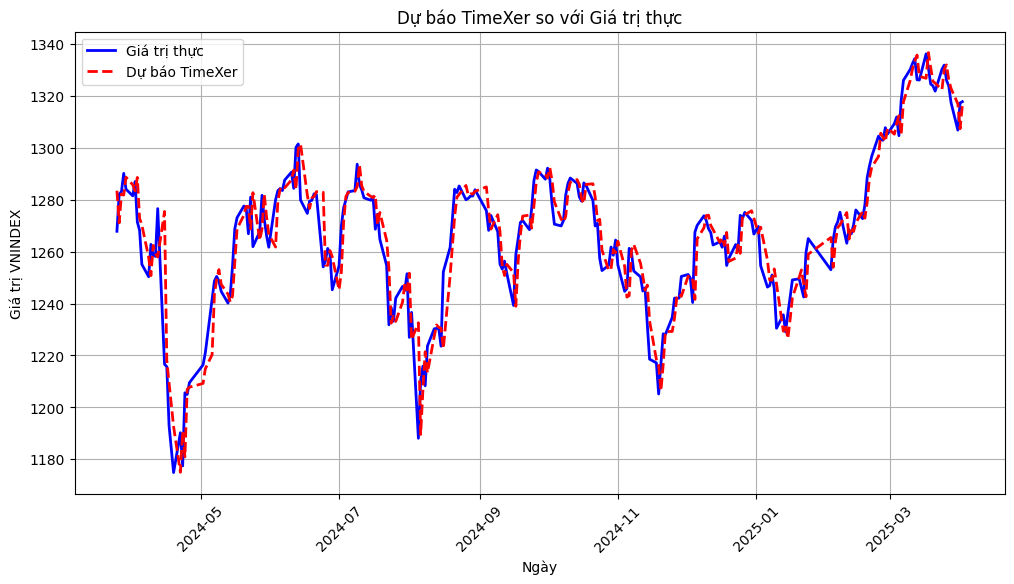

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd



# 1. Biểu đồ đường: Giá trị thực vs Dự báo
plt.figure(figsize=(12, 6))

# Lấy cột ds từ forecasts_final làm trục thời gian
time_axis = forecasts_final['ds'].values

plt.plot(time_axis, Y_true_final, label='Giá trị thực', color='blue', linewidth=2)
plt.plot(time_axis, Y_hat_final, label='Dự báo TimeXer', color='red', linestyle='--', linewidth=2)

plt.xlabel('Ngày')
plt.ylabel('Giá trị VNINDEX')
plt.title('Dự báo TimeXer so với Giá trị thực')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)


# Close, DJ, tỷ giá

In [59]:
df= pd.read_csv(r'D:\DATN\vnindex_with_usd_dji_gold_oil.csv')
df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2556 entries, 0 to 2555
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        2556 non-null   object 
 1   Gold_Close  2556 non-null   float64
 2   Oil_Close   2556 non-null   float64
 3   usd_vnd     2556 non-null   float64
 4   DJI_Close   2556 non-null   float64
 5   OT          2556 non-null   float64
dtypes: float64(5), object(1)
memory usage: 119.9+ KB


In [60]:
# Chuẩn bị dữ liệu theo định dạng NeuralForecast
df['unique_id'] = 'VNINDEX'
df = df.rename(columns={'date': 'ds','OT': 'y' })  # Chuyển 'date' thành 'ds'
df['ds'] = pd.to_datetime(df['ds'])  # Chuyển sang datetime
df = df[['unique_id', 'ds', 'y', 'DJI_Close']]  # Đổi OT thành y

# # Đảm bảo dữ liệu liên tục
#df = df.set_index('ds').asfreq('D', method='ffill').reset_index()

# Xác định kích thước các tập
train_size = int(len(df) * 0.7)  # 70% cho train
val_len = int(len(df) * 0.2)    # 20% cho validation
test_len = len(df) - train_size - val_len  # Phần còn lại cho test

# Chia dữ liệu theo thời gian
train_df = df.iloc[:train_size].reset_index(drop=True)
val_df = df.iloc[train_size:train_size + val_len].reset_index(drop=True)
test_df = df.iloc[train_size + val_len:].reset_index(drop=True)

# Kiểm tra kích thước
print("VNINDEX:")
print(f"Train size: {len(train_df)}")
print(f"Validation size: {len(val_df)}")
print(f"Test size: {len(test_df)}")

VNINDEX:
Train size: 1789
Validation size: 511
Test size: 256


In [61]:
df

,unique_id,ds,y,DJI_Close
0,VNINDEX,2015-01-05,544.45,17501.650391
1,VNINDEX,2015-01-06,549.66,17371.640625
2,VNINDEX,2015-01-07,552.05,17584.519531
3,VNINDEX,2015-01-08,553.47,17907.869141
4,VNINDEX,2015-01-09,569.73,17737.369141
...,...,...,...,...
2551,VNINDEX,2025-03-27,1323.81,42299.699219
2552,VNINDEX,2025-03-28,1317.46,41583.898438
2553,VNINDEX,2025-03-31,1306.86,42001.761719
2554,VNINDEX,2025-04-01,1317.33,41989.960938


## Bayes - 1 bước - Close, DJ


In [6]:
### Bayes
## Bayes
import pandas as pd
import numpy as np
from skopt import gp_minimize, forest_minimize, gbrt_minimize
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from skopt.plots import plot_convergence, plot_objective, plot_evaluations
from neuralforecast import NeuralForecast
from neuralforecast.models import TimeXer
from neuralforecast.losses.pytorch import MAE, MSE, RMSE
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_percentage_error as mape
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
df1=df

In [7]:


horizon = 1

# Định nghĩa không gian tìm kiếm với skopt
dimensions = [
    Integer(low=4, high=36, name='input_size'),
    Categorical(categories=[128, 256], name='hidden_size'),
    Categorical(categories=[4, 8, 16], name='n_heads'),
    Integer(low=1, high=3, name='e_layers'),
    Categorical(categories=[256, 512], name='d_ff'),
    Real(low=0.0, high=0.3, name='dropout'),
    Real(low=1e-5, high=1e-3, prior='log-uniform', name='learning_rate'),
    Categorical(categories=[32, 64], name='batch_size'),
    Integer(low=500, high=1000, name='max_steps'),
    Categorical(categories=['standard', 'robust', 'minmax'], name='scaler_type'),
    # Categorical(categories=[['usd_vnd','DJI_Close','Gold_Close','Oil_Close']], name='futr_exog_list')
]

# Global variables để lưu kết quả
results_history = []
best_score = float('inf')
best_params = None

# Callback function để lưu kết quả trong quá trình optimize
def callback_func(result):
    global results_history, best_score, best_params
    
    current_score = result.func_vals[-1]
    current_params = dict(zip([dim.name for dim in dimensions], result.x_iters[-1]))
    
    results_history.append({
        'iteration': len(result.func_vals),
        'score': current_score,
        **current_params
    })
    
    if current_score < best_score:
        best_score = current_score
        best_params = current_params.copy()
        print(f"New best score: {current_score:.4f} at iteration {len(result.func_vals)}")

@use_named_args(dimensions)
def objective(**params):
    """
    Hàm mục tiêu cho Bayesian Optimization
    """
    try:
        # Tạo mô hình với các siêu tham số
        model = TimeXer(
            h=horizon,
            input_size=params['input_size'],
            n_series=1,
            hidden_size=params['hidden_size'],
            n_heads=params['n_heads'],
            e_layers=params['e_layers'],
            d_ff=params['d_ff'],
            dropout=params['dropout'],
            loss=MAE(),
            valid_loss=MAE(),
            max_steps=params['max_steps'],
            learning_rate=params['learning_rate'],
            scaler_type=params['scaler_type'],
            early_stop_patience_steps=5,
            batch_size=params['batch_size'],
            futr_exog_list= ['DJI_Close']

        )
        
        # Khởi tạo NeuralForecast
        fcst = NeuralForecast(models=[model], freq='B')
        
        # Thực hiện cross validation
        forecasts = fcst.cross_validation(
            df=df1, 
            val_size=val_len, 
            n_windows=None, 
            test_size=test_len - ((test_len - horizon) % horizon), 
            step_size=horizon
        )
        
        # Tính toán MAE
        Y_true = forecasts['y'].values
        Y_hat = forecasts['TimeXer'].values
        MAE_score = mae(Y_true, Y_hat)
        
        print(f"MAE: {MAE_score:.4f} | Params: {params}")
        return MAE_score
        
    except Exception as e:
        print(f"Error in objective function: {e}")
        return 1000.0  # Penalty for failed runs



In [8]:


# Phương pháp 1: Gaussian Process Optimization
print("="*60)
print("PHƯƠNG PHÁP 1: GAUSSIAN PROCESS OPTIMIZATION")
print("="*60)

result_gp = gp_minimize(
    func=objective,
    dimensions=dimensions,
    n_calls=50,  # Số lần gọi hàm objective
    n_initial_points=20,  # Số điểm khởi tạo random
    acq_func='EI',  # Expected Improvement
    random_state=42,
    callback=callback_func
)

print(f"Best GP score: {result_gp.fun:.4f}")
print("Best GP parameters:")
for dim, val in zip(dimensions, result_gp.x):
    print(f"  {dim.name}: {val}")

# # Phương pháp 2: Random Forest Optimization
# print("\n" + "="*60)
# print("PHƯƠNG PHÁP 2: RANDOM FOREST OPTIMIZATION")
# print("="*60)

# results_history = []  # Reset history
# result_rf = forest_minimize(
#     func=objective,
#     dimensions=dimensions,
#     n_calls=50,
#     n_initial_points=10,
#     random_state=42,
#     callback=callback_func
# )

# print(f"Best RF score: {result_rf.fun:.4f}")
# print("Best RF parameters:")
# for dim, val in zip(dimensions, result_rf.x):
#     print(f"  {dim.name}: {val}")

# Phương pháp 3: Gradient Boosted Trees Optimization  
print("\n" + "="*60)
print("PHƯƠNG PHÁP 3: GRADIENT BOOSTED TREES OPTIMIZATION")
print("="*60)

results_history = []  # Reset history
result_gbrt = gbrt_minimize(
    func=objective,
    dimensions=dimensions,
    n_calls=50,
    n_initial_points=20,
    random_state=42,
    callback=callback_func
)

print(f"Best GBRT score: {result_gbrt.fun:.4f}")
print("Best GBRT parameters:")
for dim, val in zip(dimensions, result_gbrt.x):
    print(f"  {dim.name}: {val}")

# So sánh kết quả của 3 phương pháp
print("\n" + "="*60)
print("SO SÁNH KẾT QUẢ")
print("="*60)

methods_comparison = pd.DataFrame({
    'Method': ['Gaussian Process',  'Gradient Boosted Trees'],
    'Best_MAE': [result_gp.fun, result_gbrt.fun],
    'N_calls': [len(result_gp.func_vals),  len(result_gbrt.func_vals)]
})

print(methods_comparison.to_string(index=False))



Seed set to 1


PHƯƠNG PHÁP 1: GAUSSIAN PROCESS OPTIMIZATION


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 3.8 K  | train
6 | encoder      | Encoder                | 397 K  | train
7 | head         | FlattenHead            | 257    | train
----------------------------------------------------------------
404 K     Trainable params
0         Non-trainable params
404 K     Total params
1.616     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=571` reached.
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 1.8 K  | train
6 | encoder      | Encoder                | 791 K  | train
7 | head         | FlattenHead            | 257    | train
----------------------------------------------------------------
797 K     Trainable params
0         Non-trainable params
797 K     Total params
3.191     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


MAE: 11.0091 | Params: {'input_size': 29, 'hidden_size': 128, 'n_heads': 16, 'e_layers': 2, 'd_ff': 256, 'dropout': 0.02999247474540087, 'learning_rate': 8.288916866885136e-05, 'batch_size': 32, 'max_steps': 571, 'scaler_type': 'robust'}
New best score: 11.0091 at iteration 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Error in objective function: maximum size for tensor at dimension 2 is 6 but size is 16



  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 2.3 K  | train
6 | encoder      | Encoder                | 199 K  | train
7 | head         | FlattenHead            | 257    | train
----------------------------------------------------------------
203 K     Trainable params
0         Non-trainable params
203 K     Total params
0.815     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=733` reached.
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


MAE: 7.4475 | Params: {'input_size': 17, 'hidden_size': 128, 'n_heads': 16, 'e_layers': 1, 'd_ff': 256, 'dropout': 0.18551580279992622, 'learning_rate': 5.820013372709849e-05, 'batch_size': 64, 'max_steps': 733, 'scaler_type': 'minmax'}
New best score: 7.4475 at iteration 3



  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 3.5 K  | train
6 | encoder      | Encoder                | 793 K  | train
7 | head         | FlattenHead            | 257    | train
----------------------------------------------------------------
799 K     Trainable params
0         Non-trainable params
799 K     Total params
3.199     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=621` reached.
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1


MAE: 8.7863 | Params: {'input_size': 26, 'hidden_size': 128, 'n_heads': 4, 'e_layers': 3, 'd_ff': 512, 'dropout': 0.11562495076197486, 'learning_rate': 1.0762979285747968e-05, 'batch_size': 32, 'max_steps': 621, 'scaler_type': 'minmax'}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 6.4 K  | train
6 | encoder      | Encoder                | 1.3 M  | train
7 | head         | FlattenHead            | 513    | train
----------------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.323     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=784` reached.
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


MAE: 9.3888 | Params: {'input_size': 24, 'hidden_size': 256, 'n_heads': 4, 'e_layers': 2, 'd_ff': 256, 'dropout': 0.2266084230952958, 'learning_rate': 7.084541505250234e-05, 'batch_size': 32, 'max_steps': 784, 'scaler_type': 'standard'}



  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 4.1 K  | train
6 | encoder      | Encoder                | 793 K  | train
7 | head         | FlattenHead            | 257    | train
----------------------------------------------------------------
800 K     Trainable params
0         Non-trainable params
800 K     Total params
3.202     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=981` reached.
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


MAE: 7.6049 | Params: {'input_size': 31, 'hidden_size': 128, 'n_heads': 8, 'e_layers': 3, 'd_ff': 512, 'dropout': 0.09796223064175062, 'learning_rate': 0.00013832094546570485, 'batch_size': 64, 'max_steps': 981, 'scaler_type': 'minmax'}



  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 7.4 K  | train
6 | encoder      | Encoder                | 2.4 M  | train
7 | head         | FlattenHead            | 513    | train
----------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.541     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=508` reached.
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 2.3 K  | train
6 | encoder      | Encoder                | 264 K  | train
7 | head         | FlattenHead            | 257    | train
----------------------------------------------------------------
269 K     Trainable params
0         Non-trainable params
269 K     Total params
1.078     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


MAE: 11.0768 | Params: {'input_size': 28, 'hidden_size': 256, 'n_heads': 8, 'e_layers': 3, 'd_ff': 512, 'dropout': 0.08279975460676302, 'learning_rate': 3.913334858104373e-05, 'batch_size': 32, 'max_steps': 508, 'scaler_type': 'robust'}


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=826` reached.
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


MAE: 7.5911 | Params: {'input_size': 17, 'hidden_size': 128, 'n_heads': 4, 'e_layers': 1, 'd_ff': 512, 'dropout': 0.23705266215936174, 'learning_rate': 0.00016289957436723494, 'batch_size': 64, 'max_steps': 826, 'scaler_type': 'minmax'}



  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 4.1 K  | train
6 | encoder      | Encoder                | 529 K  | train
7 | head         | FlattenHead            | 257    | train
----------------------------------------------------------------
535 K     Trainable params
0         Non-trainable params
535 K     Total params
2.144     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=781` reached.
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


MAE: 11.1948 | Params: {'input_size': 31, 'hidden_size': 128, 'n_heads': 4, 'e_layers': 2, 'd_ff': 512, 'dropout': 0.19977670698524902, 'learning_rate': 0.00015226341829186323, 'batch_size': 32, 'max_steps': 781, 'scaler_type': 'robust'}



  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 9.2 K  | train
6 | encoder      | Encoder                | 659 K  | train
7 | head         | FlattenHead            | 769    | train
----------------------------------------------------------------
674 K     Trainable params
0         Non-trainable params
674 K     Total params
2.697     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=720` reached.
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 4.4 K  | train
6 | encoder      | Encoder                | 397 K  | train
7 | head         | FlattenHead            | 385    | train
----------------------------------------------------------------
404 K     Trainable params
0         Non-trainable params
404 K     Total params
1.619     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


MAE: 8.8497 | Params: {'input_size': 35, 'hidden_size': 256, 'n_heads': 16, 'e_layers': 1, 'd_ff': 256, 'dropout': 0.012130076861529405, 'learning_rate': 0.0002638309731463534, 'batch_size': 32, 'max_steps': 720, 'scaler_type': 'standard'}


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=971` reached.
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


MAE: 9.3314 | Params: {'input_size': 33, 'hidden_size': 128, 'n_heads': 8, 'e_layers': 2, 'd_ff': 256, 'dropout': 0.1813252137833452, 'learning_rate': 0.00012013849374287183, 'batch_size': 32, 'max_steps': 971, 'scaler_type': 'robust'}



  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 6.9 K  | train
6 | encoder      | Encoder                | 1.3 M  | train
7 | head         | FlattenHead            | 513    | train
----------------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.325     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=942` reached.
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False


MAE: 9.2015 | Params: {'input_size': 26, 'hidden_size': 256, 'n_heads': 8, 'e_layers': 2, 'd_ff': 256, 'dropout': 0.1369603711448731, 'learning_rate': 2.734518553865504e-05, 'batch_size': 32, 'max_steps': 942, 'scaler_type': 'standard'}


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 1.2 K  | train
6 | encoder      | Encoder                | 529 K  | train
7 | head         | FlattenHead            | 129    | train
----------------------------------------------------------------
532 K     Trainable params
0         Non-trainable params
532 K     Total params
2.131     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Seed set to 1


Error in objective function: maximum size for tensor at dimension 2 is 8 but size is 16


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 5.4 K  | train
6 | encoder      | Encoder                | 659 K  | train
7 | head         | FlattenHead            | 513    | train
----------------------------------------------------------------
670 K     Trainable params
0         Non-trainable params
670 K     Total params
2.681     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=532` reached.
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


MAE: 8.2988 | Params: {'input_size': 20, 'hidden_size': 256, 'n_heads': 4, 'e_layers': 1, 'd_ff': 256, 'dropout': 0.06562926587192108, 'learning_rate': 0.0001306784588595592, 'batch_size': 32, 'max_steps': 532, 'scaler_type': 'standard'}



  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 3.3 K  | train
6 | encoder      | Encoder                | 791 K  | train
7 | head         | FlattenHead            | 257    | train
----------------------------------------------------------------
799 K     Trainable params
0         Non-trainable params
799 K     Total params
3.197     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Seed set to 1


Error in objective function: maximum size for tensor at dimension 2 is 12 but size is 16


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 6.4 K  | train
6 | encoder      | Encoder                | 1.6 M  | train
7 | head         | FlattenHead            | 513    | train
----------------------------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.373     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=621` reached.
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


MAE: 8.0322 | Params: {'input_size': 24, 'hidden_size': 256, 'n_heads': 8, 'e_layers': 2, 'd_ff': 512, 'dropout': 0.17780901716381808, 'learning_rate': 1.4511311095238436e-05, 'batch_size': 32, 'max_steps': 621, 'scaler_type': 'minmax'}



  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 5.1 K  | train
6 | encoder      | Encoder                | 2.4 M  | train
7 | head         | FlattenHead            | 513    | train
----------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.531     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=929` reached.
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


MAE: 8.0013 | Params: {'input_size': 19, 'hidden_size': 256, 'n_heads': 8, 'e_layers': 3, 'd_ff': 512, 'dropout': 0.045215263189628846, 'learning_rate': 0.00010384786049124389, 'batch_size': 64, 'max_steps': 929, 'scaler_type': 'standard'}



  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 3.1 K  | train
6 | encoder      | Encoder                | 1.3 M  | train
7 | head         | FlattenHead            | 257    | train
----------------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.308     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Error in objective function: maximum size for tensor at dimension 2 is 11 but size is 16



  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 3.7 K  | train
6 | encoder      | Encoder                | 397 K  | train
7 | head         | FlattenHead            | 257    | train
----------------------------------------------------------------
403 K     Trainable params
0         Non-trainable params
403 K     Total params
1.616     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=630` reached.
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 9.2 K  | train
6 | encoder      | Encoder                | 659 K  | train
7 | head         | FlattenHead            | 769    | train
----------------------------------------------------------------
674 K     Trainable params
0         Non-trainable params
674 K     Total params
2.697     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


MAE: 8.4380 | Params: {'input_size': 28, 'hidden_size': 128, 'n_heads': 8, 'e_layers': 2, 'd_ff': 256, 'dropout': 0.052486478128780864, 'learning_rate': 0.0009211634266628617, 'batch_size': 64, 'max_steps': 630, 'scaler_type': 'minmax'}


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=702` reached.
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

MAE: 9.0850 | Params: {'input_size': 35, 'hidden_size': 256, 'n_heads': 16, 'e_layers': 1, 'd_ff': 256, 'dropout': 0.21010734899183142, 'learning_rate': 0.0004935399178638847, 'batch_size': 64, 'max_steps': 702, 'scaler_type': 'minmax'}


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 2.7 K  | train
6 | encoder      | Encoder                | 397 K  | train
7 | head         | FlattenHead            | 257    | train
----------------------------------------------------------------
402 K     Trainable params
0         Non-trainable params
402 K     Total params
1.612     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=64


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 640    | train
6 | encoder      | Encoder                | 199 K  | train
7 | head         | FlattenHead            | 129    | train
----------------------------------------------------------------
201 K     Trainable params
0         Non-trainable params
201 K     Total params
0.808     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=64


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 4.7 K  | train
6 | encoder      | Encoder                | 199 K  | train
7 | head         | FlattenHead            | 385    | train
----------------------------------------------------------------
206 K     Trainable params
0         Non-trainable params
206 K     Total params
0.825     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=64


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 3.1 K  | train
6 | encoder      | Encoder                | 199 K  | train
7 | head         | FlattenHead            | 257    | train
----------------------------------------------------------------
204 K     Trainable params
0         Non-trainable params
204 K     Total params
0.818     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=32


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 4.1 K  | train
6 | encoder      | Encoder                | 199 K  | train
7 | head         | FlattenHead            | 257    | train
----------------------------------------------------------------
205 K     Trainable params
0         Non-trainable params
205 K     Total params
0.822     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=64


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 2.0 K  | train
6 | encoder      | Encoder                | 2.0 M  | train
7 | head         | FlattenHead            | 257    | train
----------------------------------------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
7.942     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=32


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 3.3 K  | train
6 | encoder      | Encoder                | 264 K  | train
7 | head         | FlattenHead            | 257    | train
----------------------------------------------------------------
270 K     Trainable params
0         Non-trainable params
270 K     Total params
1.082     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=64


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 3.6 K  | train
6 | encoder      | Encoder                | 529 K  | train
7 | head         | FlattenHead            | 257    | train
----------------------------------------------------------------
535 K     Trainable params
0         Non-trainable params
535 K     Total params
2.142     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=32


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 4.4 K  | train
6 | encoder      | Encoder                | 596 K  | train
7 | head         | FlattenHead            | 385    | train
----------------------------------------------------------------
603 K     Trainable params
0         Non-trainable params
603 K     Total params
2.414     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=64


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 4.4 K  | train
6 | encoder      | Encoder                | 264 K  | train
7 | head         | FlattenHead            | 385    | train
----------------------------------------------------------------
271 K     Trainable params
0         Non-trainable params
271 K     Total params
1.087     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=64


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 5.6 K  | train
6 | encoder      | Encoder                | 1.3 M  | train
7 | head         | FlattenHead            | 513    | train
----------------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.320     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=32


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 3.6 K  | train
6 | encoder      | Encoder                | 397 K  | train
7 | head         | FlattenHead            | 257    | train
----------------------------------------------------------------
403 K     Trainable params
0         Non-trainable params
403 K     Total params
1.615     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=32


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 7.7 K  | train
6 | encoder      | Encoder                | 1.6 M  | train
7 | head         | FlattenHead            | 513    | train
----------------------------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.378     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=32


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 6.7 K  | train
6 | encoder      | Encoder                | 1.6 M  | train
7 | head         | FlattenHead            | 513    | train
----------------------------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.374     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=32


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 4.1 K  | train
6 | encoder      | Encoder                | 397 K  | train
7 | head         | FlattenHead            | 257    | train
----------------------------------------------------------------
404 K     Trainable params
0         Non-trainable params
404 K     Total params
1.617     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=32


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 6.4 K  | train
6 | encoder      | Encoder                | 1.6 M  | train
7 | head         | FlattenHead            | 513    | train
----------------------------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.373     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=32


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 4.4 K  | train
6 | encoder      | Encoder                | 199 K  | train
7 | head         | FlattenHead            | 385    | train
----------------------------------------------------------------
205 K     Trainable params
0         Non-trainable params
205 K     Total params
0.824     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=32


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 3.7 K  | train
6 | encoder      | Encoder                | 529 K  | train
7 | head         | FlattenHead            | 257    | train
----------------------------------------------------------------
535 K     Trainable params
0         Non-trainable params
535 K     Total params
2.142     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=64


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 3.8 K  | train
6 | encoder      | Encoder                | 397 K  | train
7 | head         | FlattenHead            | 257    | train
----------------------------------------------------------------
404 K     Trainable params
0         Non-trainable params
404 K     Total params
1.616     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=64


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 6.7 K  | train
6 | encoder      | Encoder                | 1.3 M  | train
7 | head         | FlattenHead            | 513    | train
----------------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.324     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=32


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 4.0 K  | train
6 | encoder      | Encoder                | 397 K  | train
7 | head         | FlattenHead            | 257    | train
----------------------------------------------------------------
404 K     Trainable params
0         Non-trainable params
404 K     Total params
1.617     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=64


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 4.0 K  | train
6 | encoder      | Encoder                | 397 K  | train
7 | head         | FlattenHead            | 257    | train
----------------------------------------------------------------
404 K     Trainable params
0         Non-trainable params
404 K     Total params
1.617     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=32


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 3.8 K  | train
6 | encoder      | Encoder                | 397 K  | train
7 | head         | FlattenHead            | 257    | train
----------------------------------------------------------------
404 K     Trainable params
0         Non-trainable params
404 K     Total params
1.616     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=32


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 6.9 K  | train
6 | encoder      | Encoder                | 1.3 M  | train
7 | head         | FlattenHead            | 513    | train
----------------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.325     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=32


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 3.7 K  | train
6 | encoder      | Encoder                | 793 K  | train
7 | head         | FlattenHead            | 257    | train
----------------------------------------------------------------
800 K     Trainable params
0         Non-trainable params
800 K     Total params
3.201     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=64


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 3.6 K  | train
6 | encoder      | Encoder                | 793 K  | train
7 | head         | FlattenHead            | 257    | train
----------------------------------------------------------------
800 K     Trainable params
0         Non-trainable params
800 K     Total params
3.200     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=64


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 1.5 K  | train
6 | encoder      | Encoder                | 659 K  | train
7 | head         | FlattenHead            | 257    | train
----------------------------------------------------------------
666 K     Trainable params
0         Non-trainable params
666 K     Total params
2.664     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=32


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 1.4 K  | train
6 | encoder      | Encoder                | 264 K  | train
7 | head         | FlattenHead            | 129    | train
----------------------------------------------------------------
268 K     Trainable params
0         Non-trainable params
268 K     Total params
1.074     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=64


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 7.7 K  | train
6 | encoder      | Encoder                | 2.4 M  | train
7 | head         | FlattenHead            | 513    | train
----------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.542     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=32


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 6.9 K  | train
6 | encoder      | Encoder                | 1.6 M  | train
7 | head         | FlattenHead            | 513    | train
----------------------------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.375     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=32


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Best GP score: 7.4475
Best GP parameters:
  input_size: 17
  hidden_size: 128
  n_heads: 16
  e_layers: 1
  d_ff: 256
  dropout: 0.18551580279992622
  learning_rate: 5.820013372709849e-05
  batch_size: 64
  max_steps: 733
  scaler_type: minmax

PHƯƠNG PHÁP 3: GRADIENT BOOSTED TREES OPTIMIZATION



  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 4.4 K  | train
6 | encoder      | Encoder                | 1.3 M  | train
7 | head         | FlattenHead            | 513    | train
----------------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.315     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=801` reached.
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


MAE: 7.1156 | Params: {'input_size': 16, 'hidden_size': 256, 'n_heads': 16, 'e_layers': 2, 'd_ff': 256, 'dropout': 0.0467983561008608, 'learning_rate': 1.3066739238053285e-05, 'batch_size': 64, 'max_steps': 801, 'scaler_type': 'minmax'}
New best score: 7.1156 at iteration 1



  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 1.5 K  | train
6 | encoder      | Encoder                | 659 K  | train
7 | head         | FlattenHead            | 257    | train
----------------------------------------------------------------
666 K     Trainable params
0         Non-trainable params
666 K     Total params
2.664     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Error in objective function: maximum size for tensor at dimension 2 is 5 but size is 16



  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 3.2 K  | train
6 | encoder      | Encoder                | 397 K  | train
7 | head         | FlattenHead            | 257    | train
----------------------------------------------------------------
403 K     Trainable params
0         Non-trainable params
403 K     Total params
1.614     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=796` reached.
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False


MAE: 10.3614 | Params: {'input_size': 24, 'hidden_size': 128, 'n_heads': 4, 'e_layers': 2, 'd_ff': 256, 'dropout': 0.23555278841790414, 'learning_rate': 2.508115686045231e-05, 'batch_size': 64, 'max_steps': 796, 'scaler_type': 'standard'}


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 3.1 K  | train
6 | encoder      | Encoder                | 793 K  | train
7 | head         | FlattenHead            | 257    | train
----------------------------------------------------------------
799 K     Trainable params
0         Non-trainable params
799 K     Total params
3.198     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=842` reached.
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


MAE: 10.4121 | Params: {'input_size': 23, 'hidden_size': 128, 'n_heads': 4, 'e_layers': 3, 'd_ff': 512, 'dropout': 0.2425192044349384, 'learning_rate': 4.066563313514792e-05, 'batch_size': 32, 'max_steps': 842, 'scaler_type': 'robust'}



  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 1.2 K  | train
6 | encoder      | Encoder                | 596 K  | train
7 | head         | FlattenHead            | 129    | train
----------------------------------------------------------------
600 K     Trainable params
0         Non-trainable params
600 K     Total params
2.400     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Error in objective function: maximum size for tensor at dimension 2 is 8 but size is 16



  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 9.2 K  | train
6 | encoder      | Encoder                | 2.4 M  | train
7 | head         | FlattenHead            | 769    | train
----------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.549     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=523` reached.
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


MAE: 11.2118 | Params: {'input_size': 35, 'hidden_size': 256, 'n_heads': 16, 'e_layers': 3, 'd_ff': 512, 'dropout': 0.2765622705069351, 'learning_rate': 1.5030900645056825e-05, 'batch_size': 32, 'max_steps': 523, 'scaler_type': 'standard'}



  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 2.2 K  | train
6 | encoder      | Encoder                | 397 K  | train
7 | head         | FlattenHead            | 257    | train
----------------------------------------------------------------
402 K     Trainable params
0         Non-trainable params
402 K     Total params
1.610     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=537` reached.
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1


MAE: 7.6839 | Params: {'input_size': 16, 'hidden_size': 128, 'n_heads': 16, 'e_layers': 2, 'd_ff': 256, 'dropout': 0.16280882494747456, 'learning_rate': 1.9135880487692317e-05, 'batch_size': 64, 'max_steps': 537, 'scaler_type': 'minmax'}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 3.8 K  | train
6 | encoder      | Encoder                | 793 K  | train
7 | head         | FlattenHead            | 257    | train
----------------------------------------------------------------
800 K     Trainable params
0         Non-trainable params
800 K     Total params
3.201     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=679` reached.
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


MAE: 8.4933 | Params: {'input_size': 29, 'hidden_size': 128, 'n_heads': 4, 'e_layers': 3, 'd_ff': 512, 'dropout': 0.2187021504122962, 'learning_rate': 0.0003487712624545935, 'batch_size': 32, 'max_steps': 679, 'scaler_type': 'standard'}



  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 8.4 K  | train
6 | encoder      | Encoder                | 659 K  | train
7 | head         | FlattenHead            | 769    | train
----------------------------------------------------------------
673 K     Trainable params
0         Non-trainable params
673 K     Total params
2.694     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=944` reached.
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


MAE: 7.9554 | Params: {'input_size': 32, 'hidden_size': 256, 'n_heads': 4, 'e_layers': 1, 'd_ff': 256, 'dropout': 0.09755499660802412, 'learning_rate': 0.0002878805718308926, 'batch_size': 64, 'max_steps': 944, 'scaler_type': 'robust'}



  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 2.3 K  | train
6 | encoder      | Encoder                | 1.6 M  | train
7 | head         | FlattenHead            | 257    | train
----------------------------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.356     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Error in objective function: maximum size for tensor at dimension 2 is 8 but size is 16



  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 1.5 K  | train
6 | encoder      | Encoder                | 1.6 M  | train
7 | head         | FlattenHead            | 257    | train
----------------------------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.353     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Error in objective function: maximum size for tensor at dimension 2 is 5 but size is 16



  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 1.8 K  | train
6 | encoder      | Encoder                | 793 K  | train
7 | head         | FlattenHead            | 129    | train
----------------------------------------------------------------
798 K     Trainable params
0         Non-trainable params
798 K     Total params
3.192     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Error in objective function: maximum size for tensor at dimension 2 is 13 but size is 16



  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 7.9 K  | train
6 | encoder      | Encoder                | 659 K  | train
7 | head         | FlattenHead            | 513    | train
----------------------------------------------------------------
672 K     Trainable params
0         Non-trainable params
672 K     Total params
2.691     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=503` reached.
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False


MAE: 11.6065 | Params: {'input_size': 30, 'hidden_size': 256, 'n_heads': 4, 'e_layers': 1, 'd_ff': 256, 'dropout': 0.12813233658787693, 'learning_rate': 0.0004325432427964557, 'batch_size': 64, 'max_steps': 503, 'scaler_type': 'robust'}


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 2.3 K  | train
6 | encoder      | Encoder                | 529 K  | train
7 | head         | FlattenHead            | 257    | train
----------------------------------------------------------------
534 K     Trainable params
0         Non-trainable params
534 K     Total params
2.137     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=682` reached.
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False


MAE: 7.2559 | Params: {'input_size': 17, 'hidden_size': 128, 'n_heads': 4, 'e_layers': 2, 'd_ff': 512, 'dropout': 0.09696087960622658, 'learning_rate': 0.00010903884523201114, 'batch_size': 64, 'max_steps': 682, 'scaler_type': 'minmax'}


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 4.6 K  | train
6 | encoder      | Encoder                | 397 K  | train
7 | head         | FlattenHead            | 385    | train
----------------------------------------------------------------
404 K     Trainable params
0         Non-trainable params
404 K     Total params
1.620     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=526` reached.
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False


MAE: 8.8465 | Params: {'input_size': 35, 'hidden_size': 128, 'n_heads': 8, 'e_layers': 2, 'd_ff': 256, 'dropout': 0.011066084206359841, 'learning_rate': 0.00016562605893335948, 'batch_size': 64, 'max_steps': 526, 'scaler_type': 'standard'}


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 4.4 K  | train
6 | encoder      | Encoder                | 529 K  | train
7 | head         | FlattenHead            | 385    | train
----------------------------------------------------------------
536 K     Trainable params
0         Non-trainable params
536 K     Total params
2.145     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=619` reached.
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False


MAE: 7.9386 | Params: {'input_size': 33, 'hidden_size': 128, 'n_heads': 4, 'e_layers': 2, 'd_ff': 512, 'dropout': 0.07261658145345014, 'learning_rate': 0.00022093834415066294, 'batch_size': 64, 'max_steps': 619, 'scaler_type': 'minmax'}


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 4.4 K  | train
6 | encoder      | Encoder                | 1.3 M  | train
7 | head         | FlattenHead            | 513    | train
----------------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.315     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=520` reached.
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False


MAE: 7.4695 | Params: {'input_size': 16, 'hidden_size': 256, 'n_heads': 8, 'e_layers': 2, 'd_ff': 256, 'dropout': 0.25059074867677145, 'learning_rate': 4.380867619725791e-05, 'batch_size': 32, 'max_steps': 520, 'scaler_type': 'robust'}


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 3.5 K  | train
6 | encoder      | Encoder                | 264 K  | train
7 | head         | FlattenHead            | 257    | train
----------------------------------------------------------------
270 K     Trainable params
0         Non-trainable params
270 K     Total params
1.083     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=968` reached.
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False


MAE: 8.8588 | Params: {'input_size': 26, 'hidden_size': 128, 'n_heads': 8, 'e_layers': 1, 'd_ff': 512, 'dropout': 0.05230992870149744, 'learning_rate': 0.00024092145436664783, 'batch_size': 32, 'max_steps': 968, 'scaler_type': 'standard'}


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 2.0 K  | train
6 | encoder      | Encoder                | 596 K  | train
7 | head         | FlattenHead            | 129    | train
----------------------------------------------------------------
600 K     Trainable params
0         Non-trainable params
600 K     Total params
2.404     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Seed set to 1


Error in objective function: maximum size for tensor at dimension 2 is 15 but size is 16


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 2.0 K  | train
6 | encoder      | Encoder                | 1.3 M  | train
7 | head         | FlattenHead            | 257    | train
----------------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.304     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: maximum size for tensor at dimension 2 is 7 but size is 16


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 2.8 K  | train
6 | encoder      | Encoder                | 264 K  | train
7 | head         | FlattenHead            | 257    | train
----------------------------------------------------------------
270 K     Trainable params
0         Non-trainable params
270 K     Total params
1.080     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=32


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 2.2 K  | train
6 | encoder      | Encoder                | 264 K  | train
7 | head         | FlattenHead            | 257    | train
----------------------------------------------------------------
269 K     Trainable params
0         Non-trainable params
269 K     Total params
1.078     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=32


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 2.4 K  | train
6 | encoder      | Encoder                | 199 K  | train
7 | head         | FlattenHead            | 257    | train
----------------------------------------------------------------
203 K     Trainable params
0         Non-trainable params
203 K     Total params
0.816     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=32


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 7.7 K  | train
6 | encoder      | Encoder                | 1.6 M  | train
7 | head         | FlattenHead            | 513    | train
----------------------------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.378     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=32


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 9.2 K  | train
6 | encoder      | Encoder                | 1.3 M  | train
7 | head         | FlattenHead            | 769    | train
----------------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.335     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=64


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 4.1 K  | train
6 | encoder      | Encoder                | 1.3 M  | train
7 | head         | FlattenHead            | 257    | train
----------------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.313     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=32


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 6.7 K  | train
6 | encoder      | Encoder                | 791 K  | train
7 | head         | FlattenHead            | 513    | train
----------------------------------------------------------------
802 K     Trainable params
0         Non-trainable params
802 K     Total params
3.211     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=64


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 7.4 K  | train
6 | encoder      | Encoder                | 659 K  | train
7 | head         | FlattenHead            | 513    | train
----------------------------------------------------------------
672 K     Trainable params
0         Non-trainable params
672 K     Total params
2.689     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=64


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 4.0 K  | train
6 | encoder      | Encoder                | 264 K  | train
7 | head         | FlattenHead            | 257    | train
----------------------------------------------------------------
271 K     Trainable params
0         Non-trainable params
271 K     Total params
1.085     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=32


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 7.9 K  | train
6 | encoder      | Encoder                | 659 K  | train
7 | head         | FlattenHead            | 513    | train
----------------------------------------------------------------
672 K     Trainable params
0         Non-trainable params
672 K     Total params
2.691     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=32


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 4.2 K  | train
6 | encoder      | Encoder                | 264 K  | train
7 | head         | FlattenHead            | 385    | train
----------------------------------------------------------------
271 K     Trainable params
0         Non-trainable params
271 K     Total params
1.086     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=64


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 9.0 K  | train
6 | encoder      | Encoder                | 2.0 M  | train
7 | head         | FlattenHead            | 769    | train
----------------------------------------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
7.972     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=64


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 4.0 K  | train
6 | encoder      | Encoder                | 793 K  | train
7 | head         | FlattenHead            | 257    | train
----------------------------------------------------------------
800 K     Trainable params
0         Non-trainable params
800 K     Total params
3.202     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=64


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 3.7 K  | train
6 | encoder      | Encoder                | 596 K  | train
7 | head         | FlattenHead            | 257    | train
----------------------------------------------------------------
602 K     Trainable params
0         Non-trainable params
602 K     Total params
2.411     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=64


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 4.6 K  | train
6 | encoder      | Encoder                | 1.6 M  | train
7 | head         | FlattenHead            | 513    | train
----------------------------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.366     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=64


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 5.6 K  | train
6 | encoder      | Encoder                | 1.3 M  | train
7 | head         | FlattenHead            | 513    | train
----------------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.320     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=32


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 4.4 K  | train
6 | encoder      | Encoder                | 199 K  | train
7 | head         | FlattenHead            | 385    | train
----------------------------------------------------------------
205 K     Trainable params
0         Non-trainable params
205 K     Total params
0.824     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=64


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 2.3 K  | train
6 | encoder      | Encoder                | 199 K  | train
7 | head         | FlattenHead            | 257    | train
----------------------------------------------------------------
203 K     Trainable params
0         Non-trainable params
203 K     Total params
0.815     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=64


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 4.5 K  | train
6 | encoder      | Encoder                | 264 K  | train
7 | head         | FlattenHead            | 385    | train
----------------------------------------------------------------
271 K     Trainable params
0         Non-trainable params
271 K     Total params
1.087     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=64


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 4.4 K  | train
6 | encoder      | Encoder                | 2.0 M  | train
7 | head         | FlattenHead            | 513    | train
----------------------------------------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
7.952     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=32


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 6.1 K  | train
6 | encoder      | Encoder                | 1.3 M  | train
7 | head         | FlattenHead            | 513    | train
----------------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.322     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=64


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 2.9 K  | train
6 | encoder      | Encoder                | 529 K  | train
7 | head         | FlattenHead            | 257    | train
----------------------------------------------------------------
534 K     Trainable params
0         Non-trainable params
534 K     Total params
2.139     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=64


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 8.4 K  | train
6 | encoder      | Encoder                | 1.3 M  | train
7 | head         | FlattenHead            | 769    | train
----------------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.332     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=32


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 2.2 K  | train
6 | encoder      | Encoder                | 529 K  | train
7 | head         | FlattenHead            | 257    | train
----------------------------------------------------------------
534 K     Trainable params
0         Non-trainable params
534 K     Total params
2.136     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=64


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 4.1 K  | train
6 | encoder      | Encoder                | 793 K  | train
7 | head         | FlattenHead            | 257    | train
----------------------------------------------------------------
800 K     Trainable params
0         Non-trainable params
800 K     Total params
3.202     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=32


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 9.2 K  | train
6 | encoder      | Encoder                | 1.6 M  | train
7 | head         | FlattenHead            | 769    | train
----------------------------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.386     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=64


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 6.4 K  | train
6 | encoder      | Encoder                | 791 K  | train
7 | head         | FlattenHead            | 513    | train
----------------------------------------------------------------
802 K     Trainable params
0         Non-trainable params
802 K     Total params
3.210     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=64


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 4.0 K  | train
6 | encoder      | Encoder                | 397 K  | train
7 | head         | FlattenHead            | 257    | train
----------------------------------------------------------------
404 K     Trainable params
0         Non-trainable params
404 K     Total params
1.617     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=32


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 5.4 K  | train
6 | encoder      | Encoder                | 1.3 M  | train
7 | head         | FlattenHead            | 513    | train
----------------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.319     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=32


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 4.7 K  | train
6 | encoder      | Encoder                | 199 K  | train
7 | head         | FlattenHead            | 385    | train
----------------------------------------------------------------
206 K     Trainable params
0         Non-trainable params
206 K     Total params
0.825     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=32
Best GBRT score: 7.1156
Best GBRT parameters:
  input_size: 16
  hidden_size: 256
  n_heads: 16
  e_layers: 2
  d_ff: 256
  dropout: 0.0467983561008608
  learning_rate: 1.3066739238053285e-05
  batch_size: 64
  max_steps: 801
  scaler_type: minmax

SO SÁNH KẾT QUẢ
                Method  Best_MAE  N_calls
      Gaussian Process  7.447511       50
Gradient Boosted Trees  7.115563       50


In [9]:
# So sánh kết quả của 3 phương pháp
print("\n" + "="*60)
print("SO SÁNH KẾT QUẢ")
print("="*60)

methods_comparison = pd.DataFrame({
    'Method': ['Gaussian Process',  'Gradient Boosted Trees'],
    'Best_MAE': [result_gp.fun, result_gbrt.fun],
    'N_calls': [len(result_gp.func_vals),  len(result_gbrt.func_vals)]
})

print(methods_comparison.to_string(index=False))


SO SÁNH KẾT QUẢ
                Method  Best_MAE  N_calls
      Gaussian Process  7.447511       50
Gradient Boosted Trees  7.115563       50


In [ ]:

# Chọn phương pháp tốt nhất
best_method_idx = methods_comparison['Best_MAE'].idxmin()
best_method = methods_comparison.iloc[best_method_idx]['Method']
best_result = [result_gp, result_gbrt][best_method_idx]

print(f"\nPhương pháp tốt nhất: {best_method}")
print(f"Điểm số tốt nhất: {best_result.fun:.4f}")

In [ ]:

# Huấn luyện mô hình cuối cùng với tham số tốt nhất
print("\n" + "="*60)
print("HUẤN LUYỆN MÔ HÌNH CUỐI CÙNG")
print("="*60)

final_params = dict(zip([dim.name for dim in dimensions], best_result.x))
final_model = TimeXer(
    h=horizon,
    input_size=final_params['input_size'],
    n_series=1,
    hidden_size=final_params['hidden_size'],
    n_heads=final_params['n_heads'],
    e_layers=final_params['e_layers'],
    d_ff=final_params['d_ff'],
    dropout=final_params['dropout'],
    loss=MAE(),
    valid_loss=MAE(),
    max_steps=final_params['max_steps'],
    learning_rate=final_params['learning_rate'],
    scaler_type=final_params['scaler_type'],
    early_stop_patience_steps=5,
    batch_size=final_params['batch_size'],
    futr_exog_list= ['DJI_Close'] 


)

fcst_final = NeuralForecast(models=[final_model], freq='B')
forecasts_final = fcst_final.cross_validation(
    df=df1, 
    val_size=val_len, 
    n_windows=None, 
    test_size=test_len - ((test_len - horizon) % horizon), 
    step_size=horizon
)


# Tính toán metrics cuối cùng
Y_true_final = forecasts_final['y'].values
Y_hat_final = forecasts_final['TimeXer'].values

MAE_final = mae(Y_true_final, Y_hat_final)
MAPE_final = mape(Y_true_final, Y_hat_final) * 100
RMSE_final = np.sqrt(mse(Y_true_final, Y_hat_final))

# Kết quả cuối cùng
df_final_results = pd.DataFrame({
    'Model': [f"TimeXer_{best_method.replace(' ', '_')}"],
    'Horizon': [str(horizon)],
    'Data': ["VNINDEX"],
    'MAE': [MAE_final],
    'RMSE': [RMSE_final],
    'MAPE': [MAPE_final]
})

print("\nKẾT QUẢ CUỐI CÙNG:")
print(df_final_results.to_string(index=False))

# Lưu kết quả
results_df = pd.DataFrame({
    'GP_MAE': result_gp.func_vals,
    'GBRT_MAE': result_gbrt.func_vals
})



# Hiển thị tóm tắt
print("\n" + "="*60)
print("TÓM TẮT")
print("="*60)
print(f"Phương pháp tốt nhất: {best_method}")
print(f"MAE tốt nhất: {best_result.fun:.4f}")
print(f"Số lần gọi hàm: {len(best_result.func_vals)}")
print("\nTham số tối ưu:")
for dim, val in zip(dimensions, best_result.x):
    print(f"  {dim.name}: {val}")

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



HUẤN LUYỆN MÔ HÌNH CUỐI CÙNG



  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 4.4 K  | train
6 | encoder      | Encoder                | 1.3 M  | train
7 | head         | FlattenHead            | 513    | train
----------------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.315     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=801` reached.
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]


KẾT QUẢ CUỐI CÙNG:
                         Model Horizon    Data      MAE     RMSE     MAPE
TimeXer_Gradient_Boosted_Trees       1 VNINDEX 7.115563 9.843223 0.566413

TÓM TẮT
Phương pháp tốt nhất: Gradient Boosted Trees
MAE tốt nhất: 7.1156
Số lần gọi hàm: 50

Tham số tối ưu:
  input_size: 16
  hidden_size: 256
  n_heads: 16
  e_layers: 2
  d_ff: 256
  dropout: 0.0467983561008608
  learning_rate: 1.3066739238053285e-05
  batch_size: 64
  max_steps: 801
  scaler_type: minmax


In [ ]:

# Huấn luyện mô hình cuối cùng với tham số tốt nhất
print("\n" + "="*60)
print("HUẤN LUYỆN MÔ HÌNH CUỐI CÙNG")
print("="*60)

final_params = dict(zip([dim.name for dim in dimensions], best_result.x))
final_model = TimeXer(
    h=1,
    input_size=16,
    n_series=1,
    hidden_size=256,
    n_heads=16,
    e_layers=final_params['e_layers'],
    d_ff=final_params['d_ff'],
    dropout=final_params['dropout'],
    loss=MAE(),
    valid_loss=MAE(),
    max_steps=final_params['max_steps'],
    learning_rate=final_params['learning_rate'],
    scaler_type=final_params['scaler_type'],
    early_stop_patience_steps=5,
    batch_size=final_params['batch_size'],
    futr_exog_list= ['DJI_Close'] 


)

fcst_final = NeuralForecast(models=[final_model], freq='B')
forecasts_final = fcst_final.cross_validation(
    df=df1, 
    val_size=val_len, 
    n_windows=None, 
    test_size=test_len - ((test_len - horizon) % horizon), 
    step_size=horizon
)


# Tính toán metrics cuối cùng
Y_true_final = forecasts_final['y'].values
Y_hat_final = forecasts_final['TimeXer'].values

MAE_final = mae(Y_true_final, Y_hat_final)
MAPE_final = mape(Y_true_final, Y_hat_final) * 100
RMSE_final = np.sqrt(mse(Y_true_final, Y_hat_final))

# Kết quả cuối cùng
df_final_results = pd.DataFrame({
    'Model': [f"TimeXer_{best_method.replace(' ', '_')}"],
    'Horizon': [str(horizon)],
    'Data': ["VNINDEX"],
    'MAE': [MAE_final],
    'RMSE': [RMSE_final],
    'MAPE': [MAPE_final]
})

print("\nKẾT QUẢ CUỐI CÙNG:")
print(df_final_results.to_string(index=False))

# Lưu kết quả
results_df = pd.DataFrame({
    'GP_MAE': result_gp.func_vals,
    'GBRT_MAE': result_gbrt.func_vals
})



# Hiển thị tóm tắt
print("\n" + "="*60)
print("TÓM TẮT")
print("="*60)
print(f"Phương pháp tốt nhất: {best_method}")
print(f"MAE tốt nhất: {best_result.fun:.4f}")
print(f"Số lần gọi hàm: {len(best_result.func_vals)}")
print("\nTham số tối ưu:")
for dim, val in zip(dimensions, best_result.x):
    print(f"  {dim.name}: {val}")

(array([19844., 19905., 19967., 20028., 20089., 20148.]),
 [Text(19844.0, 0, '2024-05'),
  Text(19905.0, 0, '2024-07'),
  Text(19967.0, 0, '2024-09'),
  Text(20028.0, 0, '2024-11'),
  Text(20089.0, 0, '2025-01'),
  Text(20148.0, 0, '2025-03')])

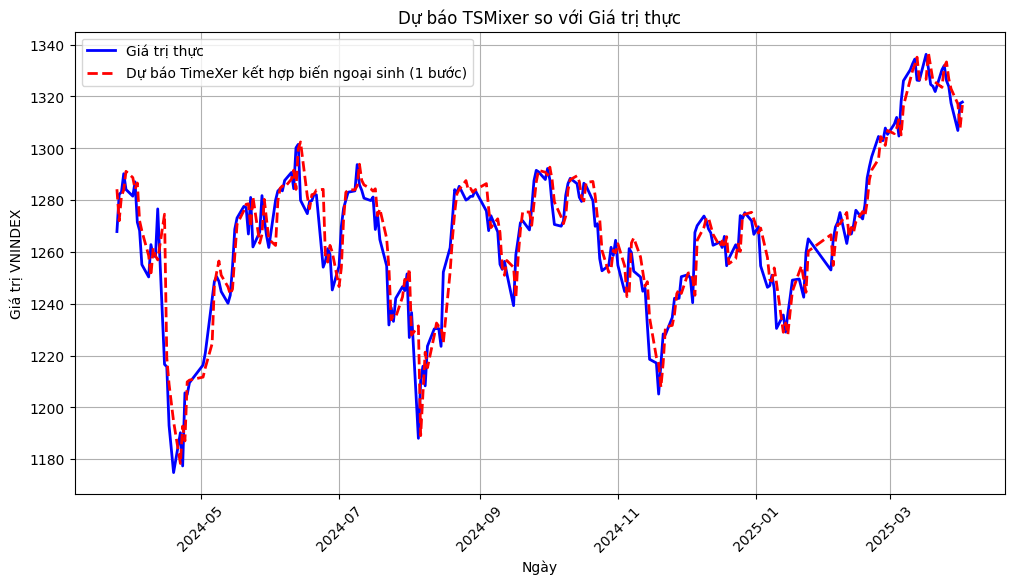

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd



# 1. Biểu đồ đường: Giá trị thực vs Dự báo
plt.figure(figsize=(12, 6))

# Lấy cột ds từ forecasts_final làm trục thời gian
time_axis = forecasts_final['ds'].values

plt.plot(time_axis, Y_true_final, label='Giá trị thực', color='blue', linewidth=2)
plt.plot(time_axis, Y_hat_final, label='Dự báo TimeXer kết hợp biến ngoại sinh (1 bước)', color='red', linestyle='--', linewidth=2)

plt.xlabel('Ngày')
plt.ylabel('Giá trị VNINDEX')
plt.title('Dự báo TimeXer so với Giá trị thực')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)


## Bayes - 20 bước - Close, DJ, Tỷ giá


In [7]:
### Bayes
## Bayes
import pandas as pd
import numpy as np
from skopt import gp_minimize, forest_minimize, gbrt_minimize
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from skopt.plots import plot_convergence, plot_objective, plot_evaluations
from neuralforecast import NeuralForecast
from neuralforecast.models import TimeXer
from neuralforecast.losses.pytorch import MAE, MSE, RMSE
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_percentage_error as mape
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


In [8]:


horizon = 20

# Định nghĩa không gian tìm kiếm với skopt
dimensions = [
    Integer(low=40, high=80, name='input_size'),
    Categorical(categories=[128, 256], name='hidden_size'),
    Categorical(categories=[8, 16], name='n_heads'),
    Integer(low=1, high=3, name='e_layers'),
    Categorical(categories=[256, 512], name='d_ff'),
    Real(low=0.0, high=0.3, name='dropout'),
    Real(low=1e-5, high=1e-3, prior='log-uniform', name='learning_rate'),
    Categorical(categories=[32, 64,128], name='batch_size'),
    Integer(low=500, high=1000, name='max_steps'),
    Categorical(categories=['standard', 'robust', 'minmax'], name='scaler_type'),
    
]

# Global variables để lưu kết quả
results_history = []
best_score = float('inf')
best_params = None

# Callback function để lưu kết quả trong quá trình optimize
def callback_func(result):
    global results_history, best_score, best_params
    
    current_score = result.func_vals[-1]
    current_params = dict(zip([dim.name for dim in dimensions], result.x_iters[-1]))
    
    results_history.append({
        'iteration': len(result.func_vals),
        'score': current_score,
        **current_params
    })
    
    if current_score < best_score:
        best_score = current_score
        best_params = current_params.copy()
        print(f"New best score: {current_score:.4f} at iteration {len(result.func_vals)}")

@use_named_args(dimensions)
def objective(**params):
    """
    Hàm mục tiêu cho Bayesian Optimization
    """
    try:
        # Tạo mô hình với các siêu tham số
        model = TimeXer(
            h=horizon,
            input_size=params['input_size'],
            n_series=1,
            hidden_size=params['hidden_size'],
            n_heads=params['n_heads'],
            e_layers=params['e_layers'],
            d_ff=params['d_ff'],
            dropout=params['dropout'],
            loss=MAE(),
            valid_loss=MAE(),
            max_steps=params['max_steps'],
            learning_rate=params['learning_rate'],
            scaler_type=params['scaler_type'],
            early_stop_patience_steps=5,
            batch_size=params['batch_size'],
            futr_exog_list= ['usd_vnd','DJI_Close']

        )
        
        # Khởi tạo NeuralForecast
        fcst = NeuralForecast(models=[model], freq='B')
        
        # Thực hiện cross validation
        forecasts = fcst.cross_validation(
            df=df, 
            val_size=val_len, 
            n_windows=None, 
            test_size=test_len - ((test_len - horizon) % horizon), 
            step_size=horizon
        )
        
        # Tính toán MAE
        Y_true = forecasts['y'].values
        Y_hat = forecasts['TimeXer'].values
        MAE_score = mae(Y_true, Y_hat)
        
        print(f"MAE: {MAE_score:.4f} | Params: {params}")
        return MAE_score
        
    except Exception as e:
        print(f"Error in objective function: {e}")
        return 1000.0  # Penalty for failed runs



In [9]:


# Phương pháp 1: Gaussian Process Optimization
print("="*60)
print("PHƯƠNG PHÁP 1: GAUSSIAN PROCESS OPTIMIZATION")
print("="*60)

result_gp = gp_minimize(
    func=objective,
    dimensions=dimensions,
    n_calls=50,  # Số lần gọi hàm objective
    n_initial_points=10,  # Số điểm khởi tạo random
    acq_func='EI',  # Expected Improvement
    random_state=42,
    callback=callback_func
)

print(f"Best GP score: {result_gp.fun:.4f}")
print("Best GP parameters:")
for dim, val in zip(dimensions, result_gp.x):
    print(f"  {dim.name}: {val}")

# # Phương pháp 2: Random Forest Optimization
# print("\n" + "="*60)
# print("PHƯƠNG PHÁP 2: RANDOM FOREST OPTIMIZATION")
# print("="*60)

# results_history = []  # Reset history
# result_rf = forest_minimize(
#     func=objective,
#     dimensions=dimensions,
#     n_calls=50,
#     n_initial_points=10,
#     random_state=42,
#     callback=callback_func
# )

# print(f"Best RF score: {result_rf.fun:.4f}")
# print("Best RF parameters:")
# for dim, val in zip(dimensions, result_rf.x):
#     print(f"  {dim.name}: {val}")

# Phương pháp 3: Gradient Boosted Trees Optimization  
print("\n" + "="*60)
print("PHƯƠNG PHÁP 3: GRADIENT BOOSTED TREES OPTIMIZATION")
print("="*60)

results_history = []  # Reset history
result_gbrt = gbrt_minimize(
    func=objective,
    dimensions=dimensions,
    n_calls=50,
    n_initial_points=10,
    random_state=42,
    callback=callback_func
)

print(f"Best GBRT score: {result_gbrt.fun:.4f}")
print("Best GBRT parameters:")
for dim, val in zip(dimensions, result_gbrt.x):
    print(f"  {dim.name}: {val}")

# So sánh kết quả của 3 phương pháp
print("\n" + "="*60)
print("SO SÁNH KẾT QUẢ")
print("="*60)

methods_comparison = pd.DataFrame({
    'Method': ['Gaussian Process',  'Gradient Boosted Trees'],
    'Best_MAE': [result_gp.fun,  result_gbrt.fun],
    'N_calls': [len(result_gp.func_vals),  len(result_gbrt.func_vals)]
})

print(methods_comparison.to_string(index=False))



Seed set to 1


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 9.3 K  | train
6 | encoder      | Encoder                | 397 K  | train
7 | head         | FlattenHead            | 12.8 K | train
----------------------------------------------------------------
422 K     Trainable params
0         Non-trainable params
422 K     Total params
1.689     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


PHƯƠNG PHÁP 1: GAUSSIAN PROCESS OPTIMIZATION


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=571` reached.
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 11.0 K | train
6 | encoder      | Encoder                | 791 K  | train
7 | head         | FlattenHead            | 15.4 K | train
----------------------------------------------------------------
822 K     Trainable params
0         Non-trainable params
822 K     Total params
3.288     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


MAE: 20.2312 | Params: {'input_size': 72, 'hidden_size': 128, 'n_heads': 16, 'e_layers': 2, 'd_ff': 256, 'dropout': 0.02999247474540087, 'learning_rate': 8.288916866885136e-05, 'batch_size': 64, 'max_steps': 571, 'scaler_type': 'robust'}
New best score: 20.2312 at iteration 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=512` reached.
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1


MAE: 25.7839 | Params: {'input_size': 42, 'hidden_size': 256, 'n_heads': 16, 'e_layers': 1, 'd_ff': 512, 'dropout': 0.18524445288831498, 'learning_rate': 0.00016722697006183674, 'batch_size': 32, 'max_steps': 512, 'scaler_type': 'robust'}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 7.3 K  | train
6 | encoder      | Encoder                | 199 K  | train
7 | head         | FlattenHead            | 10.3 K | train
----------------------------------------------------------------
218 K     Trainable params
0         Non-trainable params
218 K     Total params
0.875     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=733` reached.
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


MAE: 22.7055 | Params: {'input_size': 56, 'hidden_size': 128, 'n_heads': 16, 'e_layers': 1, 'd_ff': 256, 'dropout': 0.18551580279992622, 'learning_rate': 5.820013372709849e-05, 'batch_size': 128, 'max_steps': 733, 'scaler_type': 'minmax'}



  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 8.7 K  | train
6 | encoder      | Encoder                | 793 K  | train
7 | head         | FlattenHead            | 12.8 K | train
----------------------------------------------------------------
817 K     Trainable params
0         Non-trainable params
817 K     Total params
3.271     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=621` reached.
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


MAE: 28.9102 | Params: {'input_size': 67, 'hidden_size': 128, 'n_heads': 8, 'e_layers': 3, 'd_ff': 512, 'dropout': 0.11562495076197486, 'learning_rate': 1.0762979285747968e-05, 'batch_size': 32, 'max_steps': 621, 'scaler_type': 'minmax'}



  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 16.6 K | train
6 | encoder      | Encoder                | 1.3 M  | train
7 | head         | FlattenHead            | 25.6 K | train
----------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.464     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=784` reached.
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


MAE: 22.9215 | Params: {'input_size': 64, 'hidden_size': 256, 'n_heads': 8, 'e_layers': 2, 'd_ff': 256, 'dropout': 0.2266084230952958, 'learning_rate': 7.084541505250234e-05, 'batch_size': 32, 'max_steps': 784, 'scaler_type': 'standard'}



  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 9.6 K  | train
6 | encoder      | Encoder                | 793 K  | train
7 | head         | FlattenHead            | 12.8 K | train
----------------------------------------------------------------
818 K     Trainable params
0         Non-trainable params
818 K     Total params
3.274     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=981` reached.
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


MAE: 24.2386 | Params: {'input_size': 74, 'hidden_size': 128, 'n_heads': 8, 'e_layers': 3, 'd_ff': 512, 'dropout': 0.09796223064175062, 'learning_rate': 0.00013832094546570485, 'batch_size': 64, 'max_steps': 981, 'scaler_type': 'minmax'}



  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 18.2 K | train
6 | encoder      | Encoder                | 2.4 M  | train
7 | head         | FlattenHead            | 25.6 K | train
----------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.684     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=508` reached.
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


MAE: 22.4814 | Params: {'input_size': 70, 'hidden_size': 256, 'n_heads': 16, 'e_layers': 3, 'd_ff': 512, 'dropout': 0.08279975460676302, 'learning_rate': 3.913334858104373e-05, 'batch_size': 32, 'max_steps': 508, 'scaler_type': 'robust'}



  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 7.3 K  | train
6 | encoder      | Encoder                | 264 K  | train
7 | head         | FlattenHead            | 10.3 K | train
----------------------------------------------------------------
284 K     Trainable params
0         Non-trainable params
284 K     Total params
1.138     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=826` reached.
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


MAE: 22.3259 | Params: {'input_size': 56, 'hidden_size': 128, 'n_heads': 8, 'e_layers': 1, 'd_ff': 512, 'dropout': 0.23705266215936174, 'learning_rate': 0.00016289957436723494, 'batch_size': 128, 'max_steps': 826, 'scaler_type': 'minmax'}



  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 9.6 K  | train
6 | encoder      | Encoder                | 529 K  | train
7 | head         | FlattenHead            | 12.8 K | train
----------------------------------------------------------------
554 K     Trainable params
0         Non-trainable params
554 K     Total params
2.216     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


MAE: 23.8268 | Params: {'input_size': 74, 'hidden_size': 128, 'n_heads': 8, 'e_layers': 2, 'd_ff': 512, 'dropout': 0.19977670698524902, 'learning_rate': 0.00015226341829186323, 'batch_size': 32, 'max_steps': 781, 'scaler_type': 'robust'}



  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 20.5 K | train
6 | encoder      | Encoder                | 659 K  | train
7 | head         | FlattenHead            | 25.6 K | train
----------------------------------------------------------------
710 K     Trainable params
0         Non-trainable params
710 K     Total params
2.842     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

MAE: 30.8863 | Params: {'input_size': 79, 'hidden_size': 256, 'n_heads': 16, 'e_layers': 1, 'd_ff': 256, 'dropout': 0.012130076861529405, 'learning_rate': 0.0002638309731463534, 'batch_size': 32, 'max_steps': 720, 'scaler_type': 'standard'}


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 10.4 K | train
6 | encoder      | Encoder                | 596 K  | train
7 | head         | FlattenHead            | 15.4 K | train
----------------------------------------------------------------
624 K     Trainable params
0         Non-trainable params
624 K     Total params
2.498     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=64


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 9.0 K  | train
6 | encoder      | Encoder                | 397 K  | train
7 | head         | FlattenHead            | 12.8 K | train
----------------------------------------------------------------
421 K     Trainable params
0         Non-trainable params
421 K     Total params
1.687     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=64


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 9.5 K  | train
6 | encoder      | Encoder                | 199 K  | train
7 | head         | FlattenHead            | 12.8 K | train
----------------------------------------------------------------
223 K     Trainable params
0         Non-trainable params
223 K     Total params
0.894     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=64


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 6.9 K  | train
6 | encoder      | Encoder                | 199 K  | train
7 | head         | FlattenHead            | 10.3 K | train
----------------------------------------------------------------
218 K     Trainable params
0         Non-trainable params
218 K     Total params
0.874     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=64


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 15.6 K | train
6 | encoder      | Encoder                | 2.0 M  | train
7 | head         | FlattenHead            | 20.5 K | train
----------------------------------------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
8.077     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=32


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 20.7 K | train
6 | encoder      | Encoder                | 659 K  | train
7 | head         | FlattenHead            | 30.7 K | train
----------------------------------------------------------------
715 K     Trainable params
0         Non-trainable params
715 K     Total params
2.863     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=32


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 13.6 K | train
6 | encoder      | Encoder                | 1.3 M  | train
7 | head         | FlattenHead            | 20.5 K | train
----------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.431     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=32


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 11.0 K | train
6 | encoder      | Encoder                | 659 K  | train
7 | head         | FlattenHead            | 15.4 K | train
----------------------------------------------------------------
690 K     Trainable params
0         Non-trainable params
690 K     Total params
2.763     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=32


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 8.1 K  | train
6 | encoder      | Encoder                | 529 K  | train
7 | head         | FlattenHead            | 10.3 K | train
----------------------------------------------------------------
549 K     Trainable params
0         Non-trainable params
549 K     Total params
2.200     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=128


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 19.2 K | train
6 | encoder      | Encoder                | 2.0 M  | train
7 | head         | FlattenHead            | 25.6 K | train
----------------------------------------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
8.112     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=64


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 10.5 K | train
6 | encoder      | Encoder                | 791 K  | train
7 | head         | FlattenHead            | 15.4 K | train
----------------------------------------------------------------
821 K     Trainable params
0         Non-trainable params
821 K     Total params
3.286     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=64


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 20.7 K | train
6 | encoder      | Encoder                | 1.3 M  | train
7 | head         | FlattenHead            | 30.7 K | train
----------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.501     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=32


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 6.8 K  | train
6 | encoder      | Encoder                | 529 K  | train
7 | head         | FlattenHead            | 10.3 K | train
----------------------------------------------------------------
548 K     Trainable params
0         Non-trainable params
548 K     Total params
2.195     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=64


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 8.7 K  | train
6 | encoder      | Encoder                | 529 K  | train
7 | head         | FlattenHead            | 12.8 K | train
----------------------------------------------------------------
553 K     Trainable params
0         Non-trainable params
553 K     Total params
2.212     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=32


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 18.7 K | train
6 | encoder      | Encoder                | 1.3 M  | train
7 | head         | FlattenHead            | 25.6 K | train
----------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.472     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=32


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 19.7 K | train
6 | encoder      | Encoder                | 659 K  | train
7 | head         | FlattenHead            | 25.6 K | train
----------------------------------------------------------------
709 K     Trainable params
0         Non-trainable params
709 K     Total params
2.839     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=128


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 11.0 K | train
6 | encoder      | Encoder                | 2.0 M  | train
7 | head         | FlattenHead            | 15.4 K | train
----------------------------------------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
8.038     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=32


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 15.9 K | train
6 | encoder      | Encoder                | 791 K  | train
7 | head         | FlattenHead            | 20.5 K | train
----------------------------------------------------------------
832 K     Trainable params
0         Non-trainable params
832 K     Total params
3.328     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=64


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 8.4 K  | train
6 | encoder      | Encoder                | 397 K  | train
7 | head         | FlattenHead            | 12.8 K | train
----------------------------------------------------------------
421 K     Trainable params
0         Non-trainable params
421 K     Total params
1.685     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=32


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 20.5 K | train
6 | encoder      | Encoder                | 2.0 M  | train
7 | head         | FlattenHead            | 25.6 K | train
----------------------------------------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
8.117     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=32


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 11.0 K | train
6 | encoder      | Encoder                | 2.4 M  | train
7 | head         | FlattenHead            | 15.4 K | train
----------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.614     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=32


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 7.4 K  | train
6 | encoder      | Encoder                | 397 K  | train
7 | head         | FlattenHead            | 10.3 K | train
----------------------------------------------------------------
417 K     Trainable params
0         Non-trainable params
417 K     Total params
1.671     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=64


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 10.1 K | train
6 | encoder      | Encoder                | 793 K  | train
7 | head         | FlattenHead            | 12.8 K | train
----------------------------------------------------------------
819 K     Trainable params
0         Non-trainable params
819 K     Total params
3.276     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=128


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 14.1 K | train
6 | encoder      | Encoder                | 2.0 M  | train
7 | head         | FlattenHead            | 20.5 K | train
----------------------------------------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
8.071     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=64


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 5.2 K  | train
6 | encoder      | Encoder                | 199 K  | train
7 | head         | FlattenHead            | 7.7 K  | train
----------------------------------------------------------------
214 K     Trainable params
0         Non-trainable params
214 K     Total params
0.857     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=128


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 8.3 K  | train
6 | encoder      | Encoder                | 397 K  | train
7 | head         | FlattenHead            | 12.8 K | train
----------------------------------------------------------------
421 K     Trainable params
0         Non-trainable params
421 K     Total params
1.685     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=64


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 11.5 K | train
6 | encoder      | Encoder                | 1.6 M  | train
7 | head         | FlattenHead            | 15.4 K | train
----------------------------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.453     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=128


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 20.7 K | train
6 | encoder      | Encoder                | 2.0 M  | train
7 | head         | FlattenHead            | 30.7 K | train
----------------------------------------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
8.139     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=128


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 19.7 K | train
6 | encoder      | Encoder                | 2.4 M  | train
7 | head         | FlattenHead            | 25.6 K | train
----------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.690     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=32


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 11.3 K | train
6 | encoder      | Encoder                | 1.6 M  | train
7 | head         | FlattenHead            | 15.4 K | train
----------------------------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.452     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=128


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 16.6 K | train
6 | encoder      | Encoder                | 2.4 M  | train
7 | head         | FlattenHead            | 25.6 K | train
----------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.678     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=32


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 9.7 K  | train
6 | encoder      | Encoder                | 793 K  | train
7 | head         | FlattenHead            | 12.8 K | train
----------------------------------------------------------------
818 K     Trainable params
0         Non-trainable params
818 K     Total params
3.275     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=64


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 10.4 K | train
6 | encoder      | Encoder                | 529 K  | train
7 | head         | FlattenHead            | 15.4 K | train
----------------------------------------------------------------
557 K     Trainable params
0         Non-trainable params
557 K     Total params
2.229     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=32


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 5.5 K  | train
6 | encoder      | Encoder                | 596 K  | train
7 | head         | FlattenHead            | 7.7 K  | train
----------------------------------------------------------------
611 K     Trainable params
0         Non-trainable params
611 K     Total params
2.448     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=128


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 12.0 K | train
6 | encoder      | Encoder                | 1.3 M  | train
7 | head         | FlattenHead            | 15.4 K | train
----------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.405     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=32


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 14.1 K | train
6 | encoder      | Encoder                | 659 K  | train
7 | head         | FlattenHead            | 20.5 K | train
----------------------------------------------------------------
698 K     Trainable params
0         Non-trainable params
698 K     Total params
2.796     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=32


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 7.6 K  | train
6 | encoder      | Encoder                | 793 K  | train
7 | head         | FlattenHead            | 10.3 K | train
----------------------------------------------------------------
813 K     Trainable params
0         Non-trainable params
813 K     Total params
3.256     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=64


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 11.0 K | train
6 | encoder      | Encoder                | 791 K  | train
7 | head         | FlattenHead            | 15.4 K | train
----------------------------------------------------------------
822 K     Trainable params
0         Non-trainable params
822 K     Total params
3.288     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=32


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 9.0 K  | train
6 | encoder      | Encoder                | 793 K  | train
7 | head         | FlattenHead            | 12.8 K | train
----------------------------------------------------------------
817 K     Trainable params
0         Non-trainable params
817 K     Total params
3.272     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=32


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 9.5 K  | train
6 | encoder      | Encoder                | 397 K  | train
7 | head         | FlattenHead            | 12.8 K | train
----------------------------------------------------------------
422 K     Trainable params
0         Non-trainable params
422 K     Total params
1.689     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=32


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Best GP score: 20.2312
Best GP parameters:
  input_size: 72
  hidden_size: 128
  n_heads: 16
  e_layers: 2
  d_ff: 256
  dropout: 0.02999247474540087
  learning_rate: 8.288916866885136e-05
  batch_size: 64
  max_steps: 571
  scaler_type: robust

PHƯƠNG PHÁP 3: GRADIENT BOOSTED TREES OPTIMIZATION



  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 14.3 K | train
6 | encoder      | Encoder                | 1.3 M  | train
7 | head         | FlattenHead            | 20.5 K | train
----------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.434     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=801` reached.
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


MAE: 24.3930 | Params: {'input_size': 55, 'hidden_size': 256, 'n_heads': 16, 'e_layers': 2, 'd_ff': 256, 'dropout': 0.0467983561008608, 'learning_rate': 1.3066739238053285e-05, 'batch_size': 128, 'max_steps': 801, 'scaler_type': 'minmax'}



  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 10.8 K | train
6 | encoder      | Encoder                | 659 K  | train
7 | head         | FlattenHead            | 15.4 K | train
----------------------------------------------------------------
690 K     Trainable params
0         Non-trainable params
690 K     Total params
2.762     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=716` reached.
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


MAE: 28.0155 | Params: {'input_size': 41, 'hidden_size': 256, 'n_heads': 16, 'e_layers': 1, 'd_ff': 256, 'dropout': 0.05502135295603015, 'learning_rate': 4.059611610484304e-05, 'batch_size': 64, 'max_steps': 716, 'scaler_type': 'standard'}



  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 8.3 K  | train
6 | encoder      | Encoder                | 397 K  | train
7 | head         | FlattenHead            | 12.8 K | train
----------------------------------------------------------------
421 K     Trainable params
0         Non-trainable params
421 K     Total params
1.685     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=796` reached.
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 8.3 K  | train
6 | encoder      | Encoder                | 793 K  | train
7 | head         | FlattenHead            | 12.8 K | train
----------------------------------------------------------------
817 K     Trainable params
0         Non-trainable params
817 K     Total params
3.269     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


MAE: 23.3342 | Params: {'input_size': 64, 'hidden_size': 128, 'n_heads': 8, 'e_layers': 2, 'd_ff': 256, 'dropout': 0.23555278841790414, 'learning_rate': 2.508115686045231e-05, 'batch_size': 64, 'max_steps': 796, 'scaler_type': 'standard'}


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=842` reached.
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1


MAE: 19.8893 | Params: {'input_size': 64, 'hidden_size': 128, 'n_heads': 8, 'e_layers': 3, 'd_ff': 512, 'dropout': 0.2425192044349384, 'learning_rate': 4.066563313514792e-05, 'batch_size': 32, 'max_steps': 842, 'scaler_type': 'robust'}
New best score: 19.8893 at iteration 4


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 5.9 K  | train
6 | encoder      | Encoder                | 596 K  | train
7 | head         | FlattenHead            | 7.7 K  | train
----------------------------------------------------------------
612 K     Trainable params
0         Non-trainable params
612 K     Total params
2.449     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=773` reached.
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


MAE: 23.9801 | Params: {'input_size': 45, 'hidden_size': 128, 'n_heads': 8, 'e_layers': 3, 'd_ff': 256, 'dropout': 0.1987566853061946, 'learning_rate': 4.201672054372531e-05, 'batch_size': 64, 'max_steps': 773, 'scaler_type': 'standard'}



  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 20.5 K | train
6 | encoder      | Encoder                | 2.4 M  | train
7 | head         | FlattenHead            | 25.6 K | train
----------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.693     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=523` reached.
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


MAE: 27.2130 | Params: {'input_size': 79, 'hidden_size': 256, 'n_heads': 16, 'e_layers': 3, 'd_ff': 512, 'dropout': 0.2765622705069351, 'learning_rate': 1.5030900645056825e-05, 'batch_size': 32, 'max_steps': 523, 'scaler_type': 'standard'}



  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 7.3 K  | train
6 | encoder      | Encoder                | 397 K  | train
7 | head         | FlattenHead            | 10.3 K | train
----------------------------------------------------------------
417 K     Trainable params
0         Non-trainable params
417 K     Total params
1.670     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=537` reached.
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


MAE: 28.3226 | Params: {'input_size': 56, 'hidden_size': 128, 'n_heads': 16, 'e_layers': 2, 'd_ff': 256, 'dropout': 0.16280882494747456, 'learning_rate': 1.9135880487692317e-05, 'batch_size': 128, 'max_steps': 537, 'scaler_type': 'minmax'}



  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 9.2 K  | train
6 | encoder      | Encoder                | 793 K  | train
7 | head         | FlattenHead            | 12.8 K | train
----------------------------------------------------------------
818 K     Trainable params
0         Non-trainable params
818 K     Total params
3.273     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=679` reached.
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


MAE: 28.0264 | Params: {'input_size': 71, 'hidden_size': 128, 'n_heads': 8, 'e_layers': 3, 'd_ff': 512, 'dropout': 0.2187021504122962, 'learning_rate': 0.0003487712624545935, 'batch_size': 32, 'max_steps': 679, 'scaler_type': 'standard'}



  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 19.5 K | train
6 | encoder      | Encoder                | 659 K  | train
7 | head         | FlattenHead            | 25.6 K | train
----------------------------------------------------------------
709 K     Trainable params
0         Non-trainable params
709 K     Total params
2.838     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=944` reached.
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1


MAE: 24.7966 | Params: {'input_size': 75, 'hidden_size': 256, 'n_heads': 8, 'e_layers': 1, 'd_ff': 256, 'dropout': 0.09755499660802412, 'learning_rate': 0.0002878805718308926, 'batch_size': 64, 'max_steps': 944, 'scaler_type': 'robust'}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 11.8 K | train
6 | encoder      | Encoder                | 1.6 M  | train
7 | head         | FlattenHead            | 15.4 K | train
----------------------------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.454     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=513` reached.
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

MAE: 25.3023 | Params: {'input_size': 45, 'hidden_size': 256, 'n_heads': 16, 'e_layers': 2, 'd_ff': 512, 'dropout': 0.14813867890931726, 'learning_rate': 0.00011103647313054626, 'batch_size': 64, 'max_steps': 513, 'scaler_type': 'standard'}


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 6.0 K  | train
6 | encoder      | Encoder                | 793 K  | train
7 | head         | FlattenHead            | 7.7 K  | train
----------------------------------------------------------------
809 K     Trainable params
0         Non-trainable params
809 K     Total params
3.240     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=128


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 9.6 K  | train
6 | encoder      | Encoder                | 199 K  | train
7 | head         | FlattenHead            | 12.8 K | train
----------------------------------------------------------------
223 K     Trainable params
0         Non-trainable params
223 K     Total params
0.895     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=128


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 8.6 K  | train
6 | encoder      | Encoder                | 596 K  | train
7 | head         | FlattenHead            | 12.8 K | train
----------------------------------------------------------------
620 K     Trainable params
0         Non-trainable params
620 K     Total params
2.481     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=32


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 7.2 K  | train
6 | encoder      | Encoder                | 529 K  | train
7 | head         | FlattenHead            | 10.3 K | train
----------------------------------------------------------------
549 K     Trainable params
0         Non-trainable params
549 K     Total params
2.196     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=64


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 13.1 K | train
6 | encoder      | Encoder                | 1.3 M  | train
7 | head         | FlattenHead            | 20.5 K | train
----------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.429     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=128


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 9.1 K  | train
6 | encoder      | Encoder                | 397 K  | train
7 | head         | FlattenHead            | 12.8 K | train
----------------------------------------------------------------
421 K     Trainable params
0         Non-trainable params
421 K     Total params
1.688     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=32


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 18.4 K | train
6 | encoder      | Encoder                | 791 K  | train
7 | head         | FlattenHead            | 25.6 K | train
----------------------------------------------------------------
839 K     Trainable params
0         Non-trainable params
839 K     Total params
3.359     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=32


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 9.5 K  | train
6 | encoder      | Encoder                | 793 K  | train
7 | head         | FlattenHead            | 12.8 K | train
----------------------------------------------------------------
818 K     Trainable params
0         Non-trainable params
818 K     Total params
3.274     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=64


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 18.9 K | train
6 | encoder      | Encoder                | 791 K  | train
7 | head         | FlattenHead            | 25.6 K | train
----------------------------------------------------------------
840 K     Trainable params
0         Non-trainable params
840 K     Total params
3.361     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=32


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 14.8 K | train
6 | encoder      | Encoder                | 2.0 M  | train
7 | head         | FlattenHead            | 20.5 K | train
----------------------------------------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
8.074     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=32


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 7.8 K  | train
6 | encoder      | Encoder                | 793 K  | train
7 | head         | FlattenHead            | 10.3 K | train
----------------------------------------------------------------
814 K     Trainable params
0         Non-trainable params
814 K     Total params
3.257     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=32


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 10.0 K | train
6 | encoder      | Encoder                | 793 K  | train
7 | head         | FlattenHead            | 12.8 K | train
----------------------------------------------------------------
818 K     Trainable params
0         Non-trainable params
818 K     Total params
3.276     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=32


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 16.6 K | train
6 | encoder      | Encoder                | 1.6 M  | train
7 | head         | FlattenHead            | 25.6 K | train
----------------------------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.515     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=64


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 18.4 K | train
6 | encoder      | Encoder                | 2.0 M  | train
7 | head         | FlattenHead            | 25.6 K | train
----------------------------------------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
8.109     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=64


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 14.8 K | train
6 | encoder      | Encoder                | 2.4 M  | train
7 | head         | FlattenHead            | 20.5 K | train
----------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.650     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=32


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 9.6 K  | train
6 | encoder      | Encoder                | 793 K  | train
7 | head         | FlattenHead            | 12.8 K | train
----------------------------------------------------------------
818 K     Trainable params
0         Non-trainable params
818 K     Total params
3.274     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=64


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 9.6 K  | train
6 | encoder      | Encoder                | 264 K  | train
7 | head         | FlattenHead            | 12.8 K | train
----------------------------------------------------------------
289 K     Trainable params
0         Non-trainable params
289 K     Total params
1.158     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=32


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 7.4 K  | train
6 | encoder      | Encoder                | 397 K  | train
7 | head         | FlattenHead            | 10.3 K | train
----------------------------------------------------------------
417 K     Trainable params
0         Non-trainable params
417 K     Total params
1.671     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=64


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 9.6 K  | train
6 | encoder      | Encoder                | 264 K  | train
7 | head         | FlattenHead            | 12.8 K | train
----------------------------------------------------------------
289 K     Trainable params
0         Non-trainable params
289 K     Total params
1.158     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=32


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 5.9 K  | train
6 | encoder      | Encoder                | 199 K  | train
7 | head         | FlattenHead            | 7.7 K  | train
----------------------------------------------------------------
214 K     Trainable params
0         Non-trainable params
214 K     Total params
0.859     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=128


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 11.8 K | train
6 | encoder      | Encoder                | 2.4 M  | train
7 | head         | FlattenHead            | 15.4 K | train
----------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.617     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=32


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 13.8 K | train
6 | encoder      | Encoder                | 659 K  | train
7 | head         | FlattenHead            | 20.5 K | train
----------------------------------------------------------------
698 K     Trainable params
0         Non-trainable params
698 K     Total params
2.795     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=128


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 8.2 K  | train
6 | encoder      | Encoder                | 793 K  | train
7 | head         | FlattenHead            | 10.3 K | train
----------------------------------------------------------------
814 K     Trainable params
0         Non-trainable params
814 K     Total params
3.258     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=128


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 17.2 K | train
6 | encoder      | Encoder                | 1.6 M  | train
7 | head         | FlattenHead            | 25.6 K | train
----------------------------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.517     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=128


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 5.5 K  | train
6 | encoder      | Encoder                | 529 K  | train
7 | head         | FlattenHead            | 7.7 K  | train
----------------------------------------------------------------
544 K     Trainable params
0         Non-trainable params
544 K     Total params
2.179     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=128


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 19.7 K | train
6 | encoder      | Encoder                | 2.4 M  | train
7 | head         | FlattenHead            | 25.6 K | train
----------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.690     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=32


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 10.4 K | train
6 | encoder      | Encoder                | 529 K  | train
7 | head         | FlattenHead            | 15.4 K | train
----------------------------------------------------------------
557 K     Trainable params
0         Non-trainable params
557 K     Total params
2.229     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=128


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 16.4 K | train
6 | encoder      | Encoder                | 2.0 M  | train
7 | head         | FlattenHead            | 20.5 K | train
----------------------------------------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
8.080     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=128


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 10.4 K | train
6 | encoder      | Encoder                | 397 K  | train
7 | head         | FlattenHead            | 15.4 K | train
----------------------------------------------------------------
425 K     Trainable params
0         Non-trainable params
425 K     Total params
1.703     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=64


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 5.2 K  | train
6 | encoder      | Encoder                | 793 K  | train
7 | head         | FlattenHead            | 7.7 K  | train
----------------------------------------------------------------
809 K     Trainable params
0         Non-trainable params
809 K     Total params
3.236     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=32


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 10.1 K | train
6 | encoder      | Encoder                | 596 K  | train
7 | head         | FlattenHead            | 12.8 K | train
----------------------------------------------------------------
621 K     Trainable params
0         Non-trainable params
621 K     Total params
2.487     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=32


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 20.5 K | train
6 | encoder      | Encoder                | 1.3 M  | train
7 | head         | FlattenHead            | 25.6 K | train
----------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.480     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=32


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 20.2 K | train
6 | encoder      | Encoder                | 1.3 M  | train
7 | head         | FlattenHead            | 25.6 K | train
----------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.478     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=128


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 7.9 K  | train
6 | encoder      | Encoder                | 529 K  | train
7 | head         | FlattenHead            | 10.3 K | train
----------------------------------------------------------------
549 K     Trainable params
0         Non-trainable params
549 K     Total params
2.199     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=64


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 16.6 K | train
6 | encoder      | Encoder                | 1.3 M  | train
7 | head         | FlattenHead            | 25.6 K | train
----------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.464     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=64


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 18.2 K | train
6 | encoder      | Encoder                | 1.3 M  | train
7 | head         | FlattenHead            | 25.6 K | train
----------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.470     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=32


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 14.6 K | train
6 | encoder      | Encoder                | 659 K  | train
7 | head         | FlattenHead            | 20.5 K | train
----------------------------------------------------------------
699 K     Trainable params
0         Non-trainable params
699 K     Total params
2.798     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=64


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 6.3 K  | train
6 | encoder      | Encoder                | 199 K  | train
7 | head         | FlattenHead            | 10.3 K | train
----------------------------------------------------------------
217 K     Trainable params
0         Non-trainable params
217 K     Total params
0.871     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=64


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 5.8 K  | train
6 | encoder      | Encoder                | 264 K  | train
7 | head         | FlattenHead            | 7.7 K  | train
----------------------------------------------------------------
280 K     Trainable params
0         Non-trainable params
280 K     Total params
1.122     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=64


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 13.6 K | train
6 | encoder      | Encoder                | 1.3 M  | train
7 | head         | FlattenHead            | 20.5 K | train
----------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.431     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=64
Best GBRT score: 19.8893
Best GBRT parameters:
  input_size: 64
  hidden_size: 128
  n_heads: 8
  e_layers: 3
  d_ff: 512
  dropout: 0.2425192044349384
  learning_rate: 4.066563313514792e-05
  batch_size: 32
  max_steps: 842
  scaler_type: robust

SO SÁNH KẾT QUẢ
                Method  Best_MAE  N_calls
      Gaussian Process 20.231151       50
Gradient Boosted Trees 19.889278       50


In [11]:
# So sánh kết quả của 3 phương pháp
print("\n" + "="*60)
print("SO SÁNH KẾT QUẢ")
print("="*60)

methods_comparison = pd.DataFrame({
    'Method': ['Gaussian Process',  'Gradient Boosted Trees'],
    'Best_MAE': [result_gp.fun,  result_gbrt.fun],
    'N_calls': [len(result_gp.func_vals),  len(result_gbrt.func_vals)]
})

print(methods_comparison.to_string(index=False))


SO SÁNH KẾT QUẢ
                Method  Best_MAE  N_calls
      Gaussian Process 20.231151       50
Gradient Boosted Trees 19.889278       50



Phương pháp tốt nhất: Gradient Boosted Trees
Điểm số tốt nhất: 19.8893


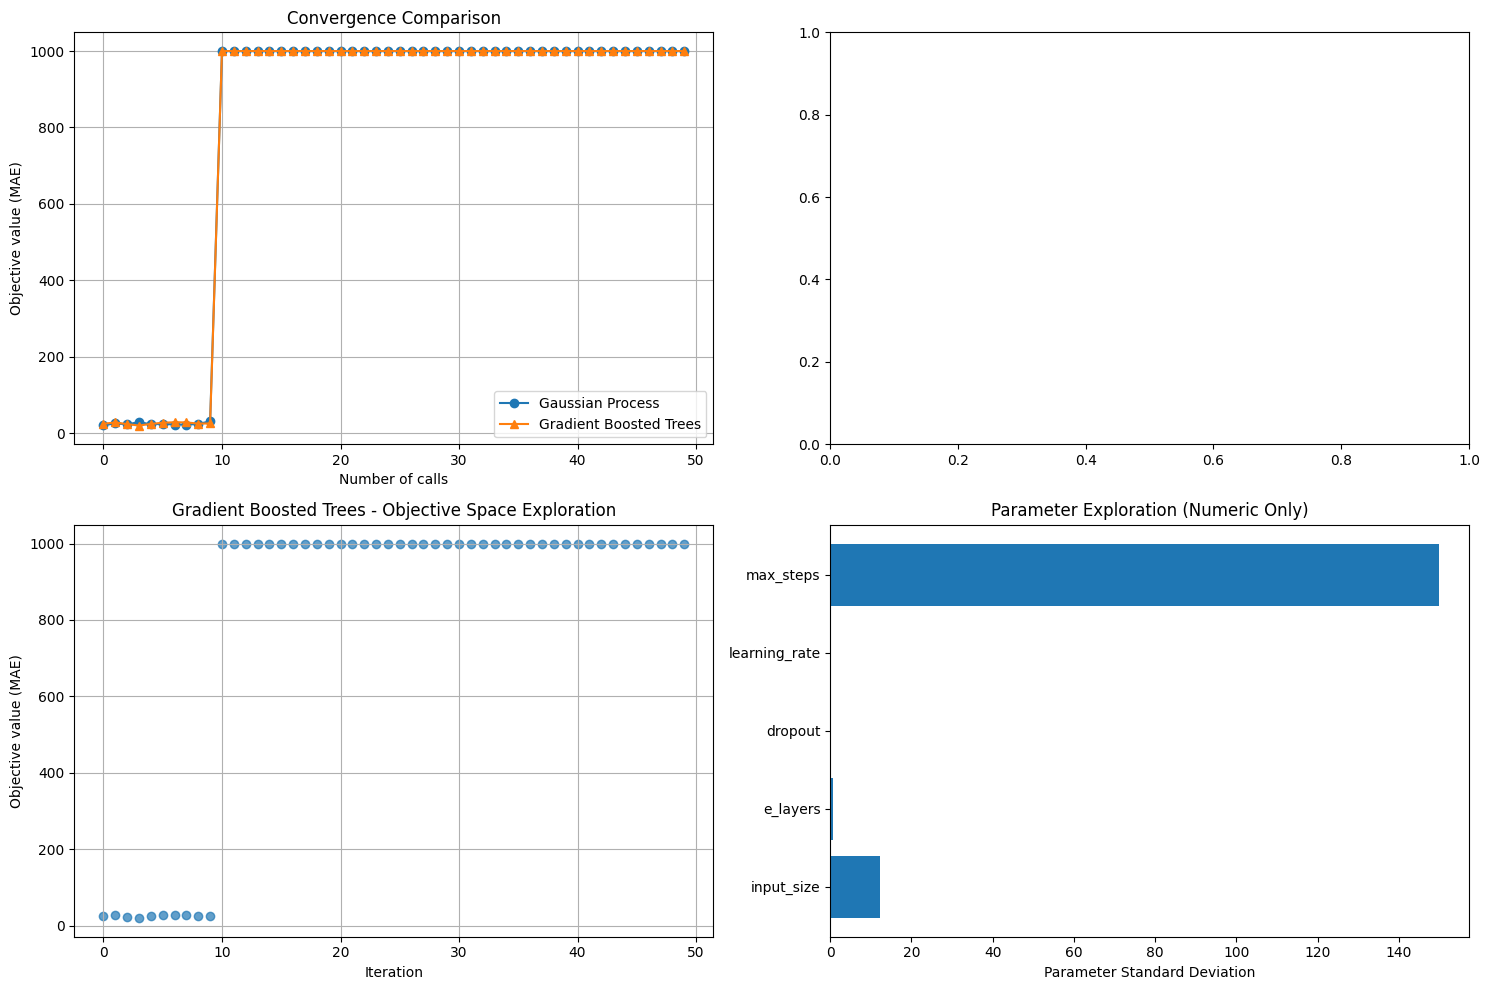

In [12]:

# Chọn phương pháp tốt nhất
best_method_idx = methods_comparison['Best_MAE'].idxmin()
best_method = methods_comparison.iloc[best_method_idx]['Method']
best_result = [result_gp, result_gbrt][best_method_idx]

print(f"\nPhương pháp tốt nhất: {best_method}")
print(f"Điểm số tốt nhất: {best_result.fun:.4f}")

# Visualize kết quả
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot convergence for all methods
ax1 = axes[0, 0]
ax1.plot(result_gp.func_vals, label='Gaussian Process', marker='o')
ax1.plot(result_gbrt.func_vals, label='Gradient Boosted Trees', marker='^')
ax1.set_xlabel('Number of calls')
ax1.set_ylabel('Objective value (MAE)')
ax1.set_title('Convergence Comparison')
ax1.legend()
ax1.grid(True)


# Plot objective space exploration for best method
ax3 = axes[1, 0]
ax3.scatter(range(len(best_result.func_vals)), best_result.func_vals, alpha=0.7)
ax3.set_xlabel('Iteration')
ax3.set_ylabel('Objective value (MAE)')
ax3.set_title(f'{best_method} - Objective Space Exploration')
ax3.grid(True)

# Plot parameter importance (simplified version)
ax4 = axes[1, 1]
# Calculate parameter variance as a proxy for importance
param_names = [dim.name for dim in dimensions]
param_values = np.array([[trial[name] for name in param_names] 
                        for trial in [dict(zip(param_names, x)) for x in best_result.x_iters]])

# For categorical parameters, we need to handle them differently
numeric_params = []
numeric_names = []
for i, (name, dim) in enumerate(zip(param_names, dimensions)):
    if isinstance(dim, (Integer, Real)):
        numeric_params.append(param_values[:, i].astype(float))
        numeric_names.append(name)

if numeric_params:
    param_std = [np.std(param) for param in numeric_params]
    ax4.barh(numeric_names, param_std)
    ax4.set_xlabel('Parameter Standard Deviation')
    ax4.set_title('Parameter Exploration (Numeric Only)')
else:
    ax4.text(0.5, 0.5, 'No numeric parameters to plot', 
             ha='center', va='center', transform=ax4.transAxes)

plt.tight_layout()
plt.savefig('bayesian_optimization_results.png', dpi=300, bbox_inches='tight')
plt.show()




In [16]:

# Huấn luyện mô hình cuối cùng với tham số tốt nhất
print("\n" + "="*60)
print("HUẤN LUYỆN MÔ HÌNH CUỐI CÙNG")
print("="*60)

final_params = dict(zip([dim.name for dim in dimensions], best_result.x))
final_model = TimeXer(
    h=horizon,
    input_size=final_params['input_size'],
    n_series=1,
    hidden_size=final_params['hidden_size'],
    n_heads=final_params['n_heads'],
    e_layers=final_params['e_layers'],
    d_ff=final_params['d_ff'],
    dropout=final_params['dropout'],
    loss=MAE(),
    valid_loss=MAE(),
    max_steps=final_params['max_steps'],
    learning_rate=final_params['learning_rate'],
    scaler_type=final_params['scaler_type'],
    early_stop_patience_steps=5,
    batch_size=final_params['batch_size'],
    futr_exog_list= ['usd_vnd','DJI_Close'] 

)

fcst_final = NeuralForecast(models=[final_model], freq='B')
forecasts_final = fcst_final.cross_validation(
    df=df, 
    val_size=val_len, 
    n_windows=None, 
    test_size=test_len - ((test_len - horizon) % horizon), 
    step_size=20
)


# Tính toán metrics cuối cùng
Y_true_final = forecasts_final['y'].values
Y_hat_final = forecasts_final['TimeXer'].values

MAE_final = mae(Y_true_final, Y_hat_final)
MAPE_final = mape(Y_true_final, Y_hat_final) * 100
RMSE_final = np.sqrt(mse(Y_true_final, Y_hat_final))

# Kết quả cuối cùng
df_final_results = pd.DataFrame({
    'Model': [f"TimeXer_{best_method.replace(' ', '_')}"],
    'Horizon': [str(horizon)],
    'Data': ["VNINDEX"],
    'MAE': [MAE_final],
    'RMSE': [RMSE_final],
    'MAPE': [MAPE_final]
})

print("\nKẾT QUẢ CUỐI CÙNG:")
print(df_final_results.to_string(index=False))

# Lưu kết quả
results_df = pd.DataFrame({
    'GP_MAE': result_gp.func_vals,
    'GBRT_MAE': result_gbrt.func_vals
})



# Hiển thị tóm tắt
print("\n" + "="*60)
print("TÓM TẮT")
print("="*60)
print(f"Phương pháp tốt nhất: {best_method}")
print(f"MAE tốt nhất: {best_result.fun:.4f}")
print(f"Số lần gọi hàm: {len(best_result.func_vals)}")
print("\nTham số tối ưu:")
for dim, val in zip(dimensions, best_result.x):
    print(f"  {dim.name}: {val}")

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 8.3 K  | train
6 | encoder      | Encoder                | 793 K  | train
7 | head         | FlattenHead            | 12.8 K | train
----------------------------------------------------------------
817 K     Trainable params
0         Non-trainable params
817 K     Total params
3.269     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode



HUẤN LUYỆN MÔ HÌNH CUỐI CÙNG


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=842` reached.
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]


KẾT QUẢ CUỐI CÙNG:
                         Model Horizon    Data       MAE      RMSE     MAPE
TimeXer_Gradient_Boosted_Trees      20 VNINDEX 19.889278 24.876727 1.577967

TÓM TẮT
Phương pháp tốt nhất: Gradient Boosted Trees
MAE tốt nhất: 19.8893
Số lần gọi hàm: 50

Tham số tối ưu:
  input_size: 64
  hidden_size: 128
  n_heads: 8
  e_layers: 3
  d_ff: 512
  dropout: 0.2425192044349384
  learning_rate: 4.066563313514792e-05
  batch_size: 32
  max_steps: 842
  scaler_type: robust


(array([19844., 19905., 19967., 20028., 20089., 20148.]),
 [Text(19844.0, 0, '2024-05'),
  Text(19905.0, 0, '2024-07'),
  Text(19967.0, 0, '2024-09'),
  Text(20028.0, 0, '2024-11'),
  Text(20089.0, 0, '2025-01'),
  Text(20148.0, 0, '2025-03')])

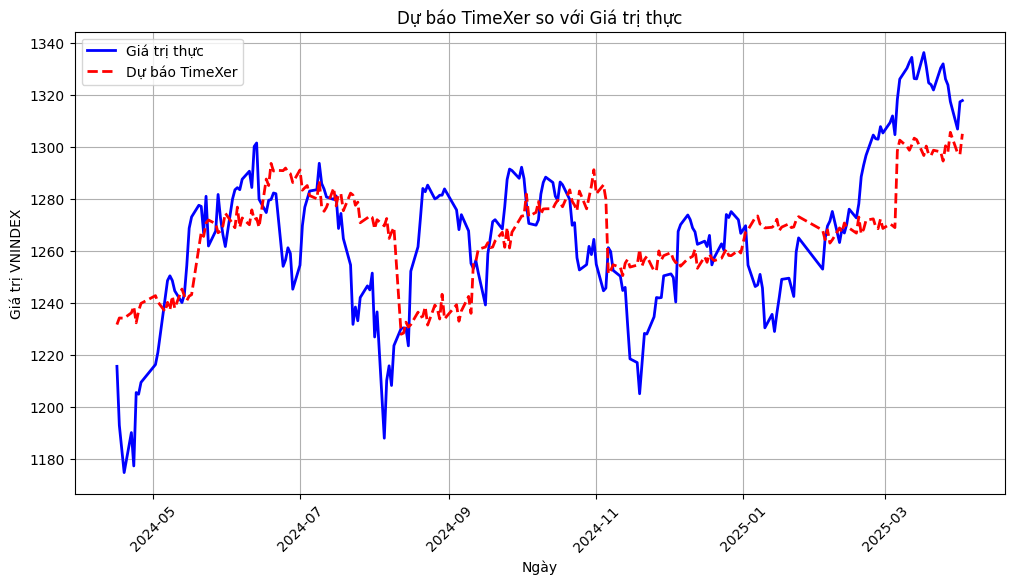

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd



# 1. Biểu đồ đường: Giá trị thực vs Dự báo
plt.figure(figsize=(12, 6))

# Lấy cột ds từ forecasts_final làm trục thời gian
time_axis = forecasts_final['ds'].values

plt.plot(time_axis, Y_true_final, label='Giá trị thực', color='blue', linewidth=2)
plt.plot(time_axis, Y_hat_final, label='Dự báo TimeXer', color='red', linestyle='--', linewidth=2)

plt.xlabel('Ngày')
plt.ylabel('Giá trị VNINDEX')
plt.title('Dự báo TimeXer so với Giá trị thực')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)


## Bayes - 20 bước - Close, DJ


In [84]:
### Bayes
## Bayes
import pandas as pd
import numpy as np
from skopt import gp_minimize, forest_minimize, gbrt_minimize
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from skopt.plots import plot_convergence, plot_objective, plot_evaluations
from neuralforecast import NeuralForecast
from neuralforecast.models import TimeXer
from neuralforecast.losses.pytorch import MAE, MSE, RMSE
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_percentage_error as mape
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


In [ ]:


horizon = 20

# Định nghĩa không gian tìm kiếm với skopt
dimensions = [
    Integer(low=40, high=80, name='input_size'),
    Categorical(categories=[128, 256], name='hidden_size'),
    Categorical(categories=[8, 16], name='n_heads'),
    Integer(low=1, high=3, name='e_layers'),
    Categorical(categories=[256, 512], name='d_ff'),
    Real(low=0.0, high=0.3, name='dropout'),
    Real(low=1e-5, high=1e-3, prior='log-uniform', name='learning_rate'),
    Categorical(categories=[32, 64,128], name='batch_size'),
    Integer(low=500, high=1000, name='max_steps'),
    Categorical(categories=['standard', 'robust', 'minmax'], name='scaler_type'),
]

# Global variables để lưu kết quả
results_history = []
best_score = float('inf')
best_params = None

# Callback function để lưu kết quả trong quá trình optimize
def callback_func(result):
    global results_history, best_score, best_params
    
    current_score = result.func_vals[-1]
    current_params = dict(zip([dim.name for dim in dimensions], result.x_iters[-1]))
    
    results_history.append({
        'iteration': len(result.func_vals),
        'score': current_score,
        **current_params
    })
    
    if current_score < best_score:
        best_score = current_score
        best_params = current_params.copy()
        print(f"New best score: {current_score:.4f} at iteration {len(result.func_vals)}")

@use_named_args(dimensions)
def objective(**params):
    """
    Hàm mục tiêu cho Bayesian Optimization
    """
    try:
        # Tạo mô hình với các siêu tham số
        model = TimeXer(
            h=horizon,
            input_size=params['input_size'],
            n_series=1,
            hidden_size=params['hidden_size'],
            n_heads=params['n_heads'],
            e_layers=params['e_layers'],
            d_ff=params['d_ff'],
            dropout=params['dropout'],
            loss=MAE(),
            valid_loss=MAE(),
            max_steps=params['max_steps'],
            learning_rate=params['learning_rate'],
            scaler_type=params['scaler_type'],
            early_stop_patience_steps=5,
            batch_size=params['batch_size'],
            futr_exog_list= ['DJI_Close']

        )
        
        # Khởi tạo NeuralForecast
        fcst = NeuralForecast(models=[model], freq='B')
        
        # Thực hiện cross validation
        forecasts = fcst.cross_validation(
            df=df, 
            val_size=val_len, 
            n_windows=None, 
            test_size=test_len - ((test_len - horizon) % horizon), 
            step_size=horizon
        )
        
        # Tính toán MAE
        Y_true = forecasts['y'].values
        Y_hat = forecasts['TimeXer'].values
        MAE_score = mae(Y_true, Y_hat)
        
        print(f"MAE: {MAE_score:.4f} | Params: {params}")
        return MAE_score
        
    except Exception as e:
        print(f"Error in objective function: {e}")
        return 1000.0  # Penalty for failed runs



In [64]:


# Phương pháp 1: Gaussian Process Optimization
print("="*60)
print("PHƯƠNG PHÁP 1: GAUSSIAN PROCESS OPTIMIZATION")
print("="*60)

result_gp = gp_minimize(
    func=objective,
    dimensions=dimensions,
    n_calls=50,  # Số lần gọi hàm objective
    n_initial_points=10,  # Số điểm khởi tạo random
    acq_func='EI',  # Expected Improvement
    random_state=42,
    callback=callback_func
)

print(f"Best GP score: {result_gp.fun:.4f}")
print("Best GP parameters:")
for dim, val in zip(dimensions, result_gp.x):
    print(f"  {dim.name}: {val}")

# # Phương pháp 2: Random Forest Optimization
# print("\n" + "="*60)
# print("PHƯƠNG PHÁP 2: RANDOM FOREST OPTIMIZATION")
# print("="*60)

# results_history = []  # Reset history
# result_rf = forest_minimize(
#     func=objective,
#     dimensions=dimensions,
#     n_calls=50,
#     n_initial_points=10,
#     random_state=42,
#     callback=callback_func
# )

# print(f"Best RF score: {result_rf.fun:.4f}")
# print("Best RF parameters:")
# for dim, val in zip(dimensions, result_rf.x):
#     print(f"  {dim.name}: {val}")

# Phương pháp 3: Gradient Boosted Trees Optimization  
print("\n" + "="*60)
print("PHƯƠNG PHÁP 3: GRADIENT BOOSTED TREES OPTIMIZATION")
print("="*60)

results_history = []  # Reset history
result_gbrt = gbrt_minimize(
    func=objective,
    dimensions=dimensions,
    n_calls=50,
    n_initial_points=10,
    random_state=42,
    callback=callback_func
)

print(f"Best GBRT score: {result_gbrt.fun:.4f}")
print("Best GBRT parameters:")
for dim, val in zip(dimensions, result_gbrt.x):
    print(f"  {dim.name}: {val}")

# So sánh kết quả của 3 phương pháp
print("\n" + "="*60)
print("SO SÁNH KẾT QUẢ")
print("="*60)

methods_comparison = pd.DataFrame({
    'Method': ['Gaussian Process',  'Gradient Boosted Trees'],
    'Best_MAE': [result_gp.fun,  result_gbrt.fun],
    'N_calls': [len(result_gp.func_vals),  len(result_gbrt.func_vals)]
})

print(methods_comparison.to_string(index=False))



Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


PHƯƠNG PHÁP 1: GAUSSIAN PROCESS OPTIMIZATION



  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 9.3 K  | train
6 | encoder      | Encoder                | 397 K  | train
7 | head         | FlattenHead            | 12.8 K | train
----------------------------------------------------------------
422 K     Trainable params
0         Non-trainable params
422 K     Total params
1.689     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=571` reached.
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 11.0 K | train
6 | encoder      | Encoder                | 791 K  | train
7 | head         | FlattenHead            | 15.4 K | train
----------------------------------------------------------------
822 K     Trainable params
0         Non-trainable params
822 K     Total params
3.288     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


MAE: 28.4481 | Params: {'input_size': 72, 'hidden_size': 128, 'n_heads': 16, 'e_layers': 2, 'd_ff': 256, 'dropout': 0.02999247474540087, 'learning_rate': 8.288916866885136e-05, 'batch_size': 64, 'max_steps': 571, 'scaler_type': 'robust'}
New best score: 28.4481 at iteration 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=512` reached.
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1


MAE: 27.1360 | Params: {'input_size': 42, 'hidden_size': 256, 'n_heads': 16, 'e_layers': 1, 'd_ff': 512, 'dropout': 0.18524445288831498, 'learning_rate': 0.00016722697006183674, 'batch_size': 32, 'max_steps': 512, 'scaler_type': 'robust'}
New best score: 27.1360 at iteration 2


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 7.3 K  | train
6 | encoder      | Encoder                | 199 K  | train
7 | head         | FlattenHead            | 10.3 K | train
----------------------------------------------------------------
218 K     Trainable params
0         Non-trainable params
218 K     Total params
0.875     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=733` reached.
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


MAE: 22.5880 | Params: {'input_size': 56, 'hidden_size': 128, 'n_heads': 16, 'e_layers': 1, 'd_ff': 256, 'dropout': 0.18551580279992622, 'learning_rate': 5.820013372709849e-05, 'batch_size': 128, 'max_steps': 733, 'scaler_type': 'minmax'}
New best score: 22.5880 at iteration 3



  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 8.7 K  | train
6 | encoder      | Encoder                | 793 K  | train
7 | head         | FlattenHead            | 12.8 K | train
----------------------------------------------------------------
817 K     Trainable params
0         Non-trainable params
817 K     Total params
3.271     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=621` reached.
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 16.6 K | train
6 | encoder      | Encoder                | 1.3 M  | train
7 | head         | FlattenHead            | 25.6 K | train
----------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.464     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


MAE: 28.6783 | Params: {'input_size': 67, 'hidden_size': 128, 'n_heads': 8, 'e_layers': 3, 'd_ff': 512, 'dropout': 0.11562495076197486, 'learning_rate': 1.0762979285747968e-05, 'batch_size': 32, 'max_steps': 621, 'scaler_type': 'minmax'}


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=784` reached.
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


MAE: 22.4825 | Params: {'input_size': 64, 'hidden_size': 256, 'n_heads': 8, 'e_layers': 2, 'd_ff': 256, 'dropout': 0.2266084230952958, 'learning_rate': 7.084541505250234e-05, 'batch_size': 32, 'max_steps': 784, 'scaler_type': 'standard'}
New best score: 22.4825 at iteration 5



  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 9.6 K  | train
6 | encoder      | Encoder                | 793 K  | train
7 | head         | FlattenHead            | 12.8 K | train
----------------------------------------------------------------
818 K     Trainable params
0         Non-trainable params
818 K     Total params
3.274     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=981` reached.
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 18.2 K | train
6 | encoder      | Encoder                | 2.4 M  | train
7 | head         | FlattenHead            | 25.6 K | train
----------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.684     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


MAE: 24.1817 | Params: {'input_size': 74, 'hidden_size': 128, 'n_heads': 8, 'e_layers': 3, 'd_ff': 512, 'dropout': 0.09796223064175062, 'learning_rate': 0.00013832094546570485, 'batch_size': 64, 'max_steps': 981, 'scaler_type': 'minmax'}


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=508` reached.
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


MAE: 29.3234 | Params: {'input_size': 70, 'hidden_size': 256, 'n_heads': 16, 'e_layers': 3, 'd_ff': 512, 'dropout': 0.08279975460676302, 'learning_rate': 3.913334858104373e-05, 'batch_size': 32, 'max_steps': 508, 'scaler_type': 'robust'}



  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 7.3 K  | train
6 | encoder      | Encoder                | 264 K  | train
7 | head         | FlattenHead            | 10.3 K | train
----------------------------------------------------------------
284 K     Trainable params
0         Non-trainable params
284 K     Total params
1.138     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=826` reached.
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


MAE: 22.1925 | Params: {'input_size': 56, 'hidden_size': 128, 'n_heads': 8, 'e_layers': 1, 'd_ff': 512, 'dropout': 0.23705266215936174, 'learning_rate': 0.00016289957436723494, 'batch_size': 128, 'max_steps': 826, 'scaler_type': 'minmax'}
New best score: 22.1925 at iteration 8



  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 9.6 K  | train
6 | encoder      | Encoder                | 529 K  | train
7 | head         | FlattenHead            | 12.8 K | train
----------------------------------------------------------------
554 K     Trainable params
0         Non-trainable params
554 K     Total params
2.216     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


MAE: 27.2073 | Params: {'input_size': 74, 'hidden_size': 128, 'n_heads': 8, 'e_layers': 2, 'd_ff': 512, 'dropout': 0.19977670698524902, 'learning_rate': 0.00015226341829186323, 'batch_size': 32, 'max_steps': 781, 'scaler_type': 'robust'}



  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 20.5 K | train
6 | encoder      | Encoder                | 659 K  | train
7 | head         | FlattenHead            | 25.6 K | train
----------------------------------------------------------------
710 K     Trainable params
0         Non-trainable params
710 K     Total params
2.842     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

MAE: 33.4733 | Params: {'input_size': 79, 'hidden_size': 256, 'n_heads': 16, 'e_layers': 1, 'd_ff': 256, 'dropout': 0.012130076861529405, 'learning_rate': 0.0002638309731463534, 'batch_size': 32, 'max_steps': 720, 'scaler_type': 'standard'}


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 10.5 K | train
6 | encoder      | Encoder                | 659 K  | train
7 | head         | FlattenHead            | 15.4 K | train
----------------------------------------------------------------
690 K     Trainable params
0         Non-trainable params
690 K     Total params
2.761     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=32


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 5.2 K  | train
6 | encoder      | Encoder                | 264 K  | train
7 | head         | FlattenHead            | 7.7 K  | train
----------------------------------------------------------------
279 K     Trainable params
0         Non-trainable params
279 K     Total params
1.120     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=64


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 9.7 K  | train
6 | encoder      | Encoder                | 793 K  | train
7 | head         | FlattenHead            | 12.8 K | train
----------------------------------------------------------------
818 K     Trainable params
0         Non-trainable params
818 K     Total params
3.275     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=128


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 19.2 K | train
6 | encoder      | Encoder                | 2.4 M  | train
7 | head         | FlattenHead            | 25.6 K | train
----------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.688     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=64


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 20.5 K | train
6 | encoder      | Encoder                | 791 K  | train
7 | head         | FlattenHead            | 25.6 K | train
----------------------------------------------------------------
841 K     Trainable params
0         Non-trainable params
841 K     Total params
3.367     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=64


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 10.2 K | train
6 | encoder      | Encoder                | 264 K  | train
7 | head         | FlattenHead            | 12.8 K | train
----------------------------------------------------------------
290 K     Trainable params
0         Non-trainable params
290 K     Total params
1.160     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=64


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 7.6 K  | train
6 | encoder      | Encoder                | 793 K  | train
7 | head         | FlattenHead            | 10.3 K | train
----------------------------------------------------------------
813 K     Trainable params
0         Non-trainable params
813 K     Total params
3.256     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=32


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 10.4 K | train
6 | encoder      | Encoder                | 199 K  | train
7 | head         | FlattenHead            | 15.4 K | train
----------------------------------------------------------------
226 K     Trainable params
0         Non-trainable params
226 K     Total params
0.908     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=128


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 9.1 K  | train
6 | encoder      | Encoder                | 529 K  | train
7 | head         | FlattenHead            | 12.8 K | train
----------------------------------------------------------------
553 K     Trainable params
0         Non-trainable params
553 K     Total params
2.214     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=32


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 11.5 K | train
6 | encoder      | Encoder                | 791 K  | train
7 | head         | FlattenHead            | 15.4 K | train
----------------------------------------------------------------
822 K     Trainable params
0         Non-trainable params
822 K     Total params
3.290     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=32


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 10.4 K | train
6 | encoder      | Encoder                | 529 K  | train
7 | head         | FlattenHead            | 15.4 K | train
----------------------------------------------------------------
557 K     Trainable params
0         Non-trainable params
557 K     Total params
2.229     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=128


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 7.3 K  | train
6 | encoder      | Encoder                | 264 K  | train
7 | head         | FlattenHead            | 10.3 K | train
----------------------------------------------------------------
284 K     Trainable params
0         Non-trainable params
284 K     Total params
1.138     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=128


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 10.4 K | train
6 | encoder      | Encoder                | 596 K  | train
7 | head         | FlattenHead            | 15.4 K | train
----------------------------------------------------------------
624 K     Trainable params
0         Non-trainable params
624 K     Total params
2.498     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=64


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 9.6 K  | train
6 | encoder      | Encoder                | 793 K  | train
7 | head         | FlattenHead            | 12.8 K | train
----------------------------------------------------------------
818 K     Trainable params
0         Non-trainable params
818 K     Total params
3.274     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=32


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 7.8 K  | train
6 | encoder      | Encoder                | 397 K  | train
7 | head         | FlattenHead            | 10.3 K | train
----------------------------------------------------------------
418 K     Trainable params
0         Non-trainable params
418 K     Total params
1.672     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=64


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 10.2 K | train
6 | encoder      | Encoder                | 596 K  | train
7 | head         | FlattenHead            | 12.8 K | train
----------------------------------------------------------------
621 K     Trainable params
0         Non-trainable params
621 K     Total params
2.487     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=64


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 7.8 K  | train
6 | encoder      | Encoder                | 264 K  | train
7 | head         | FlattenHead            | 10.3 K | train
----------------------------------------------------------------
285 K     Trainable params
0         Non-trainable params
285 K     Total params
1.140     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=64


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 7.3 K  | train
6 | encoder      | Encoder                | 529 K  | train
7 | head         | FlattenHead            | 10.3 K | train
----------------------------------------------------------------
549 K     Trainable params
0         Non-trainable params
549 K     Total params
2.197     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=128


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 9.2 K  | train
6 | encoder      | Encoder                | 397 K  | train
7 | head         | FlattenHead            | 12.8 K | train
----------------------------------------------------------------
422 K     Trainable params
0         Non-trainable params
422 K     Total params
1.688     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=64


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 5.6 K  | train
6 | encoder      | Encoder                | 199 K  | train
7 | head         | FlattenHead            | 7.7 K  | train
----------------------------------------------------------------
214 K     Trainable params
0         Non-trainable params
214 K     Total params
0.858     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=32


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 5.9 K  | train
6 | encoder      | Encoder                | 529 K  | train
7 | head         | FlattenHead            | 7.7 K  | train
----------------------------------------------------------------
545 K     Trainable params
0         Non-trainable params
545 K     Total params
2.181     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=128


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 20.2 K | train
6 | encoder      | Encoder                | 1.3 M  | train
7 | head         | FlattenHead            | 25.6 K | train
----------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.478     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=32


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 16.9 K | train
6 | encoder      | Encoder                | 1.3 M  | train
7 | head         | FlattenHead            | 25.6 K | train
----------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.465     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=32


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 6.8 K  | train
6 | encoder      | Encoder                | 199 K  | train
7 | head         | FlattenHead            | 10.3 K | train
----------------------------------------------------------------
218 K     Trainable params
0         Non-trainable params
218 K     Total params
0.873     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=128


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 8.1 K  | train
6 | encoder      | Encoder                | 397 K  | train
7 | head         | FlattenHead            | 10.3 K | train
----------------------------------------------------------------
418 K     Trainable params
0         Non-trainable params
418 K     Total params
1.673     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=64


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 9.9 K  | train
6 | encoder      | Encoder                | 596 K  | train
7 | head         | FlattenHead            | 12.8 K | train
----------------------------------------------------------------
621 K     Trainable params
0         Non-trainable params
621 K     Total params
2.486     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=32


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 9.6 K  | train
6 | encoder      | Encoder                | 793 K  | train
7 | head         | FlattenHead            | 12.8 K | train
----------------------------------------------------------------
818 K     Trainable params
0         Non-trainable params
818 K     Total params
3.274     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=32


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 17.9 K | train
6 | encoder      | Encoder                | 1.3 M  | train
7 | head         | FlattenHead            | 25.6 K | train
----------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.469     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=32


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 8.2 K  | train
6 | encoder      | Encoder                | 529 K  | train
7 | head         | FlattenHead            | 10.3 K | train
----------------------------------------------------------------
550 K     Trainable params
0         Non-trainable params
550 K     Total params
2.200     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=32


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 16.4 K | train
6 | encoder      | Encoder                | 1.3 M  | train
7 | head         | FlattenHead            | 20.5 K | train
----------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.443     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=32


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 9.5 K  | train
6 | encoder      | Encoder                | 397 K  | train
7 | head         | FlattenHead            | 12.8 K | train
----------------------------------------------------------------
422 K     Trainable params
0         Non-trainable params
422 K     Total params
1.689     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=64


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 9.7 K  | train
6 | encoder      | Encoder                | 793 K  | train
7 | head         | FlattenHead            | 12.8 K | train
----------------------------------------------------------------
818 K     Trainable params
0         Non-trainable params
818 K     Total params
3.275     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=64


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 8.1 K  | train
6 | encoder      | Encoder                | 596 K  | train
7 | head         | FlattenHead            | 10.3 K | train
----------------------------------------------------------------
617 K     Trainable params
0         Non-trainable params
617 K     Total params
2.468     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=128


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 16.1 K | train
6 | encoder      | Encoder                | 1.3 M  | train
7 | head         | FlattenHead            | 20.5 K | train
----------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.442     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=32


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 10.0 K | train
6 | encoder      | Encoder                | 264 K  | train
7 | head         | FlattenHead            | 12.8 K | train
----------------------------------------------------------------
289 K     Trainable params
0         Non-trainable params
289 K     Total params
1.159     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=128


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 9.6 K  | train
6 | encoder      | Encoder                | 529 K  | train
7 | head         | FlattenHead            | 12.8 K | train
----------------------------------------------------------------
554 K     Trainable params
0         Non-trainable params
554 K     Total params
2.216     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=32


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 6.5 K  | train
6 | encoder      | Encoder                | 264 K  | train
7 | head         | FlattenHead            | 10.3 K | train
----------------------------------------------------------------
283 K     Trainable params
0         Non-trainable params
283 K     Total params
1.135     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=128


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 20.5 K | train
6 | encoder      | Encoder                | 659 K  | train
7 | head         | FlattenHead            | 25.6 K | train
----------------------------------------------------------------
710 K     Trainable params
0         Non-trainable params
710 K     Total params
2.842     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=32


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 20.2 K | train
6 | encoder      | Encoder                | 1.3 M  | train
7 | head         | FlattenHead            | 25.6 K | train
----------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.478     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=32


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 14.8 K | train
6 | encoder      | Encoder                | 1.3 M  | train
7 | head         | FlattenHead            | 20.5 K | train
----------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.436     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=32


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 14.3 K | train
6 | encoder      | Encoder                | 1.3 M  | train
7 | head         | FlattenHead            | 20.5 K | train
----------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.434     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Best GP score: 22.1925
Best GP parameters:
  input_size: 56
  hidden_size: 128
  n_heads: 8
  e_layers: 1
  d_ff: 512
  dropout: 0.23705266215936174
  learning_rate: 0.00016289957436723494
  batch_size: 128
  max_steps: 826
  scaler_type: minmax

PHƯƠNG PHÁP 3: GRADIENT BOOSTED TREES OPTIMIZATION


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=801` reached.
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 10.8 K | train
6 | encoder      | Encoder                | 659 K  | train
7 | head         | FlattenHead            | 15.4 K | train
----------------------------------------------------------------
690 K     Trainable params
0         Non-trainable params
690 K     Total params
2.762     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


MAE: 24.5995 | Params: {'input_size': 55, 'hidden_size': 256, 'n_heads': 16, 'e_layers': 2, 'd_ff': 256, 'dropout': 0.0467983561008608, 'learning_rate': 1.3066739238053285e-05, 'batch_size': 128, 'max_steps': 801, 'scaler_type': 'minmax'}


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=716` reached.
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 8.3 K  | train
6 | encoder      | Encoder                | 397 K  | train
7 | head         | FlattenHead            | 12.8 K | train
----------------------------------------------------------------
421 K     Trainable params
0         Non-trainable params
421 K     Total params
1.685     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


MAE: 25.5213 | Params: {'input_size': 41, 'hidden_size': 256, 'n_heads': 16, 'e_layers': 1, 'd_ff': 256, 'dropout': 0.05502135295603015, 'learning_rate': 4.059611610484304e-05, 'batch_size': 64, 'max_steps': 716, 'scaler_type': 'standard'}


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=796` reached.
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 8.3 K  | train
6 | encoder      | Encoder                | 793 K  | train
7 | head         | FlattenHead            | 12.8 K | train
----------------------------------------------------------------
817 K     Trainable params
0         Non-trainable params
817 K     Total params
3.269     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


MAE: 23.4079 | Params: {'input_size': 64, 'hidden_size': 128, 'n_heads': 8, 'e_layers': 2, 'd_ff': 256, 'dropout': 0.23555278841790414, 'learning_rate': 2.508115686045231e-05, 'batch_size': 64, 'max_steps': 796, 'scaler_type': 'standard'}


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=842` reached.
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 5.9 K  | train
6 | encoder      | Encoder                | 596 K  | train
7 | head         | FlattenHead            | 7.7 K  | train
----------------------------------------------------------------
612 K     Trainable params
0         Non-trainable params
612 K     Total params
2.449     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


MAE: 23.1103 | Params: {'input_size': 64, 'hidden_size': 128, 'n_heads': 8, 'e_layers': 3, 'd_ff': 512, 'dropout': 0.2425192044349384, 'learning_rate': 4.066563313514792e-05, 'batch_size': 32, 'max_steps': 842, 'scaler_type': 'robust'}


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=773` reached.
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


MAE: 23.9500 | Params: {'input_size': 45, 'hidden_size': 128, 'n_heads': 8, 'e_layers': 3, 'd_ff': 256, 'dropout': 0.1987566853061946, 'learning_rate': 4.201672054372531e-05, 'batch_size': 64, 'max_steps': 773, 'scaler_type': 'standard'}



  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 20.5 K | train
6 | encoder      | Encoder                | 2.4 M  | train
7 | head         | FlattenHead            | 25.6 K | train
----------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.693     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=523` reached.
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


MAE: 26.2820 | Params: {'input_size': 79, 'hidden_size': 256, 'n_heads': 16, 'e_layers': 3, 'd_ff': 512, 'dropout': 0.2765622705069351, 'learning_rate': 1.5030900645056825e-05, 'batch_size': 32, 'max_steps': 523, 'scaler_type': 'standard'}



  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 7.3 K  | train
6 | encoder      | Encoder                | 397 K  | train
7 | head         | FlattenHead            | 10.3 K | train
----------------------------------------------------------------
417 K     Trainable params
0         Non-trainable params
417 K     Total params
1.670     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=537` reached.
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 9.2 K  | train
6 | encoder      | Encoder                | 793 K  | train
7 | head         | FlattenHead            | 12.8 K | train
----------------------------------------------------------------
818 K     Trainable params
0         Non-trainable params
818 K     Total params
3.273     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


MAE: 28.2671 | Params: {'input_size': 56, 'hidden_size': 128, 'n_heads': 16, 'e_layers': 2, 'd_ff': 256, 'dropout': 0.16280882494747456, 'learning_rate': 1.9135880487692317e-05, 'batch_size': 128, 'max_steps': 537, 'scaler_type': 'minmax'}


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


MAE: 31.0282 | Params: {'input_size': 71, 'hidden_size': 128, 'n_heads': 8, 'e_layers': 3, 'd_ff': 512, 'dropout': 0.2187021504122962, 'learning_rate': 0.0003487712624545935, 'batch_size': 32, 'max_steps': 679, 'scaler_type': 'standard'}



  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 19.5 K | train
6 | encoder      | Encoder                | 659 K  | train
7 | head         | FlattenHead            | 25.6 K | train
----------------------------------------------------------------
709 K     Trainable params
0         Non-trainable params
709 K     Total params
2.838     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


MAE: 30.2389 | Params: {'input_size': 75, 'hidden_size': 256, 'n_heads': 8, 'e_layers': 1, 'd_ff': 256, 'dropout': 0.09755499660802412, 'learning_rate': 0.0002878805718308926, 'batch_size': 64, 'max_steps': 944, 'scaler_type': 'robust'}



  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 11.8 K | train
6 | encoder      | Encoder                | 1.6 M  | train
7 | head         | FlattenHead            | 15.4 K | train
----------------------------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.454     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=513` reached.
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

MAE: 25.6985 | Params: {'input_size': 45, 'hidden_size': 256, 'n_heads': 16, 'e_layers': 2, 'd_ff': 512, 'dropout': 0.14813867890931726, 'learning_rate': 0.00011103647313054626, 'batch_size': 64, 'max_steps': 513, 'scaler_type': 'standard'}


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 6.9 K  | train
6 | encoder      | Encoder                | 793 K  | train
7 | head         | FlattenHead            | 10.3 K | train
----------------------------------------------------------------
813 K     Trainable params
0         Non-trainable params
813 K     Total params
3.253     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=32


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 7.7 K  | train
6 | encoder      | Encoder                | 529 K  | train
7 | head         | FlattenHead            | 10.3 K | train
----------------------------------------------------------------
549 K     Trainable params
0         Non-trainable params
549 K     Total params
2.198     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=64


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 12.3 K | train
6 | encoder      | Encoder                | 1.6 M  | train
7 | head         | FlattenHead            | 15.4 K | train
----------------------------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.456     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=32


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 10.1 K | train
6 | encoder      | Encoder                | 264 K  | train
7 | head         | FlattenHead            | 12.8 K | train
----------------------------------------------------------------
289 K     Trainable params
0         Non-trainable params
289 K     Total params
1.160     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=128


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 11.3 K | train
6 | encoder      | Encoder                | 2.4 M  | train
7 | head         | FlattenHead            | 15.4 K | train
----------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.615     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=32


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 11.5 K | train
6 | encoder      | Encoder                | 2.0 M  | train
7 | head         | FlattenHead            | 15.4 K | train
----------------------------------------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
8.041     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=128


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 20.0 K | train
6 | encoder      | Encoder                | 659 K  | train
7 | head         | FlattenHead            | 25.6 K | train
----------------------------------------------------------------
709 K     Trainable params
0         Non-trainable params
709 K     Total params
2.840     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=32


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 6.9 K  | train
6 | encoder      | Encoder                | 793 K  | train
7 | head         | FlattenHead            | 10.3 K | train
----------------------------------------------------------------
813 K     Trainable params
0         Non-trainable params
813 K     Total params
3.253     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=32


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 8.8 K  | train
6 | encoder      | Encoder                | 397 K  | train
7 | head         | FlattenHead            | 12.8 K | train
----------------------------------------------------------------
421 K     Trainable params
0         Non-trainable params
421 K     Total params
1.687     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=32


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 10.1 K | train
6 | encoder      | Encoder                | 529 K  | train
7 | head         | FlattenHead            | 12.8 K | train
----------------------------------------------------------------
554 K     Trainable params
0         Non-trainable params
554 K     Total params
2.218     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=64


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 10.4 K | train
6 | encoder      | Encoder                | 793 K  | train
7 | head         | FlattenHead            | 15.4 K | train
----------------------------------------------------------------
821 K     Trainable params
0         Non-trainable params
821 K     Total params
3.288     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=32


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 15.1 K | train
6 | encoder      | Encoder                | 1.3 M  | train
7 | head         | FlattenHead            | 20.5 K | train
----------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.438     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=64


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 8.1 K  | train
6 | encoder      | Encoder                | 793 K  | train
7 | head         | FlattenHead            | 10.3 K | train
----------------------------------------------------------------
814 K     Trainable params
0         Non-trainable params
814 K     Total params
3.258     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=128


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 13.6 K | train
6 | encoder      | Encoder                | 1.6 M  | train
7 | head         | FlattenHead            | 20.5 K | train
----------------------------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.482     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=64


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 16.9 K | train
6 | encoder      | Encoder                | 2.0 M  | train
7 | head         | FlattenHead            | 25.6 K | train
----------------------------------------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
8.103     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=64


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 6.4 K  | train
6 | encoder      | Encoder                | 793 K  | train
7 | head         | FlattenHead            | 10.3 K | train
----------------------------------------------------------------
812 K     Trainable params
0         Non-trainable params
812 K     Total params
3.251     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=128


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 13.3 K | train
6 | encoder      | Encoder                | 1.3 M  | train
7 | head         | FlattenHead            | 20.5 K | train
----------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.430     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=128


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 5.2 K  | train
6 | encoder      | Encoder                | 529 K  | train
7 | head         | FlattenHead            | 7.7 K  | train
----------------------------------------------------------------
544 K     Trainable params
0         Non-trainable params
544 K     Total params
2.178     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=32


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 14.1 K | train
6 | encoder      | Encoder                | 1.3 M  | train
7 | head         | FlattenHead            | 20.5 K | train
----------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.433     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=32


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 20.7 K | train
6 | encoder      | Encoder                | 2.4 M  | train
7 | head         | FlattenHead            | 30.7 K | train
----------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.715     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=32


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 9.7 K  | train
6 | encoder      | Encoder                | 793 K  | train
7 | head         | FlattenHead            | 12.8 K | train
----------------------------------------------------------------
818 K     Trainable params
0         Non-trainable params
818 K     Total params
3.275     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=64


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 7.2 K  | train
6 | encoder      | Encoder                | 199 K  | train
7 | head         | FlattenHead            | 10.3 K | train
----------------------------------------------------------------
218 K     Trainable params
0         Non-trainable params
218 K     Total params
0.875     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=64


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 5.4 K  | train
6 | encoder      | Encoder                | 596 K  | train
7 | head         | FlattenHead            | 7.7 K  | train
----------------------------------------------------------------
611 K     Trainable params
0         Non-trainable params
611 K     Total params
2.447     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=32


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 16.6 K | train
6 | encoder      | Encoder                | 2.4 M  | train
7 | head         | FlattenHead            | 25.6 K | train
----------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.678     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=32


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 11.8 K | train
6 | encoder      | Encoder                | 1.3 M  | train
7 | head         | FlattenHead            | 15.4 K | train
----------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.404     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=64


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 14.3 K | train
6 | encoder      | Encoder                | 1.3 M  | train
7 | head         | FlattenHead            | 20.5 K | train
----------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.434     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=32


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 20.7 K | train
6 | encoder      | Encoder                | 2.0 M  | train
7 | head         | FlattenHead            | 30.7 K | train
----------------------------------------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
8.139     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=64


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 9.0 K  | train
6 | encoder      | Encoder                | 397 K  | train
7 | head         | FlattenHead            | 12.8 K | train
----------------------------------------------------------------
421 K     Trainable params
0         Non-trainable params
421 K     Total params
1.687     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=64


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 10.0 K | train
6 | encoder      | Encoder                | 199 K  | train
7 | head         | FlattenHead            | 12.8 K | train
----------------------------------------------------------------
224 K     Trainable params
0         Non-trainable params
224 K     Total params
0.896     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=64


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 8.3 K  | train
6 | encoder      | Encoder                | 264 K  | train
7 | head         | FlattenHead            | 12.8 K | train
----------------------------------------------------------------
288 K     Trainable params
0         Non-trainable params
288 K     Total params
1.153     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=64


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 20.0 K | train
6 | encoder      | Encoder                | 659 K  | train
7 | head         | FlattenHead            | 25.6 K | train
----------------------------------------------------------------
709 K     Trainable params
0         Non-trainable params
709 K     Total params
2.840     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=128


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 12.3 K | train
6 | encoder      | Encoder                | 1.3 M  | train
7 | head         | FlattenHead            | 15.4 K | train
----------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.406     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=64


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 5.5 K  | train
6 | encoder      | Encoder                | 397 K  | train
7 | head         | FlattenHead            | 7.7 K  | train
----------------------------------------------------------------
413 K     Trainable params
0         Non-trainable params
413 K     Total params
1.653     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=128


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 8.7 K  | train
6 | encoder      | Encoder                | 264 K  | train
7 | head         | FlattenHead            | 12.8 K | train
----------------------------------------------------------------
288 K     Trainable params
0         Non-trainable params
288 K     Total params
1.154     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=32


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 10.0 K | train
6 | encoder      | Encoder                | 596 K  | train
7 | head         | FlattenHead            | 12.8 K | train
----------------------------------------------------------------
621 K     Trainable params
0         Non-trainable params
621 K     Total params
2.486     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=32


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 16.6 K | train
6 | encoder      | Encoder                | 791 K  | train
7 | head         | FlattenHead            | 25.6 K | train
----------------------------------------------------------------
837 K     Trainable params
0         Non-trainable params
837 K     Total params
3.352     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=32


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 4.4 K  | train
5 | ex_embedding | DataEmbedding_inverted | 18.2 K | train
6 | encoder      | Encoder                | 2.0 M  | train
7 | head         | FlattenHead            | 25.6 K | train
----------------------------------------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
8.108     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=128


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 8.4 K  | train
6 | encoder      | Encoder                | 529 K  | train
7 | head         | FlattenHead            | 12.8 K | train
----------------------------------------------------------------
552 K     Trainable params
0         Non-trainable params
552 K     Total params
2.211     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=64


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 9.7 K  | train
6 | encoder      | Encoder                | 793 K  | train
7 | head         | FlattenHead            | 12.8 K | train
----------------------------------------------------------------
818 K     Trainable params
0         Non-trainable params
818 K     Total params
3.275     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=64


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 5.6 K  | train
6 | encoder      | Encoder                | 529 K  | train
7 | head         | FlattenHead            | 7.7 K  | train
----------------------------------------------------------------
544 K     Trainable params
0         Non-trainable params
544 K     Total params
2.180     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Error in objective function: batch_size should be a positive integer value, but got batch_size=64
Best GBRT score: 23.1103
Best GBRT parameters:
  input_size: 64
  hidden_size: 128
  n_heads: 8
  e_layers: 3
  d_ff: 512
  dropout: 0.2425192044349384
  learning_rate: 4.066563313514792e-05
  batch_size: 32
  max_steps: 842
  scaler_type: robust

SO SÁNH KẾT QUẢ
                Method  Best_MAE  N_calls
      Gaussian Process 22.192489       50
Gradient Boosted Trees 23.110311       50


In [90]:
# So sánh kết quả của 3 phương pháp
print("\n" + "="*60)
print("SO SÁNH KẾT QUẢ")
print("="*60)

methods_comparison = pd.DataFrame({
    'Method': ['Gaussian Process',  'Gradient Boosted Trees'],
    'Best_MAE': [result_gp.fun,  result_gbrt.fun],
    'N_calls': [len(result_gp.func_vals),  len(result_gbrt.func_vals)]
})

print(methods_comparison.to_string(index=False))


SO SÁNH KẾT QUẢ
                Method  Best_MAE  N_calls
      Gaussian Process 22.192489       50
Gradient Boosted Trees 23.110311       50



Phương pháp tốt nhất: Gaussian Process
Điểm số tốt nhất: 22.1925


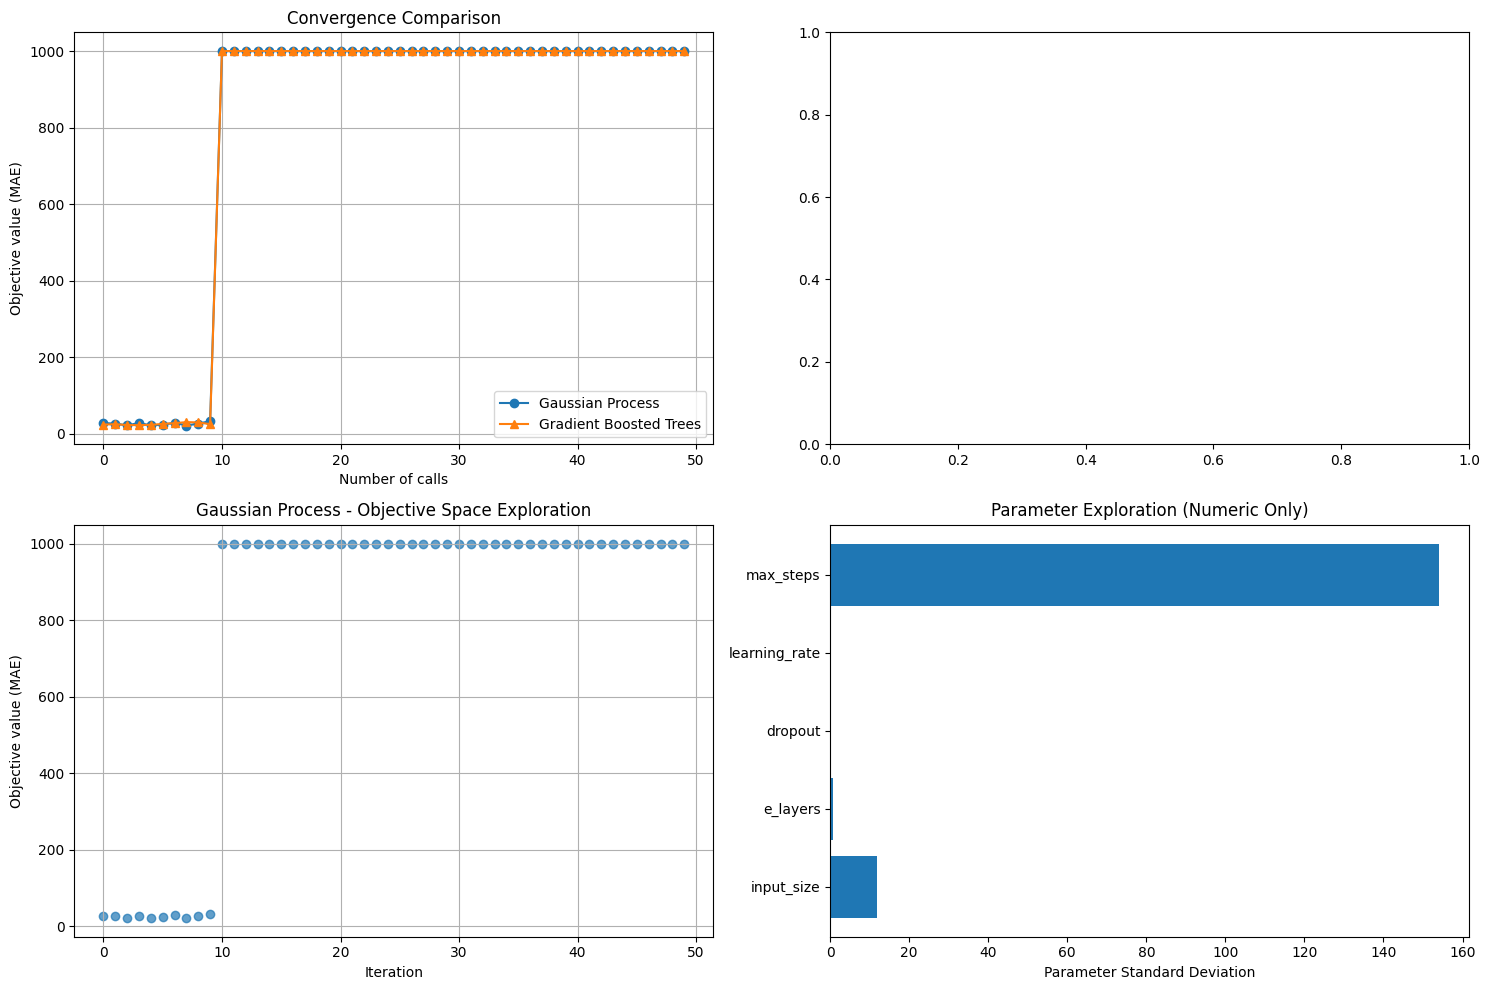

In [91]:

# Chọn phương pháp tốt nhất
best_method_idx = methods_comparison['Best_MAE'].idxmin()
best_method = methods_comparison.iloc[best_method_idx]['Method']
best_result = [result_gp, result_gbrt][best_method_idx]

print(f"\nPhương pháp tốt nhất: {best_method}")
print(f"Điểm số tốt nhất: {best_result.fun:.4f}")

# Visualize kết quả
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot convergence for all methods
ax1 = axes[0, 0]
ax1.plot(result_gp.func_vals, label='Gaussian Process', marker='o')
ax1.plot(result_gbrt.func_vals, label='Gradient Boosted Trees', marker='^')
ax1.set_xlabel('Number of calls')
ax1.set_ylabel('Objective value (MAE)')
ax1.set_title('Convergence Comparison')
ax1.legend()
ax1.grid(True)


# Plot objective space exploration for best method
ax3 = axes[1, 0]
ax3.scatter(range(len(best_result.func_vals)), best_result.func_vals, alpha=0.7)
ax3.set_xlabel('Iteration')
ax3.set_ylabel('Objective value (MAE)')
ax3.set_title(f'{best_method} - Objective Space Exploration')
ax3.grid(True)

# Plot parameter importance (simplified version)
ax4 = axes[1, 1]
# Calculate parameter variance as a proxy for importance
param_names = [dim.name for dim in dimensions]
param_values = np.array([[trial[name] for name in param_names] 
                        for trial in [dict(zip(param_names, x)) for x in best_result.x_iters]])

# For categorical parameters, we need to handle them differently
numeric_params = []
numeric_names = []
for i, (name, dim) in enumerate(zip(param_names, dimensions)):
    if isinstance(dim, (Integer, Real)):
        numeric_params.append(param_values[:, i].astype(float))
        numeric_names.append(name)

if numeric_params:
    param_std = [np.std(param) for param in numeric_params]
    ax4.barh(numeric_names, param_std)
    ax4.set_xlabel('Parameter Standard Deviation')
    ax4.set_title('Parameter Exploration (Numeric Only)')
else:
    ax4.text(0.5, 0.5, 'No numeric parameters to plot', 
             ha='center', va='center', transform=ax4.transAxes)

plt.tight_layout()
plt.savefig('bayesian_optimization_results.png', dpi=300, bbox_inches='tight')
plt.show()




In [92]:
dij_params= final_params

In [93]:
print(dij_params)


{'input_size': 56, 'hidden_size': 128, 'n_heads': 8, 'e_layers': 1, 'd_ff': 512, 'dropout': 0.23705266215936174, 'learning_rate': 0.00016289957436723494, 'batch_size': 128, 'max_steps': 826, 'scaler_type': 'minmax'}


In [94]:
final_params

{'input_size': 56,
 'hidden_size': 128,
 'n_heads': 8,
 'e_layers': 1,
 'd_ff': 512,
 'dropout': 0.23705266215936174,
 'learning_rate': 0.00016289957436723494,
 'batch_size': 128,
 'max_steps': 826,
 'scaler_type': 'minmax'}

In [97]:

# Huấn luyện mô hình cuối cùng với tham số tốt nhất
print("\n" + "="*60)
print("HUẤN LUYỆN MÔ HÌNH CUỐI CÙNG")
print("="*60)

final_params = dict(zip([dim.name for dim in dimensions], best_result.x))
final_model = TimeXer(
    h=horizon,
    input_size=final_params['input_size'],
    n_series=1,
    hidden_size=final_params['hidden_size'],
    n_heads=final_params['n_heads'],
    e_layers=final_params['e_layers'],
    d_ff=final_params['d_ff'],
    dropout=final_params['dropout'],
    loss=MAE(),
    valid_loss=MAE(),
    max_steps=1000,
    learning_rate=final_params['learning_rate'],
    scaler_type=final_params['scaler_type'],
    early_stop_patience_steps=5,
    batch_size=final_params['batch_size'],
    futr_exog_list= ['DJI_Close'] 

)

fcst_final = NeuralForecast(models=[final_model], freq='B')
forecasts_final = fcst_final.cross_validation(
    df=df, 
    val_size=val_len, 
    n_windows=None, 
    test_size=test_len - ((test_len - horizon) % horizon), 
    step_size=20
)


# Tính toán metrics cuối cùng
Y_true_final = forecasts_final['y'].values
Y_hat_final = forecasts_final['TimeXer'].values

MAE_final = mae(Y_true_final, Y_hat_final)
MAPE_final = mape(Y_true_final, Y_hat_final) * 100
RMSE_final = np.sqrt(mse(Y_true_final, Y_hat_final))

# Kết quả cuối cùng
df_final_results = pd.DataFrame({
    # 'Model': [f"TimeXer_{best_method.replace(' ', '_')}"],
    'Horizon': [str(horizon)],
    'Data': ["VNINDEX"],
    'MAE': [MAE_final],
    'RMSE': [RMSE_final],
    'MAPE': [MAPE_final]
})

print("\nKẾT QUẢ CUỐI CÙNG:")
print(df_final_results.to_string(index=False))

# Lưu kết quả
results_df = pd.DataFrame({
    'GP_MAE': result_gp.func_vals,
    'GBRT_MAE': result_gbrt.func_vals
})




Seed set to 1



HUẤN LUYỆN MÔ HÌNH CUỐI CÙNG


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | valid_loss   | MAE                    | 0      | train
2 | padder_train | ConstantPad1d          | 0      | train
3 | scaler       | TemporalNorm           | 0      | train
4 | en_embedding | EnEmbedding            | 2.2 K  | train
5 | ex_embedding | DataEmbedding_inverted | 7.3 K  | train
6 | encoder      | Encoder                | 264 K  | train
7 | head         | FlattenHead            | 10.3 K | train
----------------------------------------------------------------
284 K     Trainable params
0         Non-trainable params
284 K     Total params
1.138     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]


KẾT QUẢ CUỐI CÙNG:
Horizon    Data       MAE      RMSE     MAPE
     20 VNINDEX 20.249875 25.999411 1.610539
